# Neural integration for constitutive equations 

### Benchmark #2: porous, elasto-plastic material

Authors: Filippo Masi, Itai Einav

### 1. Import libraries

In [1]:
# Importing necessary libraries
import pickle
import numpy as np
import torch
from scipy.optimize import root
from torchdiffeq import odeint
from nice_module import NICE, EarlyStopping, slice_data, get_params

# Setting random seeds for reproducibility
np.random.seed(6)
torch.manual_seed(6)

# Plotting configurations
import matplotlib.pyplot as plt
import matplotlib

# Using a classic style for plots
plt.style.use('classic')

# Updating plot configurations
plt.rcParams.update({"axes.grid": False, "grid.color": 'black', "grid.alpha": 0.4})
font = {'size': 11}
matplotlib.rc('font', **font)

# Setting background color for plots
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'

# Setting figure size and layout parameters
plt.rcParams["figure.figsize"] = (2.5, 2)
plt.tight_layout(pad=2.5, w_pad=3.5, h_pad=3.5)
colorb = (0.2, 0.4, 0.7)

<Figure size 200x160 with 0 Axes>

#### 1.1 Set hyperparameters

In [2]:
# Setting the frequency in epochs for printing loss during training
verbose_frequency = 10

# Step size for training process. Set to 20 for reproducing training, else 1 for faster training.
step_size = 1

# Defining the device for training (CUDA if available, else CPU)
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

# Boolean flag for adding normally distributed noise to the training dataset
corrupted_training_data = False

# If corrupted_training_data is True, set the noise amplitude (percentage)
delta = 0.

### 2. Import and prepare data sets

In [3]:
# File path for the training dataset
file = './dataset/benchmark2_data_training'

# Loading data from the specified file using pickle
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Unpacking the loaded data into individual variables
strain_t, strain_tdt, r_t, r_tdt, z_t, z_tdt, stress_t, dt, n_reset = data

# Setting batch_time to the value of n_reset
batch_time = n_reset

# Setting data_size to the value of n_reset
data_size = n_reset

# Dimensionality of the data
dim = 2

# Computing the time step parameter prm_dt
prm_dt = 1 / data_size

#### 3.1 Reshape 


In [4]:
# Computing finite differences to get rates of change
dstrain = strain_tdt - strain_t
dr = r_tdt - r_t
dz = z_tdt - z_t

# Normalizing the finite differences by the time step parameter prm_dt
dstrain /= prm_dt
dr /= prm_dt
dz /= prm_dt

# Reshaping arrays for compatibility with the model
strain_t = np.reshape(strain_t, (batch_time, -1, dim), order='F')
strain_tdt = np.reshape(strain_tdt, (batch_time, -1, dim), order='F')
dstrain = np.reshape(dstrain, (batch_time, -1, dim), order='F')
r_t = np.reshape(r_t, (batch_time, -1, 1), order='F')
dr = np.reshape(dr, (batch_time, -1, 1), order='F')
z_t = np.reshape(z_t, (batch_time, -1, 1), order='F')
dz = np.reshape(dz, (batch_time, -1, 1), order='F')
stress_t = np.reshape(stress_t, (batch_time, -1, dim), order='F')

# Updating data_size based on the reshaped strain_t array
data_size = strain_t.shape[0]

# Determining the number of initial conditions (IC) based on the reshaped strain_t array
number_IC = strain_t.shape[1]

#### 3.2 Split data in training, validation, and test sets 

In [5]:
# Percentage of data reserved for training
train_percentage = .65

# Calculating the number of samples for training, validation, and testing
train = int(round(number_IC * train_percentage))
val = int(round(number_IC * 0.5 * (1. - train_percentage)))
test = val

# Displaying information about the dataset split
print("Number of samples: ", number_IC)
print("Training samples : ", train)
print("Validation samples : ", val)
print("Test samples : ", test)
print("Total : ", test + val + train)

Number of samples:  52
Training samples :  34
Validation samples :  9
Test samples :  9
Total :  52


In [6]:
# Generating an array of consecutive numbers representing samples
n = np.arange(0, number_IC, 1)

# Creating a shuffled index array
rnd = np.arange(len(n))
np.random.shuffle(rnd[:-4])
n = n[rnd]

# Splitting the indices for training, validation, and test sets
ntrain = n[:train-4]
ntrain = np.hstack((ntrain, n[-4:]))
cut = len(ntrain)
nval = n[train:train+val]
ntrainval = np.hstack((ntrain, nval))
ntest = n[train+val:]

# Shuffling the indices for the combined training and validation set
rnd = np.arange(len(ntrainval))
np.random.shuffle(rnd)

# Creating separate indices for training and validation sets
ntrain = rnd[:train]
nval = rnd[val:]

In [7]:
# Slicing the data arrays based on the generated indices for training and validation sets (strain)
strain_t_tv, strain_t_test = slice_data(strain_t, ntrainval, ntest)
# (finite differences of strain)
dstrain_tv, dstrain_test = slice_data(dstrain, ntrainval, ntest)

# Slicing the data arrays based on the generated indices for training and validation sets (stress)
stress_t_tv, stress_t_test = slice_data(stress_t, ntrainval, ntest)

# Slicing the data arrays based on the generated indices for training and validation sets (r)
r_t_tv, r_t_test = slice_data(r_t, ntrainval, ntest)
# (finite differences of r)
dr_tv, dr_test = slice_data(dr, ntrainval, ntest)

# Slicing the data arrays based on the generated indices for training and validation sets (z)
z_t_tv, z_t_test = slice_data(z_t, ntrainval, ntest)
# (finite differences of z)
dz_tv, dz_test = slice_data(dz, ntrainval, ntest)

In [8]:
# Determine the time step index to stop loading for each training sequence
stop_loading_train = []
for i in range(ntrain.shape[0]):
    listt = np.where(np.linalg.norm(dstrain_tv[:, ntrain[i]], axis=1) == np.linalg.norm(dstrain_tv[-1, ntrain[i]]))
    stop_loading_train.append(listt[0][0])

# Determine the time step index to stop loading for each validation sequence
stop_loading_val = []
for i in range(nval.shape[0]):
    listt = np.where(np.linalg.norm(dstrain_tv[:, nval[i]], axis=1) == np.linalg.norm(dstrain_tv[-1, nval[i]]))
    stop_loading_val.append(listt[0][0])

In [9]:
# Calculate the change in state variables over time
dsvars_tv = z_t_tv - z_t_tv[0]

# Compute normalization parameters for the change in state variables
prm_deltaz = get_params(dsvars_tv)

# Calculate the change in stress over time for each component
ddstress_tv = stress_t_tv[:, :, :dim] - stress_t_tv[0, :, :dim]

# Initialize a list to store normalization parameters for the change in stress
prm_deltas = [] 

# Iterate over each component and compute normalization parameters for the change in stress
for i in range(dsvars_tv.shape[1]):
    # Compute normalization parameters for the change in stress component
    prm_ = get_params(ddstress_tv[:, i])
    
    # Append the computed parameters to the list
    prm_deltas.append(prm_)

In [10]:
# Get parameters for training data and move to the specified device (strain)
prm_e = get_params(strain_t_tv).to(device)
# (finite differences of strain)
prm_de = get_params(dstrain_tv).to(device)

# Get parameters for training data (stress)
prm_s = get_params(stress_t_tv).to(device)

# Get parameters for training data (density)
prm_r = get_params(r_t_tv).to(device)
# (finite differences of density)
prm_dr = get_params(dr_tv).to(device)

# Get parameters for training data (dissipative state variables, z)
prm_z = get_params(z_t_tv).to(device)
# (finite differences of z)
prm_dz = get_params(dz_tv).to(device)

In [11]:
if corrupted_training_data:
    # Stress noise vector
    noise = delta/100 * np.random.normal(0, 1, ((data_size + 1, number_IC, dim)))
    
    # Corrupt stress with noise
    noise_stress_t = stress_t_tv.copy()
    noise_stress_t[:,:,0] = np.mean(stress_t_tv[:,:,0]) * noise[:-1,:,0]
    noise_stress_t[:,:,1] = np.mean(stress_t_tv[:,:,1]) * noise[:-1,:,1]
    noise_stress_t[0] *= 0.0
    stress_t_tv += noise_stress_t
    
    # Dissipative state variable noise vector
    noise = delta/100 * np.random.normal(0, 1, ((data_size + 1, number_IC, 1)))
    
    # Corrupt state variable with noise
    noise_svars_z_t = z_t_tv.copy()
    noise_svars_z_tdt = z_tdt_tv.copy()
    noise_svars_z_t = np.mean(z_t_tv) * noise[:-1, :]
    noise_svars_z_tdt = np.mean(z_tdt_tv) * noise[1:, :]
    noise_svars_z_t[0] *= 0.0
    z_t_tv[:, :] += noise_svars_z_t
    z_tdt_tv[:, :] += noise_svars_z_tdt
    
    # Evaluate corrupted rate
    dz_tv = (z_tdt_tv - z_t_tv) / prm_dt

### 4. Neural integration for constitutive equations

#### 4.1 Construct neural net and set integration scheme

In [12]:
dtype = torch.float64
hidden_num = 0
NNf_params = [2*dim+2, dim+1, [6*(2*dim+3), 6*(2*dim+3), 6*(2*dim+3)], 'gelu']
NNu_params = [dim+2, 1, [2**6, 2**6], 'softplus']
norm_params = [prm_e, prm_de, prm_r, prm_z, prm_dz, prm_s, prm_dt]

# Creating a NICE network with specified parameters and moving it to the device
NICE_network = NICE(NNf_params, NNu_params, len(ntrainval), norm_params, dim, dtype).to(device)
NICE_network.to(torch.double)

NICE(
  (NeuralNetEvolution): Sequential(
    (0): Linear(in_features=6, out_features=42, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=42, out_features=42, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=42, out_features=42, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=42, out_features=3, bias=True)
  )
  (NeuralNetEnergy): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [13]:
# Calculating time points based on the time step parameter prm_dt
t = torch.arange(0, 1.0, prm_dt)

# Converting stress and strain data to PyTorch tensors and moving them to the specified device (training set)
stress_tv = torch.from_numpy(np.float64(stress_t_tv)).to(device)
dstrain_tv = torch.from_numpy(np.float64(dstrain_tv)).to(device)

# Converting stress and strain data to PyTorch tensors and moving them to the specified device (test set)
stress_test = torch.from_numpy(np.float64(stress_t_test)).to(device)
dstrain_test = torch.from_numpy(np.float64(dstrain_test)).to(device)

# Concatenating state variables and converting to PyTorch tensors (training set)
svars_tv = torch.cat((torch.from_numpy(np.float64(r_t_tv)), torch.from_numpy(np.float64(z_t_tv))), -1).to(device)

# Concatenating state variables and converting to PyTorch tensors (test set)
svars_test = torch.cat((torch.from_numpy(np.float64(r_t_test)), torch.from_numpy(np.float64(z_t_test))), -1).to(device)

In [14]:
# Configuring the NICE network parameters
NICE_network.solver = "midpoint"
NICE_network.scheme = "forward"
NICE_network.step_size = prm_dt / step_size

# Initializing interpolation for the NICE network
NICE_network.init_interp(dstrain_tv, t)

# Turning off the inference mode
NICE_network.inference = False

#### 4.2 Training

In [15]:
# Optimizer, loss function, and hyperparameters
learningRate = 1e-2
optimizer = torch.optim.Adam(NICE_network.parameters(), lr=learningRate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
w_reg = 1.e-5  # L2 penalty weight
Nepochs = 300000  # Number of epochs
MSE = torch.nn.MSELoss()

# Early stopping criterion
checkpoint_path = './checkpoints/checkpoint_benchmark2_sparse.pt'
early_stopping = EarlyStopping(patience=10000, delta=1.e-9, verbose=False, path=checkpoint_path)

# Lists for storing training and validation loss
training_loss_hist = []
validation_loss_value_hist = []

In [17]:
# Initialize the state variable at the first time step for training
par_svars0 = svars_tv[0]
par_svars0.requires_grad = True

# Training loop
for epoch in range(1, Nepochs):
    # Reset gradients
    optimizer.zero_grad()

    # De-normalize elastic strain at the first time step
    ueps_e_0 = NICE_network.DeNormalize(NICE_network.e0, NICE_network.prm_ee)
    # Concatenate de-normalized elastic strain and the first state variable
    usvars0 = torch.cat((ueps_e_0, par_svars0), -1)
    # Calculate stress at the first time step
    stress0 = NICE_network.stress([ueps_e_0, par_svars0[:,:1], par_svars0[:,1:]])

    # Predict the trajectory using the NICE network
    pred = NICE_network.integrate(dstrain_tv, usvars0, t, np.hstack((ntrain, nval)))
    pred_svars, pred_stress, pred_diss = pred
        
    # Calculate training loss for each sequence
    training_loss_stress = 0.
    training_loss_r0 = 0.
    training_loss_svars = 0.0
    for i in range(len(ntrain)):
        training_loss_stress += MSE(NICE_network.Normalize(pred_stress[:,ntrain[i]]-stress_tv[0,ntrain[i]], prm_deltas[i]),
                               NICE_network.Normalize(stress_tv[:,ntrain[i]]-stress_tv[0,ntrain[i]], prm_deltas[i]))
        training_loss_svars += MSE(NICE_network.Normalize(pred_svars[stop_loading_train[i]:,ntrain[i],-1]-svars_tv[0,ntrain[i],-1], prm_deltaz),
                               NICE_network.Normalize(svars_tv[stop_loading_train[i]:,ntrain[i],-1]-svars_tv[0,ntrain[i],-1], prm_deltaz))
        
        
    for i in range(len(ntrainval)):
        training_loss_r0 += MSE(NICE_network.Normalize(stress0[i]-stress_tv[0,i], prm_deltas[i]),
                          NICE_network.Normalize(stress_tv[0,i]-stress_tv[0,i], prm_deltas[i]))
        
    # Calculate normalized dissipation and its training loss
    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, ntrain])/norm_d, pred_diss[:, ntrain].detach()*0)

    # Regularization term for model weights
    l_reg = torch.tensor(0., requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name: l_reg = l_reg + pow(param, 2).sum()

    # Total training loss with regularization
    training_loss = (torch.mean(training_loss_stress)
                     + torch.mean(training_loss_r0)
                     + torch.mean(training_loss_svars)
                     + torch.mean(training_loss_dissipation)
                     + w_reg * l_reg
                    )

    # Backward pass and optimization step
    training_loss.backward()
    optimizer.step()

    # Learning rate decay if necessary
    if scheduler.get_last_lr()[0] > 1.e-4:
        scheduler.step()

    # Calculate validation loss for each sequence
    validation_loss_svars = 0.0
    validation_loss_stress = 0.0
    for i in range(len(nval)):
        validation_loss_stress += MSE(NICE_network.Normalize(pred_stress[:,nval[i]]-stress_tv[0,nval[i]], prm_deltas[nval[i]]),
                               NICE_network.Normalize(stress_tv[:,nval[i]]-stress_tv[0,nval[i]], prm_deltas[nval[i]]))
        validation_loss_svars += MSE(NICE_network.Normalize(pred_svars[stop_loading_val[i]:,nval[i],-1]-svars_tv[0,nval[i],-1], prm_deltaz),
                               NICE_network.Normalize(svars_tv[stop_loading_val[i]:,nval[i],-1]-svars_tv[0,nval[i],-1], prm_deltaz))

    # Calculate normalized dissipation and its validation loss
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, nval])/norm_d, pred_diss[:, nval].detach()*0)
    
    # Total validation loss
    validation_loss = (torch.mean(validation_loss_stress)
                       + torch.mean(validation_loss_svars)
                       + torch.mean(validation_loss_dissipation))    

    # Extract training and validation loss values
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    
    # Append loss values to history lists
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)
    
    # Print loss at specified frequency
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
              + f" | training loss: {training_loss_value:.4e}"
              + f" | validation loss: {validation_loss_value:.4e}")

    # Check early stopping criterion
    early_stopping(validation_loss_value, NICE_network)
    if early_stopping.early_stop:
        print("Early stopping")
        # Load the best model state from the checkpoint
        NICE_network.load_state_dict(torch.load(checkpoint_path))
        break

Epoch: 10 | training loss: 2.3319e+02 | validation loss: 5.0372e+01
Epoch: 20 | training loss: 1.2907e+02 | validation loss: 3.8840e+01
Epoch: 30 | training loss: 5.5367e+01 | validation loss: 1.8399e+01
Epoch: 40 | training loss: 2.8783e+01 | validation loss: 1.0589e+01
Epoch: 50 | training loss: 1.5365e+01 | validation loss: 5.4132e+00
Epoch: 60 | training loss: 8.7022e+00 | validation loss: 3.5285e+00
Epoch: 70 | training loss: 4.1675e+00 | validation loss: 2.5150e+00
Epoch: 80 | training loss: 2.1579e+00 | validation loss: 1.8429e+00
Epoch: 90 | training loss: 1.3320e+00 | validation loss: 1.2859e+00
Epoch: 100 | training loss: 9.8365e-01 | validation loss: 9.0233e-01
Epoch: 110 | training loss: 7.8975e-01 | validation loss: 5.8791e-01
Epoch: 120 | training loss: 6.5747e-01 | validation loss: 4.4292e-01
Epoch: 130 | training loss: 5.6296e-01 | validation loss: 3.7499e-01
Epoch: 140 | training loss: 4.9206e-01 | validation loss: 3.4193e-01
Epoch: 150 | training loss: 4.3642e-01 | va

Epoch: 1200 | training loss: 3.3001e-02 | validation loss: 6.2492e-02
Epoch: 1210 | training loss: 3.2744e-02 | validation loss: 6.2181e-02
Epoch: 1220 | training loss: 3.2491e-02 | validation loss: 6.1875e-02
Epoch: 1230 | training loss: 3.2244e-02 | validation loss: 6.1574e-02
Epoch: 1240 | training loss: 3.2001e-02 | validation loss: 6.1278e-02
Epoch: 1250 | training loss: 3.1763e-02 | validation loss: 6.0987e-02
Epoch: 1260 | training loss: 3.1529e-02 | validation loss: 6.0701e-02
Epoch: 1270 | training loss: 3.1300e-02 | validation loss: 6.0419e-02
Epoch: 1280 | training loss: 3.1075e-02 | validation loss: 6.0141e-02
Epoch: 1290 | training loss: 3.0854e-02 | validation loss: 5.9868e-02
Epoch: 1300 | training loss: 3.0638e-02 | validation loss: 5.9599e-02
Epoch: 1310 | training loss: 3.0425e-02 | validation loss: 5.9334e-02
Epoch: 1320 | training loss: 3.0216e-02 | validation loss: 5.9073e-02
Epoch: 1330 | training loss: 3.0011e-02 | validation loss: 5.8815e-02
Epoch: 1340 | traini

Epoch: 2380 | training loss: 1.9181e-02 | validation loss: 4.2489e-02
Epoch: 2390 | training loss: 1.9131e-02 | validation loss: 4.2394e-02
Epoch: 2400 | training loss: 1.9081e-02 | validation loss: 4.2300e-02
Epoch: 2410 | training loss: 1.9031e-02 | validation loss: 4.2206e-02
Epoch: 2420 | training loss: 1.8982e-02 | validation loss: 4.2113e-02
Epoch: 2430 | training loss: 1.8934e-02 | validation loss: 4.2021e-02
Epoch: 2440 | training loss: 1.8886e-02 | validation loss: 4.1930e-02
Epoch: 2450 | training loss: 1.8838e-02 | validation loss: 4.1840e-02
Epoch: 2460 | training loss: 1.8791e-02 | validation loss: 4.1750e-02
Epoch: 2470 | training loss: 1.8744e-02 | validation loss: 4.1661e-02
Epoch: 2480 | training loss: 1.8698e-02 | validation loss: 4.1572e-02
Epoch: 2490 | training loss: 1.8652e-02 | validation loss: 4.1485e-02
Epoch: 2500 | training loss: 1.8607e-02 | validation loss: 4.1398e-02
Epoch: 2510 | training loss: 1.8562e-02 | validation loss: 4.1311e-02
Epoch: 2520 | traini

Epoch: 3560 | training loss: 1.5484e-02 | validation loss: 3.5092e-02
Epoch: 3570 | training loss: 1.5465e-02 | validation loss: 3.5052e-02
Epoch: 3580 | training loss: 1.5447e-02 | validation loss: 3.5014e-02
Epoch: 3590 | training loss: 1.5428e-02 | validation loss: 3.4975e-02
Epoch: 3600 | training loss: 1.5410e-02 | validation loss: 3.4937e-02
Epoch: 3610 | training loss: 1.5392e-02 | validation loss: 3.4898e-02
Epoch: 3620 | training loss: 1.5373e-02 | validation loss: 3.4861e-02
Epoch: 3630 | training loss: 1.5355e-02 | validation loss: 3.4823e-02
Epoch: 3640 | training loss: 1.5338e-02 | validation loss: 3.4786e-02
Epoch: 3650 | training loss: 1.5320e-02 | validation loss: 3.4749e-02
Epoch: 3660 | training loss: 1.5302e-02 | validation loss: 3.4712e-02
Epoch: 3670 | training loss: 1.5285e-02 | validation loss: 3.4675e-02
Epoch: 3680 | training loss: 1.5268e-02 | validation loss: 3.4639e-02
Epoch: 3690 | training loss: 1.5250e-02 | validation loss: 3.4603e-02
Epoch: 3700 | traini

Epoch: 4740 | training loss: 1.3951e-02 | validation loss: 3.1883e-02
Epoch: 4750 | training loss: 1.3941e-02 | validation loss: 3.1863e-02
Epoch: 4760 | training loss: 1.3931e-02 | validation loss: 3.1842e-02
Epoch: 4770 | training loss: 1.3921e-02 | validation loss: 3.1821e-02
Epoch: 4780 | training loss: 1.3911e-02 | validation loss: 3.1801e-02
Epoch: 4790 | training loss: 1.3901e-02 | validation loss: 3.1780e-02
Epoch: 4800 | training loss: 1.3891e-02 | validation loss: 3.1759e-02
Epoch: 4810 | training loss: 1.3881e-02 | validation loss: 3.1738e-02
Epoch: 4820 | training loss: 1.3871e-02 | validation loss: 3.1717e-02
Epoch: 4830 | training loss: 1.3860e-02 | validation loss: 3.1696e-02
Epoch: 4840 | training loss: 1.3850e-02 | validation loss: 3.1675e-02
Epoch: 4850 | training loss: 1.3840e-02 | validation loss: 3.1653e-02
Epoch: 4860 | training loss: 1.3830e-02 | validation loss: 3.1632e-02
Epoch: 4870 | training loss: 1.3819e-02 | validation loss: 3.1611e-02
Epoch: 4880 | traini

Epoch: 5920 | training loss: 1.2521e-02 | validation loss: 2.8969e-02
Epoch: 5930 | training loss: 1.2506e-02 | validation loss: 2.8940e-02
Epoch: 5940 | training loss: 1.2492e-02 | validation loss: 2.8911e-02
Epoch: 5950 | training loss: 1.2477e-02 | validation loss: 2.8882e-02
Epoch: 5960 | training loss: 1.2463e-02 | validation loss: 2.8854e-02
Epoch: 5970 | training loss: 1.2448e-02 | validation loss: 2.8825e-02
Epoch: 5980 | training loss: 1.2434e-02 | validation loss: 2.8796e-02
Epoch: 5990 | training loss: 1.2419e-02 | validation loss: 2.8767e-02
Epoch: 6000 | training loss: 1.2404e-02 | validation loss: 2.8738e-02
Epoch: 6010 | training loss: 1.2389e-02 | validation loss: 2.8709e-02
Epoch: 6020 | training loss: 1.2374e-02 | validation loss: 2.8680e-02
Epoch: 6030 | training loss: 1.2360e-02 | validation loss: 2.8651e-02
Epoch: 6040 | training loss: 1.2345e-02 | validation loss: 2.8621e-02
Epoch: 6050 | training loss: 1.2330e-02 | validation loss: 2.8592e-02
Epoch: 6060 | traini

Epoch: 7100 | training loss: 1.0567e-02 | validation loss: 2.5370e-02
Epoch: 7110 | training loss: 1.0549e-02 | validation loss: 2.5340e-02
Epoch: 7120 | training loss: 1.0530e-02 | validation loss: 2.5310e-02
Epoch: 7130 | training loss: 1.0512e-02 | validation loss: 2.5280e-02
Epoch: 7140 | training loss: 1.0494e-02 | validation loss: 2.5250e-02
Epoch: 7150 | training loss: 1.0476e-02 | validation loss: 2.5220e-02
Epoch: 7160 | training loss: 1.0457e-02 | validation loss: 2.5190e-02
Epoch: 7170 | training loss: 1.0439e-02 | validation loss: 2.5160e-02
Epoch: 7180 | training loss: 1.0421e-02 | validation loss: 2.5130e-02
Epoch: 7190 | training loss: 1.0402e-02 | validation loss: 2.5100e-02
Epoch: 7200 | training loss: 1.0384e-02 | validation loss: 2.5069e-02
Epoch: 7210 | training loss: 1.0366e-02 | validation loss: 2.5032e-02
Epoch: 7220 | training loss: 1.0360e-02 | validation loss: 2.4905e-02
Epoch: 7230 | training loss: 1.0338e-02 | validation loss: 2.5079e-02
Epoch: 7240 | traini

Epoch: 8280 | training loss: 8.4675e-03 | validation loss: 2.2253e-02
Epoch: 8290 | training loss: 8.4511e-03 | validation loss: 2.2238e-02
Epoch: 8300 | training loss: 8.4348e-03 | validation loss: 2.2217e-02
Epoch: 8310 | training loss: 8.4185e-03 | validation loss: 2.2191e-02
Epoch: 8320 | training loss: 8.4022e-03 | validation loss: 2.2169e-02
Epoch: 8330 | training loss: 8.3859e-03 | validation loss: 2.2147e-02
Epoch: 8340 | training loss: 8.3696e-03 | validation loss: 2.2125e-02
Epoch: 8350 | training loss: 8.3533e-03 | validation loss: 2.2103e-02
Epoch: 8360 | training loss: 8.3370e-03 | validation loss: 2.2080e-02
Epoch: 8370 | training loss: 8.3207e-03 | validation loss: 2.2058e-02
Epoch: 8380 | training loss: 8.3044e-03 | validation loss: 2.2036e-02
Epoch: 8390 | training loss: 8.2881e-03 | validation loss: 2.2014e-02
Epoch: 8400 | training loss: 8.2717e-03 | validation loss: 2.1992e-02
Epoch: 8410 | training loss: 8.2554e-03 | validation loss: 2.1969e-02
Epoch: 8420 | traini

Epoch: 9460 | training loss: 6.7646e-03 | validation loss: 1.9852e-02
Epoch: 9470 | training loss: 6.7524e-03 | validation loss: 1.9832e-02
Epoch: 9480 | training loss: 6.7402e-03 | validation loss: 1.9813e-02
Epoch: 9490 | training loss: 6.7280e-03 | validation loss: 1.9794e-02
Epoch: 9500 | training loss: 6.7158e-03 | validation loss: 1.9774e-02
Epoch: 9510 | training loss: 6.7036e-03 | validation loss: 1.9755e-02
Epoch: 9520 | training loss: 6.6915e-03 | validation loss: 1.9735e-02
Epoch: 9530 | training loss: 6.6793e-03 | validation loss: 1.9715e-02
Epoch: 9540 | training loss: 6.6671e-03 | validation loss: 1.9696e-02
Epoch: 9550 | training loss: 6.6550e-03 | validation loss: 1.9679e-02
Epoch: 9560 | training loss: 6.6584e-03 | validation loss: 1.9716e-02
Epoch: 9570 | training loss: 7.3816e-03 | validation loss: 2.0372e-02
Epoch: 9580 | training loss: 6.8821e-03 | validation loss: 1.9954e-02
Epoch: 9590 | training loss: 6.7014e-03 | validation loss: 1.9759e-02
Epoch: 9600 | traini

Epoch: 10630 | training loss: 5.6153e-03 | validation loss: 1.7540e-02
Epoch: 10640 | training loss: 5.6079e-03 | validation loss: 1.7521e-02
Epoch: 10650 | training loss: 5.6004e-03 | validation loss: 1.7498e-02
Epoch: 10660 | training loss: 5.5930e-03 | validation loss: 1.7476e-02
Epoch: 10670 | training loss: 5.5856e-03 | validation loss: 1.7456e-02
Epoch: 10680 | training loss: 5.5782e-03 | validation loss: 1.7436e-02
Epoch: 10690 | training loss: 5.5708e-03 | validation loss: 1.7416e-02
Epoch: 10700 | training loss: 5.5634e-03 | validation loss: 1.7395e-02
Epoch: 10710 | training loss: 5.5560e-03 | validation loss: 1.7375e-02
Epoch: 10720 | training loss: 5.5486e-03 | validation loss: 1.7354e-02
Epoch: 10730 | training loss: 5.5412e-03 | validation loss: 1.7334e-02
Epoch: 10740 | training loss: 5.5338e-03 | validation loss: 1.7313e-02
Epoch: 10750 | training loss: 5.5264e-03 | validation loss: 1.7292e-02
Epoch: 10760 | training loss: 5.5190e-03 | validation loss: 1.7271e-02
Epoch:

Epoch: 11790 | training loss: 4.8929e-03 | validation loss: 1.5010e-02
Epoch: 11800 | training loss: 4.8910e-03 | validation loss: 1.5004e-02
Epoch: 11810 | training loss: 6.2115e-03 | validation loss: 1.5885e-02
Epoch: 11820 | training loss: 5.4679e-03 | validation loss: 1.4999e-02
Epoch: 11830 | training loss: 4.9287e-03 | validation loss: 1.4925e-02
Epoch: 11840 | training loss: 4.9082e-03 | validation loss: 1.4991e-02
Epoch: 11850 | training loss: 4.9025e-03 | validation loss: 1.4959e-02
Epoch: 11860 | training loss: 4.8687e-03 | validation loss: 1.4885e-02
Epoch: 11870 | training loss: 4.8554e-03 | validation loss: 1.4833e-02
Epoch: 11880 | training loss: 4.8498e-03 | validation loss: 1.4801e-02
Epoch: 11890 | training loss: 4.8448e-03 | validation loss: 1.4777e-02
Epoch: 11900 | training loss: 4.8398e-03 | validation loss: 1.4755e-02
Epoch: 11910 | training loss: 4.8349e-03 | validation loss: 1.4733e-02
Epoch: 11920 | training loss: 4.8301e-03 | validation loss: 1.4711e-02
Epoch:

Epoch: 12950 | training loss: 4.4051e-03 | validation loss: 1.2367e-02
Epoch: 12960 | training loss: 4.4014e-03 | validation loss: 1.2344e-02
Epoch: 12970 | training loss: 4.3977e-03 | validation loss: 1.2322e-02
Epoch: 12980 | training loss: 4.3942e-03 | validation loss: 1.2298e-02
Epoch: 12990 | training loss: 4.4319e-03 | validation loss: 1.2288e-02
Epoch: 13000 | training loss: 5.4061e-03 | validation loss: 1.2528e-02
Epoch: 13010 | training loss: 4.5569e-03 | validation loss: 1.2421e-02
Epoch: 13020 | training loss: 4.4182e-03 | validation loss: 1.2245e-02
Epoch: 13030 | training loss: 4.4301e-03 | validation loss: 1.2203e-02
Epoch: 13040 | training loss: 4.3743e-03 | validation loss: 1.2173e-02
Epoch: 13050 | training loss: 4.3774e-03 | validation loss: 1.2171e-02
Epoch: 13060 | training loss: 4.3690e-03 | validation loss: 1.2134e-02
Epoch: 13070 | training loss: 4.3645e-03 | validation loss: 1.2113e-02
Epoch: 13080 | training loss: 4.3614e-03 | validation loss: 1.2090e-02
Epoch:

Epoch: 14110 | training loss: 4.0706e-03 | validation loss: 1.0075e-02
Epoch: 14120 | training loss: 4.0706e-03 | validation loss: 1.0049e-02
Epoch: 14130 | training loss: 4.0667e-03 | validation loss: 1.0034e-02
Epoch: 14140 | training loss: 4.0636e-03 | validation loss: 1.0024e-02
Epoch: 14150 | training loss: 4.0613e-03 | validation loss: 1.0007e-02
Epoch: 14160 | training loss: 4.0589e-03 | validation loss: 9.9859e-03
Epoch: 14170 | training loss: 4.0565e-03 | validation loss: 9.9694e-03
Epoch: 14180 | training loss: 4.0541e-03 | validation loss: 9.9528e-03
Epoch: 14190 | training loss: 4.0518e-03 | validation loss: 9.9346e-03
Epoch: 14200 | training loss: 4.0494e-03 | validation loss: 9.9177e-03
Epoch: 14210 | training loss: 4.0470e-03 | validation loss: 9.9000e-03
Epoch: 14220 | training loss: 4.0447e-03 | validation loss: 9.8828e-03
Epoch: 14230 | training loss: 4.0423e-03 | validation loss: 9.8653e-03
Epoch: 14240 | training loss: 4.0399e-03 | validation loss: 9.8479e-03
Epoch:

Epoch: 15270 | training loss: 3.8315e-03 | validation loss: 8.2728e-03
Epoch: 15280 | training loss: 3.8298e-03 | validation loss: 8.2596e-03
Epoch: 15290 | training loss: 3.8281e-03 | validation loss: 8.2466e-03
Epoch: 15300 | training loss: 3.8264e-03 | validation loss: 8.2333e-03
Epoch: 15310 | training loss: 3.8247e-03 | validation loss: 8.2201e-03
Epoch: 15320 | training loss: 3.8229e-03 | validation loss: 8.2070e-03
Epoch: 15330 | training loss: 3.8212e-03 | validation loss: 8.1937e-03
Epoch: 15340 | training loss: 3.8195e-03 | validation loss: 8.1805e-03
Epoch: 15350 | training loss: 3.8178e-03 | validation loss: 8.1673e-03
Epoch: 15360 | training loss: 3.8160e-03 | validation loss: 8.1541e-03
Epoch: 15370 | training loss: 3.8143e-03 | validation loss: 8.1409e-03
Epoch: 15380 | training loss: 3.8125e-03 | validation loss: 8.1277e-03
Epoch: 15390 | training loss: 3.8108e-03 | validation loss: 8.1145e-03
Epoch: 15400 | training loss: 3.8090e-03 | validation loss: 8.1012e-03
Epoch:

Epoch: 16430 | training loss: 3.6582e-03 | validation loss: 6.9714e-03
Epoch: 16440 | training loss: 3.6569e-03 | validation loss: 6.9620e-03
Epoch: 16450 | training loss: 3.6556e-03 | validation loss: 6.9527e-03
Epoch: 16460 | training loss: 3.6543e-03 | validation loss: 6.9434e-03
Epoch: 16470 | training loss: 3.6531e-03 | validation loss: 6.9341e-03
Epoch: 16480 | training loss: 3.6518e-03 | validation loss: 6.9247e-03
Epoch: 16490 | training loss: 3.6505e-03 | validation loss: 6.9154e-03
Epoch: 16500 | training loss: 3.6492e-03 | validation loss: 6.9061e-03
Epoch: 16510 | training loss: 3.6479e-03 | validation loss: 6.8967e-03
Epoch: 16520 | training loss: 3.6466e-03 | validation loss: 6.8874e-03
Epoch: 16530 | training loss: 3.6453e-03 | validation loss: 6.8780e-03
Epoch: 16540 | training loss: 3.6440e-03 | validation loss: 6.8686e-03
Epoch: 16550 | training loss: 3.6427e-03 | validation loss: 6.8596e-03
Epoch: 16560 | training loss: 3.6432e-03 | validation loss: 6.8567e-03
Epoch:

Epoch: 17590 | training loss: 3.5265e-03 | validation loss: 6.0230e-03
Epoch: 17600 | training loss: 3.5255e-03 | validation loss: 6.0158e-03
Epoch: 17610 | training loss: 3.5245e-03 | validation loss: 6.0085e-03
Epoch: 17620 | training loss: 3.5234e-03 | validation loss: 6.0013e-03
Epoch: 17630 | training loss: 3.5224e-03 | validation loss: 5.9946e-03
Epoch: 17640 | training loss: 3.5235e-03 | validation loss: 5.9940e-03
Epoch: 17650 | training loss: 3.8844e-03 | validation loss: 6.2333e-03
Epoch: 17660 | training loss: 3.7988e-03 | validation loss: 6.0342e-03
Epoch: 17670 | training loss: 3.5461e-03 | validation loss: 6.0036e-03
Epoch: 17680 | training loss: 3.5516e-03 | validation loss: 6.0020e-03
Epoch: 17690 | training loss: 3.5390e-03 | validation loss: 5.9830e-03
Epoch: 17700 | training loss: 3.5274e-03 | validation loss: 5.9652e-03
Epoch: 17710 | training loss: 3.5193e-03 | validation loss: 5.9494e-03
Epoch: 17720 | training loss: 3.5149e-03 | validation loss: 5.9355e-03
Epoch:

Epoch: 18750 | training loss: 3.4213e-03 | validation loss: 5.2907e-03
Epoch: 18760 | training loss: 3.4205e-03 | validation loss: 5.2851e-03
Epoch: 18770 | training loss: 3.4197e-03 | validation loss: 5.2795e-03
Epoch: 18780 | training loss: 3.4189e-03 | validation loss: 5.2738e-03
Epoch: 18790 | training loss: 3.4180e-03 | validation loss: 5.2682e-03
Epoch: 18800 | training loss: 3.4172e-03 | validation loss: 5.2625e-03
Epoch: 18810 | training loss: 3.4164e-03 | validation loss: 5.2568e-03
Epoch: 18820 | training loss: 3.4155e-03 | validation loss: 5.2511e-03
Epoch: 18830 | training loss: 3.4147e-03 | validation loss: 5.2454e-03
Epoch: 18840 | training loss: 3.4139e-03 | validation loss: 5.2397e-03
Epoch: 18850 | training loss: 3.4130e-03 | validation loss: 5.2339e-03
Epoch: 18860 | training loss: 3.4122e-03 | validation loss: 5.2278e-03
Epoch: 18870 | training loss: 3.4127e-03 | validation loss: 5.2178e-03
Epoch: 18880 | training loss: 3.7275e-03 | validation loss: 5.2902e-03
Epoch:

Epoch: 19910 | training loss: 3.3348e-03 | validation loss: 4.7186e-03
Epoch: 19920 | training loss: 3.3340e-03 | validation loss: 4.7143e-03
Epoch: 19930 | training loss: 3.3334e-03 | validation loss: 4.7102e-03
Epoch: 19940 | training loss: 3.3344e-03 | validation loss: 4.7114e-03
Epoch: 19950 | training loss: 3.7739e-03 | validation loss: 4.9989e-03
Epoch: 19960 | training loss: 4.0323e-03 | validation loss: 4.9309e-03
Epoch: 19970 | training loss: 3.4212e-03 | validation loss: 4.7129e-03
Epoch: 19980 | training loss: 3.3605e-03 | validation loss: 4.6798e-03
Epoch: 19990 | training loss: 3.3446e-03 | validation loss: 4.6712e-03
Epoch: 20000 | training loss: 3.3351e-03 | validation loss: 4.6696e-03
Epoch: 20010 | training loss: 3.3300e-03 | validation loss: 4.6698e-03
Epoch: 20020 | training loss: 3.3279e-03 | validation loss: 4.6697e-03
Epoch: 20030 | training loss: 3.3271e-03 | validation loss: 4.6680e-03
Epoch: 20040 | training loss: 3.3264e-03 | validation loss: 4.6645e-03
Epoch:

Epoch: 21070 | training loss: 3.2621e-03 | validation loss: 4.2747e-03
Epoch: 21080 | training loss: 3.2615e-03 | validation loss: 4.2712e-03
Epoch: 21090 | training loss: 3.2608e-03 | validation loss: 4.2677e-03
Epoch: 21100 | training loss: 3.2602e-03 | validation loss: 4.2642e-03
Epoch: 21110 | training loss: 3.2596e-03 | validation loss: 4.2607e-03
Epoch: 21120 | training loss: 3.2590e-03 | validation loss: 4.2573e-03
Epoch: 21130 | training loss: 3.2585e-03 | validation loss: 4.2548e-03
Epoch: 21140 | training loss: 3.2728e-03 | validation loss: 4.2730e-03
Epoch: 21150 | training loss: 5.7500e-03 | validation loss: 5.6469e-03
Epoch: 21160 | training loss: 3.3873e-03 | validation loss: 4.2970e-03
Epoch: 21170 | training loss: 3.3967e-03 | validation loss: 4.3038e-03
Epoch: 21180 | training loss: 3.3513e-03 | validation loss: 4.2787e-03
Epoch: 21190 | training loss: 3.2819e-03 | validation loss: 4.2331e-03
Epoch: 21200 | training loss: 3.2589e-03 | validation loss: 4.2208e-03
Epoch:

Epoch: 22230 | training loss: 3.1990e-03 | validation loss: 3.9299e-03
Epoch: 22240 | training loss: 3.1984e-03 | validation loss: 3.9272e-03
Epoch: 22250 | training loss: 3.1979e-03 | validation loss: 3.9251e-03
Epoch: 22260 | training loss: 3.2006e-03 | validation loss: 3.9336e-03
Epoch: 22270 | training loss: 4.1001e-03 | validation loss: 4.5471e-03
Epoch: 22280 | training loss: 3.6527e-03 | validation loss: 4.0501e-03
Epoch: 22290 | training loss: 3.2277e-03 | validation loss: 3.9312e-03
Epoch: 22300 | training loss: 3.2479e-03 | validation loss: 3.9813e-03
Epoch: 22310 | training loss: 3.2283e-03 | validation loss: 3.9534e-03
Epoch: 22320 | training loss: 3.1953e-03 | validation loss: 3.9087e-03
Epoch: 22330 | training loss: 3.1961e-03 | validation loss: 3.9021e-03
Epoch: 22340 | training loss: 3.1951e-03 | validation loss: 3.8982e-03
Epoch: 22350 | training loss: 3.1934e-03 | validation loss: 3.8971e-03
Epoch: 22360 | training loss: 3.1926e-03 | validation loss: 3.8973e-03
Epoch:

Epoch: 23390 | training loss: 3.1442e-03 | validation loss: 3.6705e-03
Epoch: 23400 | training loss: 3.1438e-03 | validation loss: 3.6697e-03
Epoch: 23410 | training loss: 3.1485e-03 | validation loss: 3.6796e-03
Epoch: 23420 | training loss: 3.7765e-03 | validation loss: 4.0746e-03
Epoch: 23430 | training loss: 3.7705e-03 | validation loss: 3.8309e-03
Epoch: 23440 | training loss: 3.1423e-03 | validation loss: 3.6589e-03
Epoch: 23450 | training loss: 3.1789e-03 | validation loss: 3.7051e-03
Epoch: 23460 | training loss: 3.1786e-03 | validation loss: 3.7030e-03
Epoch: 23470 | training loss: 3.1528e-03 | validation loss: 3.6767e-03
Epoch: 23480 | training loss: 3.1405e-03 | validation loss: 3.6548e-03
Epoch: 23490 | training loss: 3.1411e-03 | validation loss: 3.6461e-03
Epoch: 23500 | training loss: 3.1399e-03 | validation loss: 3.6460e-03
Epoch: 23510 | training loss: 3.1391e-03 | validation loss: 3.6484e-03
Epoch: 23520 | training loss: 3.1386e-03 | validation loss: 3.6462e-03
Epoch:

Epoch: 24550 | training loss: 3.0952e-03 | validation loss: 3.4687e-03
Epoch: 24560 | training loss: 3.0948e-03 | validation loss: 3.4676e-03
Epoch: 24570 | training loss: 3.0943e-03 | validation loss: 3.4656e-03
Epoch: 24580 | training loss: 3.0939e-03 | validation loss: 3.4644e-03
Epoch: 24590 | training loss: 3.0935e-03 | validation loss: 3.4627e-03
Epoch: 24600 | training loss: 3.0931e-03 | validation loss: 3.4613e-03
Epoch: 24610 | training loss: 3.0927e-03 | validation loss: 3.4597e-03
Epoch: 24620 | training loss: 3.0923e-03 | validation loss: 3.4581e-03
Epoch: 24630 | training loss: 3.0919e-03 | validation loss: 3.4562e-03
Epoch: 24640 | training loss: 3.0936e-03 | validation loss: 3.4509e-03
Epoch: 24650 | training loss: 3.5355e-03 | validation loss: 3.6973e-03
Epoch: 24660 | training loss: 3.3881e-03 | validation loss: 3.6732e-03
Epoch: 24670 | training loss: 3.2057e-03 | validation loss: 3.5791e-03
Epoch: 24680 | training loss: 3.1313e-03 | validation loss: 3.5079e-03
Epoch:

Epoch: 25710 | training loss: 3.0511e-03 | validation loss: 3.3169e-03
Epoch: 25720 | training loss: 3.0507e-03 | validation loss: 3.3157e-03
Epoch: 25730 | training loss: 3.0504e-03 | validation loss: 3.3145e-03
Epoch: 25740 | training loss: 3.0501e-03 | validation loss: 3.3124e-03
Epoch: 25750 | training loss: 3.0730e-03 | validation loss: 3.3127e-03
Epoch: 25760 | training loss: 3.4621e-03 | validation loss: 3.5237e-03
Epoch: 25770 | training loss: 3.3788e-03 | validation loss: 3.4063e-03
Epoch: 25780 | training loss: 3.4406e-03 | validation loss: 3.3701e-03
Epoch: 25790 | training loss: 3.1826e-03 | validation loss: 3.4189e-03
Epoch: 25800 | training loss: 3.0863e-03 | validation loss: 3.2839e-03
Epoch: 25810 | training loss: 3.0537e-03 | validation loss: 3.3220e-03
Epoch: 25820 | training loss: 3.0475e-03 | validation loss: 3.3085e-03
Epoch: 25830 | training loss: 3.0500e-03 | validation loss: 3.2952e-03
Epoch: 25840 | training loss: 3.0466e-03 | validation loss: 3.3010e-03
Epoch:

Epoch: 26870 | training loss: 3.0118e-03 | validation loss: 3.2022e-03
Epoch: 26880 | training loss: 3.0114e-03 | validation loss: 3.2014e-03
Epoch: 26890 | training loss: 3.0111e-03 | validation loss: 3.2011e-03
Epoch: 26900 | training loss: 3.0120e-03 | validation loss: 3.2056e-03
Epoch: 26910 | training loss: 3.1393e-03 | validation loss: 3.3150e-03
Epoch: 26920 | training loss: 3.6218e-03 | validation loss: 3.6073e-03
Epoch: 26930 | training loss: 3.4315e-03 | validation loss: 3.4996e-03
Epoch: 26940 | training loss: 3.0530e-03 | validation loss: 3.2546e-03
Epoch: 26950 | training loss: 3.0104e-03 | validation loss: 3.1925e-03
Epoch: 26960 | training loss: 3.0216e-03 | validation loss: 3.1801e-03
Epoch: 26970 | training loss: 3.0156e-03 | validation loss: 3.1813e-03
Epoch: 26980 | training loss: 3.0084e-03 | validation loss: 3.1910e-03
Epoch: 26990 | training loss: 3.0087e-03 | validation loss: 3.1970e-03
Epoch: 27000 | training loss: 3.0077e-03 | validation loss: 3.1927e-03
Epoch:

Epoch: 28030 | training loss: 2.9965e-03 | validation loss: 3.0975e-03
Epoch: 28040 | training loss: 3.0550e-03 | validation loss: 3.1943e-03
Epoch: 28050 | training loss: 2.9921e-03 | validation loss: 3.1034e-03
Epoch: 28060 | training loss: 2.9751e-03 | validation loss: 3.1132e-03
Epoch: 28070 | training loss: 2.9757e-03 | validation loss: 3.1170e-03
Epoch: 28080 | training loss: 2.9752e-03 | validation loss: 3.1081e-03
Epoch: 28090 | training loss: 2.9744e-03 | validation loss: 3.1135e-03
Epoch: 28100 | training loss: 2.9739e-03 | validation loss: 3.1095e-03
Epoch: 28110 | training loss: 2.9736e-03 | validation loss: 3.1090e-03
Epoch: 28120 | training loss: 2.9733e-03 | validation loss: 3.1101e-03
Epoch: 28130 | training loss: 2.9730e-03 | validation loss: 3.1084e-03
Epoch: 28140 | training loss: 2.9727e-03 | validation loss: 3.1073e-03
Epoch: 28150 | training loss: 2.9724e-03 | validation loss: 3.1061e-03
Epoch: 28160 | training loss: 2.9727e-03 | validation loss: 3.1027e-03
Epoch:

Epoch: 29190 | training loss: 2.9662e-03 | validation loss: 3.0391e-03
Epoch: 29200 | training loss: 2.9478e-03 | validation loss: 3.0378e-03
Epoch: 29210 | training loss: 2.9442e-03 | validation loss: 3.0519e-03
Epoch: 29220 | training loss: 2.9432e-03 | validation loss: 3.0528e-03
Epoch: 29230 | training loss: 2.9425e-03 | validation loss: 3.0455e-03
Epoch: 29240 | training loss: 2.9419e-03 | validation loss: 3.0456e-03
Epoch: 29250 | training loss: 2.9417e-03 | validation loss: 3.0471e-03
Epoch: 29260 | training loss: 2.9414e-03 | validation loss: 3.0450e-03
Epoch: 29270 | training loss: 2.9411e-03 | validation loss: 3.0452e-03
Epoch: 29280 | training loss: 2.9408e-03 | validation loss: 3.0444e-03
Epoch: 29290 | training loss: 2.9406e-03 | validation loss: 3.0441e-03
Epoch: 29300 | training loss: 2.9403e-03 | validation loss: 3.0435e-03
Epoch: 29310 | training loss: 2.9400e-03 | validation loss: 3.0431e-03
Epoch: 29320 | training loss: 2.9397e-03 | validation loss: 3.0426e-03
Epoch:

Epoch: 30350 | training loss: 2.9138e-03 | validation loss: 2.9999e-03
Epoch: 30360 | training loss: 2.9136e-03 | validation loss: 2.9993e-03
Epoch: 30370 | training loss: 2.9133e-03 | validation loss: 2.9986e-03
Epoch: 30380 | training loss: 2.9131e-03 | validation loss: 2.9983e-03
Epoch: 30390 | training loss: 2.9129e-03 | validation loss: 2.9981e-03
Epoch: 30400 | training loss: 2.9126e-03 | validation loss: 2.9976e-03
Epoch: 30410 | training loss: 2.9124e-03 | validation loss: 2.9972e-03
Epoch: 30420 | training loss: 2.9121e-03 | validation loss: 2.9969e-03
Epoch: 30430 | training loss: 2.9119e-03 | validation loss: 2.9965e-03
Epoch: 30440 | training loss: 2.9116e-03 | validation loss: 2.9962e-03
Epoch: 30450 | training loss: 2.9114e-03 | validation loss: 2.9958e-03
Epoch: 30460 | training loss: 2.9111e-03 | validation loss: 2.9954e-03
Epoch: 30470 | training loss: 2.9109e-03 | validation loss: 2.9951e-03
Epoch: 30480 | training loss: 2.9106e-03 | validation loss: 2.9947e-03
Epoch:

Epoch: 31510 | training loss: 2.8881e-03 | validation loss: 2.9537e-03
Epoch: 31520 | training loss: 3.3232e-03 | validation loss: 3.1604e-03
Epoch: 31530 | training loss: 3.2100e-03 | validation loss: 3.2106e-03
Epoch: 31540 | training loss: 3.0114e-03 | validation loss: 3.1144e-03
Epoch: 31550 | training loss: 2.9256e-03 | validation loss: 3.0179e-03
Epoch: 31560 | training loss: 2.9028e-03 | validation loss: 2.9747e-03
Epoch: 31570 | training loss: 2.8911e-03 | validation loss: 2.9647e-03
Epoch: 31580 | training loss: 2.8873e-03 | validation loss: 2.9574e-03
Epoch: 31590 | training loss: 2.8961e-03 | validation loss: 2.9434e-03
Epoch: 31600 | training loss: 3.1534e-03 | validation loss: 2.9744e-03
Epoch: 31610 | training loss: 2.9426e-03 | validation loss: 2.9418e-03
Epoch: 31620 | training loss: 2.8840e-03 | validation loss: 2.9542e-03
Epoch: 31630 | training loss: 2.8999e-03 | validation loss: 2.9882e-03
Epoch: 31640 | training loss: 2.8971e-03 | validation loss: 2.9407e-03
Epoch:

Epoch: 32670 | training loss: 2.8610e-03 | validation loss: 2.9343e-03
Epoch: 32680 | training loss: 2.8602e-03 | validation loss: 2.9260e-03
Epoch: 32690 | training loss: 2.8599e-03 | validation loss: 2.9298e-03
Epoch: 32700 | training loss: 2.8596e-03 | validation loss: 2.9270e-03
Epoch: 32710 | training loss: 2.8594e-03 | validation loss: 2.9286e-03
Epoch: 32720 | training loss: 2.8592e-03 | validation loss: 2.9273e-03
Epoch: 32730 | training loss: 2.8589e-03 | validation loss: 2.9271e-03
Epoch: 32740 | training loss: 2.8587e-03 | validation loss: 2.9272e-03
Epoch: 32750 | training loss: 2.8585e-03 | validation loss: 2.9274e-03
Epoch: 32760 | training loss: 2.8584e-03 | validation loss: 2.9294e-03
Epoch: 32770 | training loss: 2.8725e-03 | validation loss: 2.9600e-03
Epoch: 32780 | training loss: 3.5058e-03 | validation loss: 3.5371e-03
Epoch: 32790 | training loss: 3.0157e-03 | validation loss: 3.0801e-03
Epoch: 32800 | training loss: 2.8898e-03 | validation loss: 2.9435e-03
Epoch:

Epoch: 33830 | training loss: 2.8365e-03 | validation loss: 2.8988e-03
Epoch: 33840 | training loss: 2.8360e-03 | validation loss: 2.9046e-03
Epoch: 33850 | training loss: 2.8357e-03 | validation loss: 2.9007e-03
Epoch: 33860 | training loss: 2.8355e-03 | validation loss: 2.9029e-03
Epoch: 33870 | training loss: 2.8352e-03 | validation loss: 2.9012e-03
Epoch: 33880 | training loss: 2.8350e-03 | validation loss: 2.9014e-03
Epoch: 33890 | training loss: 2.8348e-03 | validation loss: 2.9015e-03
Epoch: 33900 | training loss: 2.8346e-03 | validation loss: 2.9014e-03
Epoch: 33910 | training loss: 2.8344e-03 | validation loss: 2.9016e-03
Epoch: 33920 | training loss: 2.8346e-03 | validation loss: 2.9040e-03
Epoch: 33930 | training loss: 2.8519e-03 | validation loss: 2.9307e-03
Epoch: 33940 | training loss: 3.9963e-03 | validation loss: 3.6206e-03
Epoch: 33950 | training loss: 3.4772e-03 | validation loss: 3.0696e-03
Epoch: 33960 | training loss: 2.8495e-03 | validation loss: 2.8877e-03
Epoch:

Epoch: 34990 | training loss: 2.8137e-03 | validation loss: 2.8779e-03
Epoch: 35000 | training loss: 2.8133e-03 | validation loss: 2.8793e-03
Epoch: 35010 | training loss: 2.8130e-03 | validation loss: 2.8804e-03
Epoch: 35020 | training loss: 2.8128e-03 | validation loss: 2.8807e-03
Epoch: 35030 | training loss: 2.8128e-03 | validation loss: 2.8822e-03
Epoch: 35040 | training loss: 2.8195e-03 | validation loss: 2.8981e-03
Epoch: 35050 | training loss: 3.4656e-03 | validation loss: 3.3233e-03
Epoch: 35060 | training loss: 3.3108e-03 | validation loss: 2.9830e-03
Epoch: 35070 | training loss: 2.8434e-03 | validation loss: 2.9124e-03
Epoch: 35080 | training loss: 2.9049e-03 | validation loss: 2.9677e-03
Epoch: 35090 | training loss: 2.8330e-03 | validation loss: 2.9121e-03
Epoch: 35100 | training loss: 2.8122e-03 | validation loss: 2.8764e-03
Epoch: 35110 | training loss: 2.8160e-03 | validation loss: 2.8715e-03
Epoch: 35120 | training loss: 2.8110e-03 | validation loss: 2.8785e-03
Epoch:

Epoch: 36150 | training loss: 3.2062e-03 | validation loss: 2.9284e-03
Epoch: 36160 | training loss: 2.9455e-03 | validation loss: 3.0036e-03
Epoch: 36170 | training loss: 2.8484e-03 | validation loss: 2.8435e-03
Epoch: 36180 | training loss: 2.8102e-03 | validation loss: 2.8962e-03
Epoch: 36190 | training loss: 2.7938e-03 | validation loss: 2.8549e-03
Epoch: 36200 | training loss: 2.7921e-03 | validation loss: 2.8573e-03
Epoch: 36210 | training loss: 2.7928e-03 | validation loss: 2.8702e-03
Epoch: 36220 | training loss: 2.7919e-03 | validation loss: 2.8682e-03
Epoch: 36230 | training loss: 2.7917e-03 | validation loss: 2.8679e-03
Epoch: 36240 | training loss: 2.7978e-03 | validation loss: 2.8806e-03
Epoch: 36250 | training loss: 2.9682e-03 | validation loss: 3.0202e-03
Epoch: 36260 | training loss: 3.1625e-03 | validation loss: 3.1378e-03
Epoch: 36270 | training loss: 2.8151e-03 | validation loss: 2.8542e-03
Epoch: 36280 | training loss: 2.8008e-03 | validation loss: 2.8491e-03
Epoch:

Epoch: 37310 | training loss: 2.7921e-03 | validation loss: 2.8839e-03
Epoch: 37320 | training loss: 3.1794e-03 | validation loss: 3.1531e-03
Epoch: 37330 | training loss: 2.7731e-03 | validation loss: 2.8405e-03
Epoch: 37340 | training loss: 2.7925e-03 | validation loss: 2.8818e-03
Epoch: 37350 | training loss: 2.7986e-03 | validation loss: 2.8337e-03
Epoch: 37360 | training loss: 2.7862e-03 | validation loss: 2.8763e-03
Epoch: 37370 | training loss: 2.7769e-03 | validation loss: 2.8368e-03
Epoch: 37380 | training loss: 2.7724e-03 | validation loss: 2.8546e-03
Epoch: 37390 | training loss: 2.7709e-03 | validation loss: 2.8478e-03
Epoch: 37400 | training loss: 2.7712e-03 | validation loss: 2.8442e-03
Epoch: 37410 | training loss: 2.7706e-03 | validation loss: 2.8488e-03
Epoch: 37420 | training loss: 2.7706e-03 | validation loss: 2.8502e-03
Epoch: 37430 | training loss: 2.7710e-03 | validation loss: 2.8527e-03
Epoch: 37440 | training loss: 2.7810e-03 | validation loss: 2.8703e-03
Epoch:

Epoch: 38470 | training loss: 2.8791e-03 | validation loss: 2.9613e-03
Epoch: 38480 | training loss: 2.8939e-03 | validation loss: 2.8398e-03
Epoch: 38490 | training loss: 2.7931e-03 | validation loss: 2.8904e-03
Epoch: 38500 | training loss: 2.7555e-03 | validation loss: 2.8278e-03
Epoch: 38510 | training loss: 2.7529e-03 | validation loss: 2.8340e-03
Epoch: 38520 | training loss: 2.7529e-03 | validation loss: 2.8385e-03
Epoch: 38530 | training loss: 2.7526e-03 | validation loss: 2.8358e-03
Epoch: 38540 | training loss: 2.7525e-03 | validation loss: 2.8347e-03
Epoch: 38550 | training loss: 2.7524e-03 | validation loss: 2.8382e-03
Epoch: 38560 | training loss: 2.7521e-03 | validation loss: 2.8351e-03
Epoch: 38570 | training loss: 2.7520e-03 | validation loss: 2.8345e-03
Epoch: 38580 | training loss: 2.7518e-03 | validation loss: 2.8343e-03
Epoch: 38590 | training loss: 2.7520e-03 | validation loss: 2.8323e-03
Epoch: 38600 | training loss: 2.7611e-03 | validation loss: 2.8230e-03
Epoch:

Epoch: 39630 | training loss: 2.7359e-03 | validation loss: 2.8259e-03
Epoch: 39640 | training loss: 2.7362e-03 | validation loss: 2.8217e-03
Epoch: 39650 | training loss: 2.8161e-03 | validation loss: 2.8138e-03
Epoch: 39660 | training loss: 2.9242e-03 | validation loss: 2.8353e-03
Epoch: 39670 | training loss: 2.8022e-03 | validation loss: 2.8648e-03
Epoch: 39680 | training loss: 2.7604e-03 | validation loss: 2.8158e-03
Epoch: 39690 | training loss: 2.7464e-03 | validation loss: 2.8136e-03
Epoch: 39700 | training loss: 2.7404e-03 | validation loss: 2.8211e-03
Epoch: 39710 | training loss: 2.7372e-03 | validation loss: 2.8196e-03
Epoch: 39720 | training loss: 2.7356e-03 | validation loss: 2.8189e-03
Epoch: 39730 | training loss: 2.7348e-03 | validation loss: 2.8268e-03
Epoch: 39740 | training loss: 2.7343e-03 | validation loss: 2.8255e-03
Epoch: 39750 | training loss: 2.7343e-03 | validation loss: 2.8245e-03
Epoch: 39760 | training loss: 2.7342e-03 | validation loss: 2.8227e-03
Epoch:

Epoch: 40790 | training loss: 2.7200e-03 | validation loss: 2.8123e-03
Epoch: 40800 | training loss: 2.7200e-03 | validation loss: 2.8100e-03
Epoch: 40810 | training loss: 2.7207e-03 | validation loss: 2.8075e-03
Epoch: 40820 | training loss: 2.7276e-03 | validation loss: 2.7978e-03
Epoch: 40830 | training loss: 2.9498e-03 | validation loss: 2.8172e-03
Epoch: 40840 | training loss: 2.8360e-03 | validation loss: 2.8061e-03
Epoch: 40850 | training loss: 2.7218e-03 | validation loss: 2.8072e-03
Epoch: 40860 | training loss: 2.7598e-03 | validation loss: 2.8744e-03
Epoch: 40870 | training loss: 2.7433e-03 | validation loss: 2.7966e-03
Epoch: 40880 | training loss: 2.7260e-03 | validation loss: 2.8360e-03
Epoch: 40890 | training loss: 2.7205e-03 | validation loss: 2.8071e-03
Epoch: 40900 | training loss: 2.7190e-03 | validation loss: 2.8223e-03
Epoch: 40910 | training loss: 2.7183e-03 | validation loss: 2.8113e-03
Epoch: 40920 | training loss: 2.7177e-03 | validation loss: 2.8175e-03
Epoch:

Epoch: 41950 | training loss: 2.8154e-03 | validation loss: 2.9532e-03
Epoch: 41960 | training loss: 2.7507e-03 | validation loss: 2.8763e-03
Epoch: 41970 | training loss: 2.7073e-03 | validation loss: 2.8229e-03
Epoch: 41980 | training loss: 2.7081e-03 | validation loss: 2.7916e-03
Epoch: 41990 | training loss: 2.7058e-03 | validation loss: 2.8020e-03
Epoch: 42000 | training loss: 2.7030e-03 | validation loss: 2.8063e-03
Epoch: 42010 | training loss: 2.7032e-03 | validation loss: 2.8094e-03
Epoch: 42020 | training loss: 2.7028e-03 | validation loss: 2.8069e-03
Epoch: 42030 | training loss: 2.7026e-03 | validation loss: 2.8059e-03
Epoch: 42040 | training loss: 2.7024e-03 | validation loss: 2.8073e-03
Epoch: 42050 | training loss: 2.7023e-03 | validation loss: 2.8063e-03
Epoch: 42060 | training loss: 2.7025e-03 | validation loss: 2.8089e-03
Epoch: 42070 | training loss: 2.7198e-03 | validation loss: 2.8346e-03
Epoch: 42080 | training loss: 3.9935e-03 | validation loss: 3.5944e-03
Epoch:

Epoch: 43110 | training loss: 2.6887e-03 | validation loss: 2.7944e-03
Epoch: 43120 | training loss: 2.6935e-03 | validation loss: 2.7813e-03
Epoch: 43130 | training loss: 3.1782e-03 | validation loss: 2.8844e-03
Epoch: 43140 | training loss: 3.0427e-03 | validation loss: 3.1673e-03
Epoch: 43150 | training loss: 2.7550e-03 | validation loss: 2.8552e-03
Epoch: 43160 | training loss: 2.7015e-03 | validation loss: 2.8234e-03
Epoch: 43170 | training loss: 2.6929e-03 | validation loss: 2.7804e-03
Epoch: 43180 | training loss: 2.6922e-03 | validation loss: 2.7889e-03
Epoch: 43190 | training loss: 2.6901e-03 | validation loss: 2.7866e-03
Epoch: 43200 | training loss: 2.6879e-03 | validation loss: 2.7932e-03
Epoch: 43210 | training loss: 2.6875e-03 | validation loss: 2.7953e-03
Epoch: 43220 | training loss: 2.6874e-03 | validation loss: 2.7986e-03
Epoch: 43230 | training loss: 2.6872e-03 | validation loss: 2.7957e-03
Epoch: 43240 | training loss: 2.6870e-03 | validation loss: 2.7940e-03
Epoch:

Epoch: 44270 | training loss: 2.6745e-03 | validation loss: 2.7859e-03
Epoch: 44280 | training loss: 2.6743e-03 | validation loss: 2.7857e-03
Epoch: 44290 | training loss: 2.6742e-03 | validation loss: 2.7857e-03
Epoch: 44300 | training loss: 2.6741e-03 | validation loss: 2.7855e-03
Epoch: 44310 | training loss: 2.6740e-03 | validation loss: 2.7849e-03
Epoch: 44320 | training loss: 2.6752e-03 | validation loss: 2.7797e-03
Epoch: 44330 | training loss: 2.9358e-03 | validation loss: 2.8856e-03
Epoch: 44340 | training loss: 3.0456e-03 | validation loss: 3.0706e-03
Epoch: 44350 | training loss: 2.7314e-03 | validation loss: 2.8552e-03
Epoch: 44360 | training loss: 2.6898e-03 | validation loss: 2.8258e-03
Epoch: 44370 | training loss: 2.6788e-03 | validation loss: 2.8045e-03
Epoch: 44380 | training loss: 2.6806e-03 | validation loss: 2.8032e-03
Epoch: 44390 | training loss: 2.7302e-03 | validation loss: 2.8548e-03
Epoch: 44400 | training loss: 3.1636e-03 | validation loss: 3.1438e-03
Epoch:

Epoch: 45430 | training loss: 2.8484e-03 | validation loss: 2.9852e-03
Epoch: 45440 | training loss: 2.8625e-03 | validation loss: 2.8979e-03
Epoch: 45450 | training loss: 2.7570e-03 | validation loss: 2.8923e-03
Epoch: 45460 | training loss: 2.6938e-03 | validation loss: 2.8353e-03
Epoch: 45470 | training loss: 2.6803e-03 | validation loss: 2.7844e-03
Epoch: 45480 | training loss: 2.6880e-03 | validation loss: 2.7582e-03
Epoch: 45490 | training loss: 2.7856e-03 | validation loss: 2.7559e-03
Epoch: 45500 | training loss: 2.8576e-03 | validation loss: 2.7712e-03
Epoch: 45510 | training loss: 2.6929e-03 | validation loss: 2.8206e-03
Epoch: 45520 | training loss: 2.6699e-03 | validation loss: 2.7968e-03
Epoch: 45530 | training loss: 2.6707e-03 | validation loss: 2.7580e-03
Epoch: 45540 | training loss: 2.6719e-03 | validation loss: 2.7569e-03
Epoch: 45550 | training loss: 2.6763e-03 | validation loss: 2.7546e-03
Epoch: 45560 | training loss: 2.7527e-03 | validation loss: 2.7559e-03
Epoch:

Epoch: 46590 | training loss: 2.6479e-03 | validation loss: 2.7641e-03
Epoch: 46600 | training loss: 2.6488e-03 | validation loss: 2.7690e-03
Epoch: 46610 | training loss: 2.6688e-03 | validation loss: 2.7997e-03
Epoch: 46620 | training loss: 3.2381e-03 | validation loss: 3.1806e-03
Epoch: 46630 | training loss: 2.7749e-03 | validation loss: 2.7487e-03
Epoch: 46640 | training loss: 2.7812e-03 | validation loss: 2.8824e-03
Epoch: 46650 | training loss: 2.6878e-03 | validation loss: 2.7416e-03
Epoch: 46660 | training loss: 2.6509e-03 | validation loss: 2.7740e-03
Epoch: 46670 | training loss: 2.6469e-03 | validation loss: 2.7602e-03
Epoch: 46680 | training loss: 2.6467e-03 | validation loss: 2.7598e-03
Epoch: 46690 | training loss: 2.6466e-03 | validation loss: 2.7587e-03
Epoch: 46700 | training loss: 2.6467e-03 | validation loss: 2.7627e-03
Epoch: 46710 | training loss: 2.6465e-03 | validation loss: 2.7577e-03
Epoch: 46720 | training loss: 2.6462e-03 | validation loss: 2.7596e-03
Epoch:

Epoch: 47750 | training loss: 2.6367e-03 | validation loss: 2.7418e-03
Epoch: 47760 | training loss: 2.6355e-03 | validation loss: 2.7504e-03
Epoch: 47770 | training loss: 2.6358e-03 | validation loss: 2.7549e-03
Epoch: 47780 | training loss: 2.6395e-03 | validation loss: 2.7638e-03
Epoch: 47790 | training loss: 2.7233e-03 | validation loss: 2.8452e-03
Epoch: 47800 | training loss: 3.3603e-03 | validation loss: 3.2370e-03
Epoch: 47810 | training loss: 2.8509e-03 | validation loss: 2.7691e-03
Epoch: 47820 | training loss: 2.6721e-03 | validation loss: 2.7992e-03
Epoch: 47830 | training loss: 2.6366e-03 | validation loss: 2.7376e-03
Epoch: 47840 | training loss: 2.6342e-03 | validation loss: 2.7460e-03
Epoch: 47850 | training loss: 2.6341e-03 | validation loss: 2.7459e-03
Epoch: 47860 | training loss: 2.6343e-03 | validation loss: 2.7500e-03
Epoch: 47870 | training loss: 2.6345e-03 | validation loss: 2.7421e-03
Epoch: 47880 | training loss: 2.6339e-03 | validation loss: 2.7486e-03
Epoch:

Epoch: 48910 | training loss: 2.6336e-03 | validation loss: 2.7150e-03
Epoch: 48920 | training loss: 2.6262e-03 | validation loss: 2.7306e-03
Epoch: 48930 | training loss: 2.6232e-03 | validation loss: 2.7298e-03
Epoch: 48940 | training loss: 2.6230e-03 | validation loss: 2.7371e-03
Epoch: 48950 | training loss: 2.6229e-03 | validation loss: 2.7351e-03
Epoch: 48960 | training loss: 2.6226e-03 | validation loss: 2.7340e-03
Epoch: 48970 | training loss: 2.6225e-03 | validation loss: 2.7320e-03
Epoch: 48980 | training loss: 2.6224e-03 | validation loss: 2.7330e-03
Epoch: 48990 | training loss: 2.6223e-03 | validation loss: 2.7334e-03
Epoch: 49000 | training loss: 2.6222e-03 | validation loss: 2.7330e-03
Epoch: 49010 | training loss: 2.6221e-03 | validation loss: 2.7336e-03
Epoch: 49020 | training loss: 2.6227e-03 | validation loss: 2.7366e-03
Epoch: 49030 | training loss: 2.6627e-03 | validation loss: 2.7806e-03
Epoch: 49040 | training loss: 4.2248e-03 | validation loss: 3.6831e-03
Epoch:

Epoch: 50070 | training loss: 2.6139e-03 | validation loss: 2.7313e-03
Epoch: 50080 | training loss: 2.6128e-03 | validation loss: 2.7263e-03
Epoch: 50090 | training loss: 2.6130e-03 | validation loss: 2.7258e-03
Epoch: 50100 | training loss: 2.6241e-03 | validation loss: 2.7449e-03
Epoch: 50110 | training loss: 2.8966e-03 | validation loss: 2.9469e-03
Epoch: 50120 | training loss: 2.6723e-03 | validation loss: 2.7876e-03
Epoch: 50130 | training loss: 2.6115e-03 | validation loss: 2.7212e-03
Epoch: 50140 | training loss: 2.6285e-03 | validation loss: 2.7033e-03
Epoch: 50150 | training loss: 2.6259e-03 | validation loss: 2.7465e-03
Epoch: 50160 | training loss: 2.6175e-03 | validation loss: 2.7078e-03
Epoch: 50170 | training loss: 2.6128e-03 | validation loss: 2.7277e-03
Epoch: 50180 | training loss: 2.6108e-03 | validation loss: 2.7156e-03
Epoch: 50190 | training loss: 2.6105e-03 | validation loss: 2.7165e-03
Epoch: 50200 | training loss: 2.6106e-03 | validation loss: 2.7210e-03
Epoch:

Epoch: 51230 | training loss: 2.6022e-03 | validation loss: 2.7035e-03
Epoch: 51240 | training loss: 2.6004e-03 | validation loss: 2.7064e-03
Epoch: 51250 | training loss: 2.6004e-03 | validation loss: 2.7040e-03
Epoch: 51260 | training loss: 2.6001e-03 | validation loss: 2.7051e-03
Epoch: 51270 | training loss: 2.6001e-03 | validation loss: 2.7041e-03
Epoch: 51280 | training loss: 2.5999e-03 | validation loss: 2.7045e-03
Epoch: 51290 | training loss: 2.5998e-03 | validation loss: 2.7043e-03
Epoch: 51300 | training loss: 2.5997e-03 | validation loss: 2.7040e-03
Epoch: 51310 | training loss: 2.5996e-03 | validation loss: 2.7038e-03
Epoch: 51320 | training loss: 2.5995e-03 | validation loss: 2.7034e-03
Epoch: 51330 | training loss: 2.5995e-03 | validation loss: 2.7020e-03
Epoch: 51340 | training loss: 2.6018e-03 | validation loss: 2.6928e-03
Epoch: 51350 | training loss: 2.8498e-03 | validation loss: 2.7224e-03
Epoch: 51360 | training loss: 2.7689e-03 | validation loss: 2.8741e-03
Epoch:

Epoch: 52390 | training loss: 2.5896e-03 | validation loss: 2.6900e-03
Epoch: 52400 | training loss: 2.5895e-03 | validation loss: 2.6896e-03
Epoch: 52410 | training loss: 2.5894e-03 | validation loss: 2.6891e-03
Epoch: 52420 | training loss: 2.5893e-03 | validation loss: 2.6888e-03
Epoch: 52430 | training loss: 2.5893e-03 | validation loss: 2.6888e-03
Epoch: 52440 | training loss: 2.5930e-03 | validation loss: 2.6962e-03
Epoch: 52450 | training loss: 3.1381e-03 | validation loss: 3.1744e-03
Epoch: 52460 | training loss: 2.7496e-03 | validation loss: 2.7819e-03
Epoch: 52470 | training loss: 2.9157e-03 | validation loss: 2.9166e-03
Epoch: 52480 | training loss: 2.6523e-03 | validation loss: 2.7318e-03
Epoch: 52490 | training loss: 2.6477e-03 | validation loss: 2.6607e-03
Epoch: 52500 | training loss: 2.6197e-03 | validation loss: 2.7262e-03
Epoch: 52510 | training loss: 2.5926e-03 | validation loss: 2.6745e-03
Epoch: 52520 | training loss: 2.5928e-03 | validation loss: 2.6740e-03
Epoch:

Epoch: 53550 | training loss: 2.5942e-03 | validation loss: 2.6786e-03
Epoch: 53560 | training loss: 3.1525e-03 | validation loss: 3.0180e-03
Epoch: 53570 | training loss: 3.0194e-03 | validation loss: 3.0359e-03
Epoch: 53580 | training loss: 2.6730e-03 | validation loss: 2.7139e-03
Epoch: 53590 | training loss: 2.6155e-03 | validation loss: 2.7362e-03
Epoch: 53600 | training loss: 2.5904e-03 | validation loss: 2.6865e-03
Epoch: 53610 | training loss: 2.5821e-03 | validation loss: 2.6768e-03
Epoch: 53620 | training loss: 2.5817e-03 | validation loss: 2.6862e-03
Epoch: 53630 | training loss: 2.5796e-03 | validation loss: 2.6648e-03
Epoch: 53640 | training loss: 2.5791e-03 | validation loss: 2.6655e-03
Epoch: 53650 | training loss: 2.5783e-03 | validation loss: 2.6695e-03
Epoch: 53660 | training loss: 2.5781e-03 | validation loss: 2.6710e-03
Epoch: 53670 | training loss: 2.5781e-03 | validation loss: 2.6694e-03
Epoch: 53680 | training loss: 2.5828e-03 | validation loss: 2.6593e-03
Epoch:

Epoch: 54710 | training loss: 2.5690e-03 | validation loss: 2.6552e-03
Epoch: 54720 | training loss: 2.5689e-03 | validation loss: 2.6554e-03
Epoch: 54730 | training loss: 2.5688e-03 | validation loss: 2.6553e-03
Epoch: 54740 | training loss: 2.5687e-03 | validation loss: 2.6548e-03
Epoch: 54750 | training loss: 2.5688e-03 | validation loss: 2.6528e-03
Epoch: 54760 | training loss: 2.5799e-03 | validation loss: 2.6403e-03
Epoch: 54770 | training loss: 3.7102e-03 | validation loss: 2.9785e-03
Epoch: 54780 | training loss: 3.3129e-03 | validation loss: 3.1390e-03
Epoch: 54790 | training loss: 2.6614e-03 | validation loss: 2.7447e-03
Epoch: 54800 | training loss: 2.5712e-03 | validation loss: 2.6432e-03
Epoch: 54810 | training loss: 2.5924e-03 | validation loss: 2.6363e-03
Epoch: 54820 | training loss: 2.5771e-03 | validation loss: 2.6409e-03
Epoch: 54830 | training loss: 2.5681e-03 | validation loss: 2.6545e-03
Epoch: 54840 | training loss: 2.5694e-03 | validation loss: 2.6608e-03
Epoch:

Epoch: 55870 | training loss: 2.5592e-03 | validation loss: 2.6381e-03
Epoch: 55880 | training loss: 2.5591e-03 | validation loss: 2.6378e-03
Epoch: 55890 | training loss: 2.5590e-03 | validation loss: 2.6375e-03
Epoch: 55900 | training loss: 2.5592e-03 | validation loss: 2.6350e-03
Epoch: 55910 | training loss: 2.6281e-03 | validation loss: 2.6435e-03
Epoch: 55920 | training loss: 2.6429e-03 | validation loss: 2.6433e-03
Epoch: 55930 | training loss: 2.5664e-03 | validation loss: 2.6297e-03
Epoch: 55940 | training loss: 2.5680e-03 | validation loss: 2.6551e-03
Epoch: 55950 | training loss: 2.5587e-03 | validation loss: 2.6356e-03
Epoch: 55960 | training loss: 2.5611e-03 | validation loss: 2.6292e-03
Epoch: 55970 | training loss: 2.5662e-03 | validation loss: 2.6229e-03
Epoch: 55980 | training loss: 2.6320e-03 | validation loss: 2.6165e-03
Epoch: 55990 | training loss: 3.0609e-03 | validation loss: 2.7292e-03
Epoch: 56000 | training loss: 2.6859e-03 | validation loss: 2.7578e-03
Epoch:

Epoch: 57030 | training loss: 3.1742e-03 | validation loss: 3.0227e-03
Epoch: 57040 | training loss: 2.7625e-03 | validation loss: 2.7712e-03
Epoch: 57050 | training loss: 2.6260e-03 | validation loss: 2.6791e-03
Epoch: 57060 | training loss: 2.5765e-03 | validation loss: 2.6462e-03
Epoch: 57070 | training loss: 2.5586e-03 | validation loss: 2.6330e-03
Epoch: 57080 | training loss: 2.5519e-03 | validation loss: 2.6247e-03
Epoch: 57090 | training loss: 2.5495e-03 | validation loss: 2.6197e-03
Epoch: 57100 | training loss: 2.5490e-03 | validation loss: 2.6182e-03
Epoch: 57110 | training loss: 2.5490e-03 | validation loss: 2.6172e-03
Epoch: 57120 | training loss: 2.5489e-03 | validation loss: 2.6170e-03
Epoch: 57130 | training loss: 2.5488e-03 | validation loss: 2.6175e-03
Epoch: 57140 | training loss: 2.5487e-03 | validation loss: 2.6176e-03
Epoch: 57150 | training loss: 2.5486e-03 | validation loss: 2.6173e-03
Epoch: 57160 | training loss: 2.5486e-03 | validation loss: 2.6170e-03
Epoch:

Epoch: 58190 | training loss: 2.5416e-03 | validation loss: 2.6090e-03
Epoch: 58200 | training loss: 2.5453e-03 | validation loss: 2.5894e-03
Epoch: 58210 | training loss: 2.5402e-03 | validation loss: 2.6020e-03
Epoch: 58220 | training loss: 2.5404e-03 | validation loss: 2.6037e-03
Epoch: 58230 | training loss: 2.5402e-03 | validation loss: 2.5973e-03
Epoch: 58240 | training loss: 2.5400e-03 | validation loss: 2.6013e-03
Epoch: 58250 | training loss: 2.5398e-03 | validation loss: 2.5990e-03
Epoch: 58260 | training loss: 2.5398e-03 | validation loss: 2.6000e-03
Epoch: 58270 | training loss: 2.5397e-03 | validation loss: 2.5989e-03
Epoch: 58280 | training loss: 2.5396e-03 | validation loss: 2.5994e-03
Epoch: 58290 | training loss: 2.5395e-03 | validation loss: 2.5991e-03
Epoch: 58300 | training loss: 2.5394e-03 | validation loss: 2.5987e-03
Epoch: 58310 | training loss: 2.5393e-03 | validation loss: 2.5983e-03
Epoch: 58320 | training loss: 2.5397e-03 | validation loss: 2.5954e-03
Epoch:

Epoch: 59350 | training loss: 2.5312e-03 | validation loss: 2.5824e-03
Epoch: 59360 | training loss: 2.5311e-03 | validation loss: 2.5823e-03
Epoch: 59370 | training loss: 2.5321e-03 | validation loss: 2.5831e-03
Epoch: 59380 | training loss: 2.6387e-03 | validation loss: 2.6525e-03
Epoch: 59390 | training loss: 3.6780e-03 | validation loss: 3.3619e-03
Epoch: 59400 | training loss: 2.6085e-03 | validation loss: 2.5587e-03
Epoch: 59410 | training loss: 2.5950e-03 | validation loss: 2.5837e-03
Epoch: 59420 | training loss: 2.5542e-03 | validation loss: 2.6267e-03
Epoch: 59430 | training loss: 2.5513e-03 | validation loss: 2.6243e-03
Epoch: 59440 | training loss: 2.5354e-03 | validation loss: 2.5878e-03
Epoch: 59450 | training loss: 2.5318e-03 | validation loss: 2.5823e-03
Epoch: 59460 | training loss: 2.5310e-03 | validation loss: 2.5863e-03
Epoch: 59470 | training loss: 2.5305e-03 | validation loss: 2.5796e-03
Epoch: 59480 | training loss: 2.5303e-03 | validation loss: 2.5814e-03
Epoch:

Epoch: 60510 | training loss: 2.5267e-03 | validation loss: 2.5767e-03
Epoch: 60520 | training loss: 2.5226e-03 | validation loss: 2.5621e-03
Epoch: 60530 | training loss: 2.5228e-03 | validation loss: 2.5609e-03
Epoch: 60540 | training loss: 2.5224e-03 | validation loss: 2.5662e-03
Epoch: 60550 | training loss: 2.5221e-03 | validation loss: 2.5638e-03
Epoch: 60560 | training loss: 2.5221e-03 | validation loss: 2.5632e-03
Epoch: 60570 | training loss: 2.5220e-03 | validation loss: 2.5641e-03
Epoch: 60580 | training loss: 2.5219e-03 | validation loss: 2.5631e-03
Epoch: 60590 | training loss: 2.5218e-03 | validation loss: 2.5634e-03
Epoch: 60600 | training loss: 2.5217e-03 | validation loss: 2.5630e-03
Epoch: 60610 | training loss: 2.5217e-03 | validation loss: 2.5625e-03
Epoch: 60620 | training loss: 2.5219e-03 | validation loss: 2.5601e-03
Epoch: 60630 | training loss: 2.5638e-03 | validation loss: 2.5590e-03
Epoch: 60640 | training loss: 2.6950e-03 | validation loss: 2.5880e-03
Epoch:

Epoch: 61670 | training loss: 2.5138e-03 | validation loss: 2.5478e-03
Epoch: 61680 | training loss: 2.5140e-03 | validation loss: 2.5504e-03
Epoch: 61690 | training loss: 2.5422e-03 | validation loss: 2.5994e-03
Epoch: 61700 | training loss: 3.0189e-03 | validation loss: 3.0163e-03
Epoch: 61710 | training loss: 2.5388e-03 | validation loss: 2.5822e-03
Epoch: 61720 | training loss: 2.5395e-03 | validation loss: 2.5256e-03
Epoch: 61730 | training loss: 2.5404e-03 | validation loss: 2.5594e-03
Epoch: 61740 | training loss: 2.5162e-03 | validation loss: 2.5434e-03
Epoch: 61750 | training loss: 2.5150e-03 | validation loss: 2.5424e-03
Epoch: 61760 | training loss: 2.5186e-03 | validation loss: 2.5386e-03
Epoch: 61770 | training loss: 2.5539e-03 | validation loss: 2.5261e-03
Epoch: 61780 | training loss: 3.0135e-03 | validation loss: 2.6463e-03
Epoch: 61790 | training loss: 2.5620e-03 | validation loss: 2.6049e-03
Epoch: 61800 | training loss: 2.5299e-03 | validation loss: 2.5324e-03
Epoch:

Epoch: 62830 | training loss: 2.5053e-03 | validation loss: 2.5299e-03
Epoch: 62840 | training loss: 2.5107e-03 | validation loss: 2.5476e-03
Epoch: 62850 | training loss: 3.0729e-03 | validation loss: 3.0655e-03
Epoch: 62860 | training loss: 2.6659e-03 | validation loss: 2.5682e-03
Epoch: 62870 | training loss: 2.5900e-03 | validation loss: 2.5639e-03
Epoch: 62880 | training loss: 2.5234e-03 | validation loss: 2.5135e-03
Epoch: 62890 | training loss: 2.5056e-03 | validation loss: 2.5273e-03
Epoch: 62900 | training loss: 2.5060e-03 | validation loss: 2.5338e-03
Epoch: 62910 | training loss: 2.5068e-03 | validation loss: 2.5274e-03
Epoch: 62920 | training loss: 2.5049e-03 | validation loss: 2.5298e-03
Epoch: 62930 | training loss: 2.5049e-03 | validation loss: 2.5283e-03
Epoch: 62940 | training loss: 2.5049e-03 | validation loss: 2.5290e-03
Epoch: 62950 | training loss: 2.5072e-03 | validation loss: 2.5370e-03
Epoch: 62960 | training loss: 2.5706e-03 | validation loss: 2.6020e-03
Epoch:

Epoch: 63990 | training loss: 2.4971e-03 | validation loss: 2.5113e-03
Epoch: 64000 | training loss: 2.4987e-03 | validation loss: 2.5171e-03
Epoch: 64010 | training loss: 2.6023e-03 | validation loss: 2.6086e-03
Epoch: 64020 | training loss: 3.4578e-03 | validation loss: 3.1055e-03
Epoch: 64030 | training loss: 2.5298e-03 | validation loss: 2.5579e-03
Epoch: 64040 | training loss: 2.6006e-03 | validation loss: 2.5122e-03
Epoch: 64050 | training loss: 2.5204e-03 | validation loss: 2.4914e-03
Epoch: 64060 | training loss: 2.5037e-03 | validation loss: 2.5224e-03
Epoch: 64070 | training loss: 2.5002e-03 | validation loss: 2.5224e-03
Epoch: 64080 | training loss: 2.4979e-03 | validation loss: 2.5035e-03
Epoch: 64090 | training loss: 2.4964e-03 | validation loss: 2.5068e-03
Epoch: 64100 | training loss: 2.4965e-03 | validation loss: 2.5118e-03
Epoch: 64110 | training loss: 2.4963e-03 | validation loss: 2.5061e-03
Epoch: 64120 | training loss: 2.4961e-03 | validation loss: 2.5094e-03
Epoch:

Epoch: 65150 | training loss: 2.7468e-03 | validation loss: 2.6877e-03
Epoch: 65160 | training loss: 2.5453e-03 | validation loss: 2.5524e-03
Epoch: 65170 | training loss: 2.7461e-03 | validation loss: 2.6869e-03
Epoch: 65180 | training loss: 2.4955e-03 | validation loss: 2.4838e-03
Epoch: 65190 | training loss: 2.5266e-03 | validation loss: 2.4786e-03
Epoch: 65200 | training loss: 2.4890e-03 | validation loss: 2.4937e-03
Epoch: 65210 | training loss: 2.4930e-03 | validation loss: 2.5042e-03
Epoch: 65220 | training loss: 2.4895e-03 | validation loss: 2.4866e-03
Epoch: 65230 | training loss: 2.4884e-03 | validation loss: 2.4907e-03
Epoch: 65240 | training loss: 2.4884e-03 | validation loss: 2.4927e-03
Epoch: 65250 | training loss: 2.4883e-03 | validation loss: 2.4894e-03
Epoch: 65260 | training loss: 2.4882e-03 | validation loss: 2.4915e-03
Epoch: 65270 | training loss: 2.4881e-03 | validation loss: 2.4900e-03
Epoch: 65280 | training loss: 2.4880e-03 | validation loss: 2.4905e-03
Epoch:

Epoch: 66310 | training loss: 2.4811e-03 | validation loss: 2.4746e-03
Epoch: 66320 | training loss: 2.4810e-03 | validation loss: 2.4748e-03
Epoch: 66330 | training loss: 2.4809e-03 | validation loss: 2.4746e-03
Epoch: 66340 | training loss: 2.4809e-03 | validation loss: 2.4745e-03
Epoch: 66350 | training loss: 2.4808e-03 | validation loss: 2.4743e-03
Epoch: 66360 | training loss: 2.4807e-03 | validation loss: 2.4741e-03
Epoch: 66370 | training loss: 2.4807e-03 | validation loss: 2.4737e-03
Epoch: 66380 | training loss: 2.4808e-03 | validation loss: 2.4718e-03
Epoch: 66390 | training loss: 2.5097e-03 | validation loss: 2.4616e-03
Epoch: 66400 | training loss: 4.9603e-03 | validation loss: 3.3990e-03
Epoch: 66410 | training loss: 2.5403e-03 | validation loss: 2.4539e-03
Epoch: 66420 | training loss: 2.4833e-03 | validation loss: 2.4630e-03
Epoch: 66430 | training loss: 2.4808e-03 | validation loss: 2.4722e-03
Epoch: 66440 | training loss: 2.4816e-03 | validation loss: 2.4806e-03
Epoch:

Epoch: 67470 | training loss: 2.4777e-03 | validation loss: 2.4710e-03
Epoch: 67480 | training loss: 2.4750e-03 | validation loss: 2.4645e-03
Epoch: 67490 | training loss: 2.4760e-03 | validation loss: 2.4501e-03
Epoch: 67500 | training loss: 2.4745e-03 | validation loss: 2.4634e-03
Epoch: 67510 | training loss: 2.4735e-03 | validation loss: 2.4550e-03
Epoch: 67520 | training loss: 2.4731e-03 | validation loss: 2.4574e-03
Epoch: 67530 | training loss: 2.4731e-03 | validation loss: 2.4585e-03
Epoch: 67540 | training loss: 2.4730e-03 | validation loss: 2.4560e-03
Epoch: 67550 | training loss: 2.4729e-03 | validation loss: 2.4556e-03
Epoch: 67560 | training loss: 2.4729e-03 | validation loss: 2.4554e-03
Epoch: 67570 | training loss: 2.4733e-03 | validation loss: 2.4531e-03
Epoch: 67580 | training loss: 2.4889e-03 | validation loss: 2.4448e-03
Epoch: 67590 | training loss: 3.2142e-03 | validation loss: 2.6728e-03
Epoch: 67600 | training loss: 2.8140e-03 | validation loss: 2.7044e-03
Epoch:

Epoch: 68630 | training loss: 2.4659e-03 | validation loss: 2.4432e-03
Epoch: 68640 | training loss: 2.4732e-03 | validation loss: 2.4575e-03
Epoch: 68650 | training loss: 3.2036e-03 | validation loss: 2.9120e-03
Epoch: 68660 | training loss: 3.1049e-03 | validation loss: 2.6178e-03
Epoch: 68670 | training loss: 2.4683e-03 | validation loss: 2.4372e-03
Epoch: 68680 | training loss: 2.5270e-03 | validation loss: 2.5051e-03
Epoch: 68690 | training loss: 2.5014e-03 | validation loss: 2.4900e-03
Epoch: 68700 | training loss: 2.4673e-03 | validation loss: 2.4495e-03
Epoch: 68710 | training loss: 2.4678e-03 | validation loss: 2.4325e-03
Epoch: 68720 | training loss: 2.4665e-03 | validation loss: 2.4354e-03
Epoch: 68730 | training loss: 2.4654e-03 | validation loss: 2.4426e-03
Epoch: 68740 | training loss: 2.4652e-03 | validation loss: 2.4419e-03
Epoch: 68750 | training loss: 2.4651e-03 | validation loss: 2.4385e-03
Epoch: 68760 | training loss: 2.4650e-03 | validation loss: 2.4401e-03
Epoch:

Epoch: 69790 | training loss: 2.4664e-03 | validation loss: 2.4173e-03
Epoch: 69800 | training loss: 2.9509e-03 | validation loss: 2.5666e-03
Epoch: 69810 | training loss: 2.5974e-03 | validation loss: 2.5278e-03
Epoch: 69820 | training loss: 2.6689e-03 | validation loss: 2.4706e-03
Epoch: 69830 | training loss: 2.4907e-03 | validation loss: 2.4429e-03
Epoch: 69840 | training loss: 2.4731e-03 | validation loss: 2.4382e-03
Epoch: 69850 | training loss: 2.4647e-03 | validation loss: 2.4318e-03
Epoch: 69860 | training loss: 2.4603e-03 | validation loss: 2.4241e-03
Epoch: 69870 | training loss: 2.4581e-03 | validation loss: 2.4230e-03
Epoch: 69880 | training loss: 2.4584e-03 | validation loss: 2.4258e-03
Epoch: 69890 | training loss: 2.4579e-03 | validation loss: 2.4237e-03
Epoch: 69900 | training loss: 2.4577e-03 | validation loss: 2.4237e-03
Epoch: 69910 | training loss: 2.4576e-03 | validation loss: 2.4235e-03
Epoch: 69920 | training loss: 2.4576e-03 | validation loss: 2.4237e-03
Epoch:

Epoch: 70950 | training loss: 2.4512e-03 | validation loss: 2.4106e-03
Epoch: 70960 | training loss: 2.4511e-03 | validation loss: 2.4087e-03
Epoch: 70970 | training loss: 2.4510e-03 | validation loss: 2.4097e-03
Epoch: 70980 | training loss: 2.4509e-03 | validation loss: 2.4092e-03
Epoch: 70990 | training loss: 2.4509e-03 | validation loss: 2.4088e-03
Epoch: 71000 | training loss: 2.4508e-03 | validation loss: 2.4091e-03
Epoch: 71010 | training loss: 2.4512e-03 | validation loss: 2.4121e-03
Epoch: 71020 | training loss: 2.5106e-03 | validation loss: 2.4865e-03
Epoch: 71030 | training loss: 2.5130e-03 | validation loss: 2.4972e-03
Epoch: 71040 | training loss: 2.6744e-03 | validation loss: 2.6425e-03
Epoch: 71050 | training loss: 2.5266e-03 | validation loss: 2.5092e-03
Epoch: 71060 | training loss: 2.4525e-03 | validation loss: 2.4102e-03
Epoch: 71070 | training loss: 2.4650e-03 | validation loss: 2.3904e-03
Epoch: 71080 | training loss: 2.5158e-03 | validation loss: 2.3889e-03
Epoch:

Epoch: 72110 | training loss: 2.5455e-03 | validation loss: 2.4858e-03
Epoch: 72120 | training loss: 2.5064e-03 | validation loss: 2.4160e-03
Epoch: 72130 | training loss: 2.4472e-03 | validation loss: 2.3836e-03
Epoch: 72140 | training loss: 2.4557e-03 | validation loss: 2.3990e-03
Epoch: 72150 | training loss: 2.4445e-03 | validation loss: 2.3933e-03
Epoch: 72160 | training loss: 2.4447e-03 | validation loss: 2.3943e-03
Epoch: 72170 | training loss: 2.4440e-03 | validation loss: 2.3920e-03
Epoch: 72180 | training loss: 2.4437e-03 | validation loss: 2.3908e-03
Epoch: 72190 | training loss: 2.4436e-03 | validation loss: 2.3932e-03
Epoch: 72200 | training loss: 2.4435e-03 | validation loss: 2.3933e-03
Epoch: 72210 | training loss: 2.4434e-03 | validation loss: 2.3923e-03
Epoch: 72220 | training loss: 2.4434e-03 | validation loss: 2.3926e-03
Epoch: 72230 | training loss: 2.4433e-03 | validation loss: 2.3920e-03
Epoch: 72240 | training loss: 2.4433e-03 | validation loss: 2.3921e-03
Epoch:

Epoch: 73270 | training loss: 2.4372e-03 | validation loss: 2.3791e-03
Epoch: 73280 | training loss: 2.4371e-03 | validation loss: 2.3788e-03
Epoch: 73290 | training loss: 2.4370e-03 | validation loss: 2.3792e-03
Epoch: 73300 | training loss: 2.4370e-03 | validation loss: 2.3788e-03
Epoch: 73310 | training loss: 2.4369e-03 | validation loss: 2.3787e-03
Epoch: 73320 | training loss: 2.4369e-03 | validation loss: 2.3786e-03
Epoch: 73330 | training loss: 2.4368e-03 | validation loss: 2.3784e-03
Epoch: 73340 | training loss: 2.4367e-03 | validation loss: 2.3783e-03
Epoch: 73350 | training loss: 2.4367e-03 | validation loss: 2.3782e-03
Epoch: 73360 | training loss: 2.4366e-03 | validation loss: 2.3781e-03
Epoch: 73370 | training loss: 2.4366e-03 | validation loss: 2.3779e-03
Epoch: 73380 | training loss: 2.4365e-03 | validation loss: 2.3778e-03
Epoch: 73390 | training loss: 2.4364e-03 | validation loss: 2.3777e-03
Epoch: 73400 | training loss: 2.4364e-03 | validation loss: 2.3775e-03
Epoch:

Epoch: 74430 | training loss: 2.4304e-03 | validation loss: 2.3662e-03
Epoch: 74440 | training loss: 2.4436e-03 | validation loss: 2.3964e-03
Epoch: 74450 | training loss: 3.4591e-03 | validation loss: 3.2099e-03
Epoch: 74460 | training loss: 2.6681e-03 | validation loss: 2.4834e-03
Epoch: 74470 | training loss: 2.4923e-03 | validation loss: 2.4510e-03
Epoch: 74480 | training loss: 2.4472e-03 | validation loss: 2.3815e-03
Epoch: 74490 | training loss: 2.4358e-03 | validation loss: 2.3758e-03
Epoch: 74500 | training loss: 2.4318e-03 | validation loss: 2.3702e-03
Epoch: 74510 | training loss: 2.4303e-03 | validation loss: 2.3657e-03
Epoch: 74520 | training loss: 2.4300e-03 | validation loss: 2.3612e-03
Epoch: 74530 | training loss: 2.4299e-03 | validation loss: 2.3640e-03
Epoch: 74540 | training loss: 2.4298e-03 | validation loss: 2.3616e-03
Epoch: 74550 | training loss: 2.4297e-03 | validation loss: 2.3608e-03
Epoch: 74560 | training loss: 2.4297e-03 | validation loss: 2.3606e-03
Epoch:

Epoch: 75590 | training loss: 2.4348e-03 | validation loss: 2.3380e-03
Epoch: 75600 | training loss: 3.5691e-03 | validation loss: 2.7140e-03
Epoch: 75610 | training loss: 3.2043e-03 | validation loss: 2.8388e-03
Epoch: 75620 | training loss: 2.5288e-03 | validation loss: 2.4518e-03
Epoch: 75630 | training loss: 2.4294e-03 | validation loss: 2.3598e-03
Epoch: 75640 | training loss: 2.4456e-03 | validation loss: 2.3478e-03
Epoch: 75650 | training loss: 2.4338e-03 | validation loss: 2.3424e-03
Epoch: 75660 | training loss: 2.4233e-03 | validation loss: 2.3463e-03
Epoch: 75670 | training loss: 2.4246e-03 | validation loss: 2.3520e-03
Epoch: 75680 | training loss: 2.4232e-03 | validation loss: 2.3492e-03
Epoch: 75690 | training loss: 2.4232e-03 | validation loss: 2.3471e-03
Epoch: 75700 | training loss: 2.4230e-03 | validation loss: 2.3484e-03
Epoch: 75710 | training loss: 2.4230e-03 | validation loss: 2.3483e-03
Epoch: 75720 | training loss: 2.4229e-03 | validation loss: 2.3475e-03
Epoch:

Epoch: 76750 | training loss: 2.4171e-03 | validation loss: 2.3353e-03
Epoch: 76760 | training loss: 2.4170e-03 | validation loss: 2.3351e-03
Epoch: 76770 | training loss: 2.4169e-03 | validation loss: 2.3350e-03
Epoch: 76780 | training loss: 2.4169e-03 | validation loss: 2.3349e-03
Epoch: 76790 | training loss: 2.4168e-03 | validation loss: 2.3347e-03
Epoch: 76800 | training loss: 2.4168e-03 | validation loss: 2.3346e-03
Epoch: 76810 | training loss: 2.4167e-03 | validation loss: 2.3345e-03
Epoch: 76820 | training loss: 2.4166e-03 | validation loss: 2.3343e-03
Epoch: 76830 | training loss: 2.4166e-03 | validation loss: 2.3338e-03
Epoch: 76840 | training loss: 2.4183e-03 | validation loss: 2.3284e-03
Epoch: 76850 | training loss: 3.2426e-03 | validation loss: 2.7712e-03
Epoch: 76860 | training loss: 2.4210e-03 | validation loss: 2.3244e-03
Epoch: 76870 | training loss: 2.4817e-03 | validation loss: 2.3605e-03
Epoch: 76880 | training loss: 2.4704e-03 | validation loss: 2.3336e-03
Epoch:

Epoch: 77910 | training loss: 2.4116e-03 | validation loss: 2.3263e-03
Epoch: 77920 | training loss: 2.4112e-03 | validation loss: 2.3162e-03
Epoch: 77930 | training loss: 2.4105e-03 | validation loss: 2.3203e-03
Epoch: 77940 | training loss: 2.4105e-03 | validation loss: 2.3217e-03
Epoch: 77950 | training loss: 2.4104e-03 | validation loss: 2.3191e-03
Epoch: 77960 | training loss: 2.4103e-03 | validation loss: 2.3206e-03
Epoch: 77970 | training loss: 2.4102e-03 | validation loss: 2.3196e-03
Epoch: 77980 | training loss: 2.4102e-03 | validation loss: 2.3200e-03
Epoch: 77990 | training loss: 2.4101e-03 | validation loss: 2.3196e-03
Epoch: 78000 | training loss: 2.4101e-03 | validation loss: 2.3195e-03
Epoch: 78010 | training loss: 2.4100e-03 | validation loss: 2.3195e-03
Epoch: 78020 | training loss: 2.4099e-03 | validation loss: 2.3194e-03
Epoch: 78030 | training loss: 2.4099e-03 | validation loss: 2.3193e-03
Epoch: 78040 | training loss: 2.4098e-03 | validation loss: 2.3196e-03
Epoch:

Epoch: 79070 | training loss: 3.5183e-03 | validation loss: 2.7226e-03
Epoch: 79080 | training loss: 3.2254e-03 | validation loss: 2.8198e-03
Epoch: 79090 | training loss: 2.5399e-03 | validation loss: 2.4235e-03
Epoch: 79100 | training loss: 2.4073e-03 | validation loss: 2.3179e-03
Epoch: 79110 | training loss: 2.4154e-03 | validation loss: 2.3028e-03
Epoch: 79120 | training loss: 2.4164e-03 | validation loss: 2.3008e-03
Epoch: 79130 | training loss: 2.4060e-03 | validation loss: 2.3027e-03
Epoch: 79140 | training loss: 2.4042e-03 | validation loss: 2.3088e-03
Epoch: 79150 | training loss: 2.4043e-03 | validation loss: 2.3091e-03
Epoch: 79160 | training loss: 2.4037e-03 | validation loss: 2.3049e-03
Epoch: 79170 | training loss: 2.4037e-03 | validation loss: 2.3040e-03
Epoch: 79180 | training loss: 2.4036e-03 | validation loss: 2.3054e-03
Epoch: 79190 | training loss: 2.4035e-03 | validation loss: 2.3049e-03
Epoch: 79200 | training loss: 2.4035e-03 | validation loss: 2.3047e-03
Epoch:

Epoch: 80230 | training loss: 2.3979e-03 | validation loss: 2.2925e-03
Epoch: 80240 | training loss: 2.3979e-03 | validation loss: 2.2927e-03
Epoch: 80250 | training loss: 2.3978e-03 | validation loss: 2.2922e-03
Epoch: 80260 | training loss: 2.3977e-03 | validation loss: 2.2924e-03
Epoch: 80270 | training loss: 2.3977e-03 | validation loss: 2.2921e-03
Epoch: 80280 | training loss: 2.3976e-03 | validation loss: 2.2919e-03
Epoch: 80290 | training loss: 2.3976e-03 | validation loss: 2.2914e-03
Epoch: 80300 | training loss: 2.3995e-03 | validation loss: 2.2860e-03
Epoch: 80310 | training loss: 2.8364e-03 | validation loss: 2.4962e-03
Epoch: 80320 | training loss: 2.6803e-03 | validation loss: 2.5151e-03
Epoch: 80330 | training loss: 2.5224e-03 | validation loss: 2.4330e-03
Epoch: 80340 | training loss: 2.4418e-03 | validation loss: 2.3259e-03
Epoch: 80350 | training loss: 2.4108e-03 | validation loss: 2.3130e-03
Epoch: 80360 | training loss: 2.4039e-03 | validation loss: 2.3089e-03
Epoch:

Epoch: 81390 | training loss: 2.3917e-03 | validation loss: 2.2786e-03
Epoch: 81400 | training loss: 2.3916e-03 | validation loss: 2.2784e-03
Epoch: 81410 | training loss: 2.3916e-03 | validation loss: 2.2779e-03
Epoch: 81420 | training loss: 2.3919e-03 | validation loss: 2.2753e-03
Epoch: 81430 | training loss: 2.4361e-03 | validation loss: 2.2668e-03
Epoch: 81440 | training loss: 4.4304e-03 | validation loss: 3.0298e-03
Epoch: 81450 | training loss: 2.4847e-03 | validation loss: 2.2663e-03
Epoch: 81460 | training loss: 2.3973e-03 | validation loss: 2.2919e-03
Epoch: 81470 | training loss: 2.4118e-03 | validation loss: 2.3169e-03
Epoch: 81480 | training loss: 2.4092e-03 | validation loss: 2.3092e-03
Epoch: 81490 | training loss: 2.4007e-03 | validation loss: 2.3008e-03
Epoch: 81500 | training loss: 2.3934e-03 | validation loss: 2.2876e-03
Epoch: 81510 | training loss: 2.3911e-03 | validation loss: 2.2773e-03
Epoch: 81520 | training loss: 2.3913e-03 | validation loss: 2.2741e-03
Epoch:

Epoch: 82550 | training loss: 2.3856e-03 | validation loss: 2.2648e-03
Epoch: 82560 | training loss: 2.3855e-03 | validation loss: 2.2648e-03
Epoch: 82570 | training loss: 2.3855e-03 | validation loss: 2.2647e-03
Epoch: 82580 | training loss: 2.3854e-03 | validation loss: 2.2645e-03
Epoch: 82590 | training loss: 2.3854e-03 | validation loss: 2.2643e-03
Epoch: 82600 | training loss: 2.3853e-03 | validation loss: 2.2639e-03
Epoch: 82610 | training loss: 2.3858e-03 | validation loss: 2.2622e-03
Epoch: 82620 | training loss: 2.4410e-03 | validation loss: 2.2719e-03
Epoch: 82630 | training loss: 4.0183e-03 | validation loss: 2.8538e-03
Epoch: 82640 | training loss: 2.7369e-03 | validation loss: 2.6021e-03
Epoch: 82650 | training loss: 2.5755e-03 | validation loss: 2.4702e-03
Epoch: 82660 | training loss: 2.4187e-03 | validation loss: 2.3077e-03
Epoch: 82670 | training loss: 2.3971e-03 | validation loss: 2.2596e-03
Epoch: 82680 | training loss: 2.3854e-03 | validation loss: 2.2608e-03
Epoch:

Epoch: 83710 | training loss: 2.3797e-03 | validation loss: 2.2511e-03
Epoch: 83720 | training loss: 2.3796e-03 | validation loss: 2.2507e-03
Epoch: 83730 | training loss: 2.3795e-03 | validation loss: 2.2513e-03
Epoch: 83740 | training loss: 2.3795e-03 | validation loss: 2.2516e-03
Epoch: 83750 | training loss: 2.3794e-03 | validation loss: 2.2512e-03
Epoch: 83760 | training loss: 2.3794e-03 | validation loss: 2.2509e-03
Epoch: 83770 | training loss: 2.3793e-03 | validation loss: 2.2510e-03
Epoch: 83780 | training loss: 2.3793e-03 | validation loss: 2.2508e-03
Epoch: 83790 | training loss: 2.3792e-03 | validation loss: 2.2507e-03
Epoch: 83800 | training loss: 2.3792e-03 | validation loss: 2.2507e-03
Epoch: 83810 | training loss: 2.3791e-03 | validation loss: 2.2505e-03
Epoch: 83820 | training loss: 2.3791e-03 | validation loss: 2.2504e-03
Epoch: 83830 | training loss: 2.3790e-03 | validation loss: 2.2503e-03
Epoch: 83840 | training loss: 2.3790e-03 | validation loss: 2.2502e-03
Epoch:

Epoch: 84870 | training loss: 2.3805e-03 | validation loss: 2.2477e-03
Epoch: 84880 | training loss: 2.3751e-03 | validation loss: 2.2411e-03
Epoch: 84890 | training loss: 2.3737e-03 | validation loss: 2.2380e-03
Epoch: 84900 | training loss: 2.3737e-03 | validation loss: 2.2381e-03
Epoch: 84910 | training loss: 2.3737e-03 | validation loss: 2.2376e-03
Epoch: 84920 | training loss: 2.3735e-03 | validation loss: 2.2376e-03
Epoch: 84930 | training loss: 2.3735e-03 | validation loss: 2.2380e-03
Epoch: 84940 | training loss: 2.3734e-03 | validation loss: 2.2379e-03
Epoch: 84950 | training loss: 2.3734e-03 | validation loss: 2.2377e-03
Epoch: 84960 | training loss: 2.3733e-03 | validation loss: 2.2375e-03
Epoch: 84970 | training loss: 2.3732e-03 | validation loss: 2.2375e-03
Epoch: 84980 | training loss: 2.3732e-03 | validation loss: 2.2374e-03
Epoch: 84990 | training loss: 2.3731e-03 | validation loss: 2.2373e-03
Epoch: 85000 | training loss: 2.3731e-03 | validation loss: 2.2372e-03
Epoch:

Epoch: 86030 | training loss: 2.3679e-03 | validation loss: 2.2254e-03
Epoch: 86040 | training loss: 2.3678e-03 | validation loss: 2.2253e-03
Epoch: 86050 | training loss: 2.3678e-03 | validation loss: 2.2254e-03
Epoch: 86060 | training loss: 2.3680e-03 | validation loss: 2.2270e-03
Epoch: 86070 | training loss: 2.3898e-03 | validation loss: 2.2538e-03
Epoch: 86080 | training loss: 4.2776e-03 | validation loss: 3.3019e-03
Epoch: 86090 | training loss: 2.5829e-03 | validation loss: 2.2551e-03
Epoch: 86100 | training loss: 2.5792e-03 | validation loss: 2.2820e-03
Epoch: 86110 | training loss: 2.4525e-03 | validation loss: 2.2545e-03
Epoch: 86120 | training loss: 2.3880e-03 | validation loss: 2.2296e-03
Epoch: 86130 | training loss: 2.3686e-03 | validation loss: 2.2209e-03
Epoch: 86140 | training loss: 2.3681e-03 | validation loss: 2.2258e-03
Epoch: 86150 | training loss: 2.3687e-03 | validation loss: 2.2276e-03
Epoch: 86160 | training loss: 2.3674e-03 | validation loss: 2.2243e-03
Epoch:

Epoch: 87190 | training loss: 2.3638e-03 | validation loss: 2.2131e-03
Epoch: 87200 | training loss: 2.3652e-03 | validation loss: 2.2235e-03
Epoch: 87210 | training loss: 2.3628e-03 | validation loss: 2.2146e-03
Epoch: 87220 | training loss: 2.3625e-03 | validation loss: 2.2147e-03
Epoch: 87230 | training loss: 2.3623e-03 | validation loss: 2.2156e-03
Epoch: 87240 | training loss: 2.3620e-03 | validation loss: 2.2120e-03
Epoch: 87250 | training loss: 2.3619e-03 | validation loss: 2.2121e-03
Epoch: 87260 | training loss: 2.3618e-03 | validation loss: 2.2108e-03
Epoch: 87270 | training loss: 2.3617e-03 | validation loss: 2.2113e-03
Epoch: 87280 | training loss: 2.3617e-03 | validation loss: 2.2116e-03
Epoch: 87290 | training loss: 2.3616e-03 | validation loss: 2.2112e-03
Epoch: 87300 | training loss: 2.3616e-03 | validation loss: 2.2110e-03
Epoch: 87310 | training loss: 2.3615e-03 | validation loss: 2.2108e-03
Epoch: 87320 | training loss: 2.3615e-03 | validation loss: 2.2101e-03
Epoch:

Epoch: 88350 | training loss: 2.3656e-03 | validation loss: 2.1974e-03
Epoch: 88360 | training loss: 2.3594e-03 | validation loss: 2.1959e-03
Epoch: 88370 | training loss: 2.3580e-03 | validation loss: 2.1930e-03
Epoch: 88380 | training loss: 2.3576e-03 | validation loss: 2.2023e-03
Epoch: 88390 | training loss: 2.3565e-03 | validation loss: 2.1966e-03
Epoch: 88400 | training loss: 2.3565e-03 | validation loss: 2.1959e-03
Epoch: 88410 | training loss: 2.3564e-03 | validation loss: 2.1961e-03
Epoch: 88420 | training loss: 2.3580e-03 | validation loss: 2.1928e-03
Epoch: 88430 | training loss: 2.3973e-03 | validation loss: 2.1850e-03
Epoch: 88440 | training loss: 3.2478e-03 | validation loss: 2.4603e-03
Epoch: 88450 | training loss: 2.6882e-03 | validation loss: 2.4361e-03
Epoch: 88460 | training loss: 2.4265e-03 | validation loss: 2.1914e-03
Epoch: 88470 | training loss: 2.3559e-03 | validation loss: 2.1998e-03
Epoch: 88480 | training loss: 2.3616e-03 | validation loss: 2.2127e-03
Epoch:

Epoch: 89510 | training loss: 2.3510e-03 | validation loss: 2.1872e-03
Epoch: 89520 | training loss: 2.3508e-03 | validation loss: 2.1882e-03
Epoch: 89530 | training loss: 2.3508e-03 | validation loss: 2.1875e-03
Epoch: 89540 | training loss: 2.3507e-03 | validation loss: 2.1871e-03
Epoch: 89550 | training loss: 2.3507e-03 | validation loss: 2.1872e-03
Epoch: 89560 | training loss: 2.3506e-03 | validation loss: 2.1869e-03
Epoch: 89570 | training loss: 2.3506e-03 | validation loss: 2.1869e-03
Epoch: 89580 | training loss: 2.3505e-03 | validation loss: 2.1867e-03
Epoch: 89590 | training loss: 2.3505e-03 | validation loss: 2.1866e-03
Epoch: 89600 | training loss: 2.3504e-03 | validation loss: 2.1865e-03
Epoch: 89610 | training loss: 2.3504e-03 | validation loss: 2.1864e-03
Epoch: 89620 | training loss: 2.3503e-03 | validation loss: 2.1864e-03
Epoch: 89630 | training loss: 2.3503e-03 | validation loss: 2.1864e-03
Epoch: 89640 | training loss: 2.3502e-03 | validation loss: 2.1870e-03
Epoch:

Epoch: 90670 | training loss: 2.3453e-03 | validation loss: 2.1755e-03
Epoch: 90680 | training loss: 2.3453e-03 | validation loss: 2.1753e-03
Epoch: 90690 | training loss: 2.3452e-03 | validation loss: 2.1753e-03
Epoch: 90700 | training loss: 2.3452e-03 | validation loss: 2.1753e-03
Epoch: 90710 | training loss: 2.3454e-03 | validation loss: 2.1766e-03
Epoch: 90720 | training loss: 2.3754e-03 | validation loss: 2.2105e-03
Epoch: 90730 | training loss: 2.7041e-03 | validation loss: 2.4240e-03
Epoch: 90740 | training loss: 2.9064e-03 | validation loss: 2.3797e-03
Epoch: 90750 | training loss: 2.4387e-03 | validation loss: 2.2863e-03
Epoch: 90760 | training loss: 2.3660e-03 | validation loss: 2.1750e-03
Epoch: 90770 | training loss: 2.3472e-03 | validation loss: 2.1836e-03
Epoch: 90780 | training loss: 2.3464e-03 | validation loss: 2.1820e-03
Epoch: 90790 | training loss: 2.3485e-03 | validation loss: 2.1648e-03
Epoch: 90800 | training loss: 2.3450e-03 | validation loss: 2.1738e-03
Epoch:

Epoch: 91830 | training loss: 2.3398e-03 | validation loss: 2.1619e-03
Epoch: 91840 | training loss: 2.3397e-03 | validation loss: 2.1633e-03
Epoch: 91850 | training loss: 2.3397e-03 | validation loss: 2.1637e-03
Epoch: 91860 | training loss: 2.3398e-03 | validation loss: 2.1643e-03
Epoch: 91870 | training loss: 2.3422e-03 | validation loss: 2.1714e-03
Epoch: 91880 | training loss: 2.4835e-03 | validation loss: 2.2852e-03
Epoch: 91890 | training loss: 2.9020e-03 | validation loss: 2.5267e-03
Epoch: 91900 | training loss: 2.4080e-03 | validation loss: 2.2345e-03
Epoch: 91910 | training loss: 2.4291e-03 | validation loss: 2.1709e-03
Epoch: 91920 | training loss: 2.3531e-03 | validation loss: 2.1554e-03
Epoch: 91930 | training loss: 2.3511e-03 | validation loss: 2.1820e-03
Epoch: 91940 | training loss: 2.3397e-03 | validation loss: 2.1635e-03
Epoch: 91950 | training loss: 2.3412e-03 | validation loss: 2.1563e-03
Epoch: 91960 | training loss: 2.3397e-03 | validation loss: 2.1656e-03
Epoch:

Epoch: 92990 | training loss: 2.3376e-03 | validation loss: 2.1503e-03
Epoch: 93000 | training loss: 2.3385e-03 | validation loss: 2.1643e-03
Epoch: 93010 | training loss: 2.3375e-03 | validation loss: 2.1617e-03
Epoch: 93020 | training loss: 2.3343e-03 | validation loss: 2.1512e-03
Epoch: 93030 | training loss: 2.3347e-03 | validation loss: 2.1485e-03
Epoch: 93040 | training loss: 2.3342e-03 | validation loss: 2.1514e-03
Epoch: 93050 | training loss: 2.3342e-03 | validation loss: 2.1515e-03
Epoch: 93060 | training loss: 2.3341e-03 | validation loss: 2.1502e-03
Epoch: 93070 | training loss: 2.3340e-03 | validation loss: 2.1511e-03
Epoch: 93080 | training loss: 2.3340e-03 | validation loss: 2.1506e-03
Epoch: 93090 | training loss: 2.3339e-03 | validation loss: 2.1506e-03
Epoch: 93100 | training loss: 2.3339e-03 | validation loss: 2.1504e-03
Epoch: 93110 | training loss: 2.3338e-03 | validation loss: 2.1505e-03
Epoch: 93120 | training loss: 2.3338e-03 | validation loss: 2.1503e-03
Epoch:

Epoch: 94150 | training loss: 2.3306e-03 | validation loss: 2.1442e-03
Epoch: 94160 | training loss: 2.3296e-03 | validation loss: 2.1356e-03
Epoch: 94170 | training loss: 2.3305e-03 | validation loss: 2.1340e-03
Epoch: 94180 | training loss: 2.3362e-03 | validation loss: 2.1297e-03
Epoch: 94190 | training loss: 2.4363e-03 | validation loss: 2.1375e-03
Epoch: 94200 | training loss: 2.8796e-03 | validation loss: 2.2810e-03
Epoch: 94210 | training loss: 2.5119e-03 | validation loss: 2.2866e-03
Epoch: 94220 | training loss: 2.3863e-03 | validation loss: 2.1289e-03
Epoch: 94230 | training loss: 2.3483e-03 | validation loss: 2.1681e-03
Epoch: 94240 | training loss: 2.3374e-03 | validation loss: 2.1290e-03
Epoch: 94250 | training loss: 2.3327e-03 | validation loss: 2.1503e-03
Epoch: 94260 | training loss: 2.3292e-03 | validation loss: 2.1355e-03
Epoch: 94270 | training loss: 2.3288e-03 | validation loss: 2.1362e-03
Epoch: 94280 | training loss: 2.3286e-03 | validation loss: 2.1403e-03
Epoch:

Epoch: 95310 | training loss: 2.3375e-03 | validation loss: 2.1184e-03
Epoch: 95320 | training loss: 2.3240e-03 | validation loss: 2.1315e-03
Epoch: 95330 | training loss: 2.3244e-03 | validation loss: 2.1330e-03
Epoch: 95340 | training loss: 2.3243e-03 | validation loss: 2.1250e-03
Epoch: 95350 | training loss: 2.3238e-03 | validation loss: 2.1303e-03
Epoch: 95360 | training loss: 2.3236e-03 | validation loss: 2.1269e-03
Epoch: 95370 | training loss: 2.3235e-03 | validation loss: 2.1290e-03
Epoch: 95380 | training loss: 2.3234e-03 | validation loss: 2.1274e-03
Epoch: 95390 | training loss: 2.3234e-03 | validation loss: 2.1279e-03
Epoch: 95400 | training loss: 2.3233e-03 | validation loss: 2.1280e-03
Epoch: 95410 | training loss: 2.3233e-03 | validation loss: 2.1278e-03
Epoch: 95420 | training loss: 2.3232e-03 | validation loss: 2.1276e-03
Epoch: 95430 | training loss: 2.3232e-03 | validation loss: 2.1276e-03
Epoch: 95440 | training loss: 2.3232e-03 | validation loss: 2.1278e-03
Epoch:

Epoch: 96470 | training loss: 2.3248e-03 | validation loss: 2.1321e-03
Epoch: 96480 | training loss: 2.5380e-03 | validation loss: 2.2891e-03
Epoch: 96490 | training loss: 2.5136e-03 | validation loss: 2.2656e-03
Epoch: 96500 | training loss: 2.3355e-03 | validation loss: 2.1450e-03
Epoch: 96510 | training loss: 2.3968e-03 | validation loss: 2.1189e-03
Epoch: 96520 | training loss: 2.3360e-03 | validation loss: 2.1439e-03
Epoch: 96530 | training loss: 2.3184e-03 | validation loss: 2.1147e-03
Epoch: 96540 | training loss: 2.3190e-03 | validation loss: 2.1124e-03
Epoch: 96550 | training loss: 2.3189e-03 | validation loss: 2.1208e-03
Epoch: 96560 | training loss: 2.3184e-03 | validation loss: 2.1147e-03
Epoch: 96570 | training loss: 2.3181e-03 | validation loss: 2.1170e-03
Epoch: 96580 | training loss: 2.3180e-03 | validation loss: 2.1169e-03
Epoch: 96590 | training loss: 2.3180e-03 | validation loss: 2.1154e-03
Epoch: 96600 | training loss: 2.3179e-03 | validation loss: 2.1160e-03
Epoch:

Epoch: 97630 | training loss: 2.6204e-03 | validation loss: 2.1753e-03
Epoch: 97640 | training loss: 2.3485e-03 | validation loss: 2.1030e-03
Epoch: 97650 | training loss: 2.3838e-03 | validation loss: 2.0997e-03
Epoch: 97660 | training loss: 2.3892e-03 | validation loss: 2.1773e-03
Epoch: 97670 | training loss: 2.3216e-03 | validation loss: 2.1008e-03
Epoch: 97680 | training loss: 2.3137e-03 | validation loss: 2.1013e-03
Epoch: 97690 | training loss: 2.3146e-03 | validation loss: 2.1136e-03
Epoch: 97700 | training loss: 2.3139e-03 | validation loss: 2.1012e-03
Epoch: 97710 | training loss: 2.3133e-03 | validation loss: 2.1092e-03
Epoch: 97720 | training loss: 2.3130e-03 | validation loss: 2.1042e-03
Epoch: 97730 | training loss: 2.3129e-03 | validation loss: 2.1055e-03
Epoch: 97740 | training loss: 2.3128e-03 | validation loss: 2.1067e-03
Epoch: 97750 | training loss: 2.3128e-03 | validation loss: 2.1055e-03
Epoch: 97760 | training loss: 2.3127e-03 | validation loss: 2.1047e-03
Epoch:

Epoch: 98790 | training loss: 2.3082e-03 | validation loss: 2.0963e-03
Epoch: 98800 | training loss: 2.3081e-03 | validation loss: 2.0956e-03
Epoch: 98810 | training loss: 2.3081e-03 | validation loss: 2.0956e-03
Epoch: 98820 | training loss: 2.3080e-03 | validation loss: 2.0957e-03
Epoch: 98830 | training loss: 2.3080e-03 | validation loss: 2.0955e-03
Epoch: 98840 | training loss: 2.3079e-03 | validation loss: 2.0956e-03
Epoch: 98850 | training loss: 2.3079e-03 | validation loss: 2.0959e-03
Epoch: 98860 | training loss: 2.3084e-03 | validation loss: 2.1001e-03
Epoch: 98870 | training loss: 2.3769e-03 | validation loss: 2.1904e-03
Epoch: 98880 | training loss: 2.6222e-03 | validation loss: 2.3488e-03
Epoch: 98890 | training loss: 2.5127e-03 | validation loss: 2.2281e-03
Epoch: 98900 | training loss: 2.3736e-03 | validation loss: 2.1829e-03
Epoch: 98910 | training loss: 2.3236e-03 | validation loss: 2.1029e-03
Epoch: 98920 | training loss: 2.3111e-03 | validation loss: 2.1064e-03
Epoch:

Epoch: 99950 | training loss: 2.3518e-03 | validation loss: 2.0748e-03
Epoch: 99960 | training loss: 2.3303e-03 | validation loss: 2.1224e-03
Epoch: 99970 | training loss: 2.3033e-03 | validation loss: 2.0815e-03
Epoch: 99980 | training loss: 2.3096e-03 | validation loss: 2.0751e-03
Epoch: 99990 | training loss: 2.3050e-03 | validation loss: 2.0787e-03
Epoch: 100000 | training loss: 2.3054e-03 | validation loss: 2.0781e-03
Epoch: 100010 | training loss: 2.3285e-03 | validation loss: 2.0720e-03
Epoch: 100020 | training loss: 2.8124e-03 | validation loss: 2.2138e-03
Epoch: 100030 | training loss: 2.3467e-03 | validation loss: 2.1380e-03
Epoch: 100040 | training loss: 2.3589e-03 | validation loss: 2.0790e-03
Epoch: 100050 | training loss: 2.3407e-03 | validation loss: 2.1268e-03
Epoch: 100060 | training loss: 2.3193e-03 | validation loss: 2.0730e-03
Epoch: 100070 | training loss: 2.3089e-03 | validation loss: 2.0983e-03
Epoch: 100080 | training loss: 2.3042e-03 | validation loss: 2.0791e-

Epoch: 101090 | training loss: 2.2982e-03 | validation loss: 2.0764e-03
Epoch: 101100 | training loss: 2.2985e-03 | validation loss: 2.0777e-03
Epoch: 101110 | training loss: 2.3059e-03 | validation loss: 2.0905e-03
Epoch: 101120 | training loss: 2.6420e-03 | validation loss: 2.3153e-03
Epoch: 101130 | training loss: 2.3023e-03 | validation loss: 2.0769e-03
Epoch: 101140 | training loss: 2.4752e-03 | validation loss: 2.2166e-03
Epoch: 101150 | training loss: 2.3391e-03 | validation loss: 2.0710e-03
Epoch: 101160 | training loss: 2.3055e-03 | validation loss: 2.0615e-03
Epoch: 101170 | training loss: 2.3084e-03 | validation loss: 2.0953e-03
Epoch: 101180 | training loss: 2.2994e-03 | validation loss: 2.0700e-03
Epoch: 101190 | training loss: 2.2978e-03 | validation loss: 2.0735e-03
Epoch: 101200 | training loss: 2.2977e-03 | validation loss: 2.0759e-03
Epoch: 101210 | training loss: 2.2976e-03 | validation loss: 2.0730e-03
Epoch: 101220 | training loss: 2.2976e-03 | validation loss: 2.0

Epoch: 102230 | training loss: 2.2932e-03 | validation loss: 2.0650e-03
Epoch: 102240 | training loss: 2.2932e-03 | validation loss: 2.0656e-03
Epoch: 102250 | training loss: 2.2932e-03 | validation loss: 2.0648e-03
Epoch: 102260 | training loss: 2.2931e-03 | validation loss: 2.0653e-03
Epoch: 102270 | training loss: 2.2946e-03 | validation loss: 2.0711e-03
Epoch: 102280 | training loss: 2.4772e-03 | validation loss: 2.2545e-03
Epoch: 102290 | training loss: 2.5132e-03 | validation loss: 2.1991e-03
Epoch: 102300 | training loss: 2.3228e-03 | validation loss: 2.1120e-03
Epoch: 102310 | training loss: 2.3190e-03 | validation loss: 2.0908e-03
Epoch: 102320 | training loss: 2.3179e-03 | validation loss: 2.0719e-03
Epoch: 102330 | training loss: 2.3345e-03 | validation loss: 2.0555e-03
Epoch: 102340 | training loss: 2.5141e-03 | validation loss: 2.0916e-03
Epoch: 102350 | training loss: 2.3451e-03 | validation loss: 2.0507e-03
Epoch: 102360 | training loss: 2.3579e-03 | validation loss: 2.1

Epoch: 103370 | training loss: 2.3135e-03 | validation loss: 2.0978e-03
Epoch: 103380 | training loss: 2.2977e-03 | validation loss: 2.0717e-03
Epoch: 103390 | training loss: 2.2953e-03 | validation loss: 2.0582e-03
Epoch: 103400 | training loss: 2.2907e-03 | validation loss: 2.0619e-03
Epoch: 103410 | training loss: 2.2899e-03 | validation loss: 2.0627e-03
Epoch: 103420 | training loss: 2.2916e-03 | validation loss: 2.0663e-03
Epoch: 103430 | training loss: 2.3335e-03 | validation loss: 2.1087e-03
Epoch: 103440 | training loss: 2.9683e-03 | validation loss: 2.4969e-03
Epoch: 103450 | training loss: 2.4852e-03 | validation loss: 2.0801e-03
Epoch: 103460 | training loss: 2.3836e-03 | validation loss: 2.1435e-03
Epoch: 103470 | training loss: 2.3238e-03 | validation loss: 2.0423e-03
Epoch: 103480 | training loss: 2.3008e-03 | validation loss: 2.0761e-03
Epoch: 103490 | training loss: 2.2932e-03 | validation loss: 2.0458e-03
Epoch: 103500 | training loss: 2.2898e-03 | validation loss: 2.0

Epoch: 104510 | training loss: 2.2840e-03 | validation loss: 2.0491e-03
Epoch: 104520 | training loss: 2.2837e-03 | validation loss: 2.0472e-03
Epoch: 104530 | training loss: 2.2837e-03 | validation loss: 2.0455e-03
Epoch: 104540 | training loss: 2.2837e-03 | validation loss: 2.0471e-03
Epoch: 104550 | training loss: 2.2880e-03 | validation loss: 2.0564e-03
Epoch: 104560 | training loss: 2.5234e-03 | validation loss: 2.2223e-03
Epoch: 104570 | training loss: 2.3916e-03 | validation loss: 2.1378e-03
Epoch: 104580 | training loss: 2.4754e-03 | validation loss: 2.1915e-03
Epoch: 104590 | training loss: 2.3174e-03 | validation loss: 2.0369e-03
Epoch: 104600 | training loss: 2.3079e-03 | validation loss: 2.0362e-03
Epoch: 104610 | training loss: 2.2903e-03 | validation loss: 2.0593e-03
Epoch: 104620 | training loss: 2.2840e-03 | validation loss: 2.0487e-03
Epoch: 104630 | training loss: 2.2850e-03 | validation loss: 2.0399e-03
Epoch: 104640 | training loss: 2.2837e-03 | validation loss: 2.0

Epoch: 105650 | training loss: 2.2790e-03 | validation loss: 2.0366e-03
Epoch: 105660 | training loss: 2.2790e-03 | validation loss: 2.0368e-03
Epoch: 105670 | training loss: 2.2789e-03 | validation loss: 2.0367e-03
Epoch: 105680 | training loss: 2.2790e-03 | validation loss: 2.0382e-03
Epoch: 105690 | training loss: 2.2964e-03 | validation loss: 2.0695e-03
Epoch: 105700 | training loss: 2.9299e-03 | validation loss: 2.6053e-03
Epoch: 105710 | training loss: 2.4090e-03 | validation loss: 2.1403e-03
Epoch: 105720 | training loss: 2.2969e-03 | validation loss: 2.0623e-03
Epoch: 105730 | training loss: 2.2830e-03 | validation loss: 2.0494e-03
Epoch: 105740 | training loss: 2.2809e-03 | validation loss: 2.0283e-03
Epoch: 105750 | training loss: 2.2796e-03 | validation loss: 2.0313e-03
Epoch: 105760 | training loss: 2.2797e-03 | validation loss: 2.0353e-03
Epoch: 105770 | training loss: 2.2801e-03 | validation loss: 2.0398e-03
Epoch: 105780 | training loss: 2.2948e-03 | validation loss: 2.0

Epoch: 106790 | training loss: 2.2744e-03 | validation loss: 2.0275e-03
Epoch: 106800 | training loss: 2.2743e-03 | validation loss: 2.0274e-03
Epoch: 106810 | training loss: 2.2743e-03 | validation loss: 2.0276e-03
Epoch: 106820 | training loss: 2.2742e-03 | validation loss: 2.0274e-03
Epoch: 106830 | training loss: 2.2742e-03 | validation loss: 2.0281e-03
Epoch: 106840 | training loss: 2.2795e-03 | validation loss: 2.0410e-03
Epoch: 106850 | training loss: 2.8931e-03 | validation loss: 2.5698e-03
Epoch: 106860 | training loss: 2.3722e-03 | validation loss: 2.0868e-03
Epoch: 106870 | training loss: 2.3445e-03 | validation loss: 2.0432e-03
Epoch: 106880 | training loss: 2.3105e-03 | validation loss: 2.0206e-03
Epoch: 106890 | training loss: 2.2869e-03 | validation loss: 2.0149e-03
Epoch: 106900 | training loss: 2.2855e-03 | validation loss: 2.0126e-03
Epoch: 106910 | training loss: 2.3923e-03 | validation loss: 2.0275e-03
Epoch: 106920 | training loss: 2.7020e-03 | validation loss: 2.1

Epoch: 107930 | training loss: 2.2706e-03 | validation loss: 2.0142e-03
Epoch: 107940 | training loss: 2.2706e-03 | validation loss: 2.0182e-03
Epoch: 107950 | training loss: 2.2701e-03 | validation loss: 2.0149e-03
Epoch: 107960 | training loss: 2.2697e-03 | validation loss: 2.0187e-03
Epoch: 107970 | training loss: 2.2697e-03 | validation loss: 2.0181e-03
Epoch: 107980 | training loss: 2.2696e-03 | validation loss: 2.0181e-03
Epoch: 107990 | training loss: 2.2696e-03 | validation loss: 2.0182e-03
Epoch: 108000 | training loss: 2.2695e-03 | validation loss: 2.0179e-03
Epoch: 108010 | training loss: 2.2695e-03 | validation loss: 2.0178e-03
Epoch: 108020 | training loss: 2.2694e-03 | validation loss: 2.0177e-03
Epoch: 108030 | training loss: 2.2694e-03 | validation loss: 2.0175e-03
Epoch: 108040 | training loss: 2.2694e-03 | validation loss: 2.0168e-03
Epoch: 108050 | training loss: 2.2732e-03 | validation loss: 2.0102e-03
Epoch: 108060 | training loss: 3.0300e-03 | validation loss: 2.2

Epoch: 109070 | training loss: 2.3342e-03 | validation loss: 2.0859e-03
Epoch: 109080 | training loss: 2.2958e-03 | validation loss: 2.0484e-03
Epoch: 109090 | training loss: 2.2756e-03 | validation loss: 2.0254e-03
Epoch: 109100 | training loss: 2.2673e-03 | validation loss: 2.0134e-03
Epoch: 109110 | training loss: 2.2668e-03 | validation loss: 2.0042e-03
Epoch: 109120 | training loss: 2.3211e-03 | validation loss: 1.9968e-03
Epoch: 109130 | training loss: 3.3649e-03 | validation loss: 2.3583e-03
Epoch: 109140 | training loss: 2.4985e-03 | validation loss: 2.1820e-03
Epoch: 109150 | training loss: 2.2742e-03 | validation loss: 2.0232e-03
Epoch: 109160 | training loss: 2.3093e-03 | validation loss: 1.9972e-03
Epoch: 109170 | training loss: 2.2703e-03 | validation loss: 2.0210e-03
Epoch: 109180 | training loss: 2.2653e-03 | validation loss: 2.0120e-03
Epoch: 109190 | training loss: 2.2662e-03 | validation loss: 2.0047e-03
Epoch: 109200 | training loss: 2.2656e-03 | validation loss: 2.0

Epoch: 110210 | training loss: 2.2611e-03 | validation loss: 2.0036e-03
Epoch: 110220 | training loss: 2.2608e-03 | validation loss: 2.0013e-03
Epoch: 110230 | training loss: 2.2608e-03 | validation loss: 2.0009e-03
Epoch: 110240 | training loss: 2.2608e-03 | validation loss: 2.0017e-03
Epoch: 110250 | training loss: 2.2607e-03 | validation loss: 2.0015e-03
Epoch: 110260 | training loss: 2.2607e-03 | validation loss: 2.0012e-03
Epoch: 110270 | training loss: 2.2606e-03 | validation loss: 2.0014e-03
Epoch: 110280 | training loss: 2.2606e-03 | validation loss: 2.0012e-03
Epoch: 110290 | training loss: 2.2606e-03 | validation loss: 2.0013e-03
Epoch: 110300 | training loss: 2.2605e-03 | validation loss: 2.0020e-03
Epoch: 110310 | training loss: 2.2642e-03 | validation loss: 2.0136e-03
Epoch: 110320 | training loss: 2.7974e-03 | validation loss: 2.4939e-03
Epoch: 110330 | training loss: 2.4126e-03 | validation loss: 2.0570e-03
Epoch: 110340 | training loss: 2.3472e-03 | validation loss: 2.0

Epoch: 111350 | training loss: 2.3366e-03 | validation loss: 2.0656e-03
Epoch: 111360 | training loss: 2.3266e-03 | validation loss: 2.0315e-03
Epoch: 111370 | training loss: 2.2750e-03 | validation loss: 1.9858e-03
Epoch: 111380 | training loss: 2.2689e-03 | validation loss: 1.9797e-03
Epoch: 111390 | training loss: 2.3384e-03 | validation loss: 1.9912e-03
Epoch: 111400 | training loss: 2.6219e-03 | validation loss: 2.0737e-03
Epoch: 111410 | training loss: 2.2954e-03 | validation loss: 2.0401e-03
Epoch: 111420 | training loss: 2.2572e-03 | validation loss: 1.9959e-03
Epoch: 111430 | training loss: 2.2727e-03 | validation loss: 1.9802e-03
Epoch: 111440 | training loss: 2.2609e-03 | validation loss: 2.0051e-03
Epoch: 111450 | training loss: 2.2606e-03 | validation loss: 2.0046e-03
Epoch: 111460 | training loss: 2.2573e-03 | validation loss: 1.9978e-03
Epoch: 111470 | training loss: 2.2589e-03 | validation loss: 2.0014e-03
Epoch: 111480 | training loss: 2.3017e-03 | validation loss: 2.0

Epoch: 112490 | training loss: 2.2521e-03 | validation loss: 1.9865e-03
Epoch: 112500 | training loss: 2.2522e-03 | validation loss: 1.9824e-03
Epoch: 112510 | training loss: 2.2520e-03 | validation loss: 1.9863e-03
Epoch: 112520 | training loss: 2.2519e-03 | validation loss: 1.9848e-03
Epoch: 112530 | training loss: 2.2519e-03 | validation loss: 1.9837e-03
Epoch: 112540 | training loss: 2.2519e-03 | validation loss: 1.9855e-03
Epoch: 112550 | training loss: 2.2518e-03 | validation loss: 1.9847e-03
Epoch: 112560 | training loss: 2.2517e-03 | validation loss: 1.9838e-03
Epoch: 112570 | training loss: 2.2520e-03 | validation loss: 1.9816e-03
Epoch: 112580 | training loss: 2.2759e-03 | validation loss: 1.9779e-03
Epoch: 112590 | training loss: 2.7319e-03 | validation loss: 2.2019e-03
Epoch: 112600 | training loss: 2.4216e-03 | validation loss: 1.9959e-03
Epoch: 112610 | training loss: 2.2764e-03 | validation loss: 2.0079e-03
Epoch: 112620 | training loss: 2.3015e-03 | validation loss: 2.0

Epoch: 113630 | training loss: 2.2597e-03 | validation loss: 1.9818e-03
Epoch: 113640 | training loss: 2.2498e-03 | validation loss: 1.9803e-03
Epoch: 113650 | training loss: 2.2499e-03 | validation loss: 1.9693e-03
Epoch: 113660 | training loss: 2.2498e-03 | validation loss: 1.9836e-03
Epoch: 113670 | training loss: 2.2487e-03 | validation loss: 1.9740e-03
Epoch: 113680 | training loss: 2.2475e-03 | validation loss: 1.9751e-03
Epoch: 113690 | training loss: 2.2477e-03 | validation loss: 1.9786e-03
Epoch: 113700 | training loss: 2.2480e-03 | validation loss: 1.9790e-03
Epoch: 113710 | training loss: 2.2515e-03 | validation loss: 1.9851e-03
Epoch: 113720 | training loss: 2.3369e-03 | validation loss: 2.0520e-03
Epoch: 113730 | training loss: 3.0749e-03 | validation loss: 2.4780e-03
Epoch: 113740 | training loss: 2.4670e-03 | validation loss: 2.0133e-03
Epoch: 113750 | training loss: 2.2649e-03 | validation loss: 2.0057e-03
Epoch: 113760 | training loss: 2.2488e-03 | validation loss: 1.9

Epoch: 114770 | training loss: 2.2434e-03 | validation loss: 1.9671e-03
Epoch: 114780 | training loss: 2.2435e-03 | validation loss: 1.9674e-03
Epoch: 114790 | training loss: 2.2433e-03 | validation loss: 1.9674e-03
Epoch: 114800 | training loss: 2.2432e-03 | validation loss: 1.9690e-03
Epoch: 114810 | training loss: 2.2432e-03 | validation loss: 1.9686e-03
Epoch: 114820 | training loss: 2.2432e-03 | validation loss: 1.9679e-03
Epoch: 114830 | training loss: 2.2431e-03 | validation loss: 1.9681e-03
Epoch: 114840 | training loss: 2.2431e-03 | validation loss: 1.9677e-03
Epoch: 114850 | training loss: 2.2433e-03 | validation loss: 1.9662e-03
Epoch: 114860 | training loss: 2.2637e-03 | validation loss: 1.9623e-03
Epoch: 114870 | training loss: 3.8036e-03 | validation loss: 2.5744e-03
Epoch: 114880 | training loss: 2.7105e-03 | validation loss: 2.2869e-03
Epoch: 114890 | training loss: 2.4141e-03 | validation loss: 2.1018e-03
Epoch: 114900 | training loss: 2.2465e-03 | validation loss: 1.9

Epoch: 115910 | training loss: 2.2473e-03 | validation loss: 1.9779e-03
Epoch: 115920 | training loss: 2.2427e-03 | validation loss: 1.9537e-03
Epoch: 115930 | training loss: 2.2393e-03 | validation loss: 1.9632e-03
Epoch: 115940 | training loss: 2.2396e-03 | validation loss: 1.9643e-03
Epoch: 115950 | training loss: 2.2390e-03 | validation loss: 1.9603e-03
Epoch: 115960 | training loss: 2.2391e-03 | validation loss: 1.9586e-03
Epoch: 115970 | training loss: 2.2404e-03 | validation loss: 1.9553e-03
Epoch: 115980 | training loss: 2.2788e-03 | validation loss: 1.9493e-03
Epoch: 115990 | training loss: 3.2674e-03 | validation loss: 2.2945e-03
Epoch: 116000 | training loss: 2.6258e-03 | validation loss: 2.2234e-03
Epoch: 116010 | training loss: 2.2748e-03 | validation loss: 1.9594e-03
Epoch: 116020 | training loss: 2.2520e-03 | validation loss: 1.9537e-03
Epoch: 116030 | training loss: 2.2566e-03 | validation loss: 1.9844e-03
Epoch: 116040 | training loss: 2.2433e-03 | validation loss: 1.9

Epoch: 117050 | training loss: 2.2369e-03 | validation loss: 1.9608e-03
Epoch: 117060 | training loss: 2.2359e-03 | validation loss: 1.9494e-03
Epoch: 117070 | training loss: 2.2352e-03 | validation loss: 1.9557e-03
Epoch: 117080 | training loss: 2.2349e-03 | validation loss: 1.9518e-03
Epoch: 117090 | training loss: 2.2348e-03 | validation loss: 1.9541e-03
Epoch: 117100 | training loss: 2.2347e-03 | validation loss: 1.9527e-03
Epoch: 117110 | training loss: 2.2347e-03 | validation loss: 1.9527e-03
Epoch: 117120 | training loss: 2.2346e-03 | validation loss: 1.9530e-03
Epoch: 117130 | training loss: 2.2346e-03 | validation loss: 1.9532e-03
Epoch: 117140 | training loss: 2.2346e-03 | validation loss: 1.9536e-03
Epoch: 117150 | training loss: 2.2352e-03 | validation loss: 1.9566e-03
Epoch: 117160 | training loss: 2.2699e-03 | validation loss: 1.9940e-03
Epoch: 117170 | training loss: 3.7353e-03 | validation loss: 2.8203e-03
Epoch: 117180 | training loss: 2.5725e-03 | validation loss: 2.0

Epoch: 118190 | training loss: 2.2320e-03 | validation loss: 1.9465e-03
Epoch: 118200 | training loss: 2.2313e-03 | validation loss: 1.9418e-03
Epoch: 118210 | training loss: 2.2308e-03 | validation loss: 1.9470e-03
Epoch: 118220 | training loss: 2.2307e-03 | validation loss: 1.9448e-03
Epoch: 118230 | training loss: 2.2306e-03 | validation loss: 1.9458e-03
Epoch: 118240 | training loss: 2.2306e-03 | validation loss: 1.9452e-03
Epoch: 118250 | training loss: 2.2305e-03 | validation loss: 1.9457e-03
Epoch: 118260 | training loss: 2.2305e-03 | validation loss: 1.9453e-03
Epoch: 118270 | training loss: 2.2305e-03 | validation loss: 1.9454e-03
Epoch: 118280 | training loss: 2.2304e-03 | validation loss: 1.9455e-03
Epoch: 118290 | training loss: 2.2304e-03 | validation loss: 1.9456e-03
Epoch: 118300 | training loss: 2.2304e-03 | validation loss: 1.9457e-03
Epoch: 118310 | training loss: 2.2305e-03 | validation loss: 1.9475e-03
Epoch: 118320 | training loss: 2.2438e-03 | validation loss: 1.9

Epoch: 119330 | training loss: 2.2267e-03 | validation loss: 1.9394e-03
Epoch: 119340 | training loss: 2.2267e-03 | validation loss: 1.9395e-03
Epoch: 119350 | training loss: 2.2268e-03 | validation loss: 1.9408e-03
Epoch: 119360 | training loss: 2.2300e-03 | validation loss: 1.9491e-03
Epoch: 119370 | training loss: 2.4015e-03 | validation loss: 2.0821e-03
Epoch: 119380 | training loss: 2.5771e-03 | validation loss: 2.1801e-03
Epoch: 119390 | training loss: 2.3023e-03 | validation loss: 2.0146e-03
Epoch: 119400 | training loss: 2.3145e-03 | validation loss: 1.9467e-03
Epoch: 119410 | training loss: 2.2311e-03 | validation loss: 1.9350e-03
Epoch: 119420 | training loss: 2.2403e-03 | validation loss: 1.9612e-03
Epoch: 119430 | training loss: 2.2271e-03 | validation loss: 1.9343e-03
Epoch: 119440 | training loss: 2.2267e-03 | validation loss: 1.9352e-03
Epoch: 119450 | training loss: 2.2268e-03 | validation loss: 1.9420e-03
Epoch: 119460 | training loss: 2.2265e-03 | validation loss: 1.9

Epoch: 120470 | training loss: 2.2412e-03 | validation loss: 1.9204e-03
Epoch: 120480 | training loss: 2.2259e-03 | validation loss: 1.9416e-03
Epoch: 120490 | training loss: 2.2227e-03 | validation loss: 1.9310e-03
Epoch: 120500 | training loss: 2.2225e-03 | validation loss: 1.9319e-03
Epoch: 120510 | training loss: 2.2225e-03 | validation loss: 1.9314e-03
Epoch: 120520 | training loss: 2.2225e-03 | validation loss: 1.9325e-03
Epoch: 120530 | training loss: 2.2225e-03 | validation loss: 1.9308e-03
Epoch: 120540 | training loss: 2.2224e-03 | validation loss: 1.9320e-03
Epoch: 120550 | training loss: 2.2223e-03 | validation loss: 1.9321e-03
Epoch: 120560 | training loss: 2.2223e-03 | validation loss: 1.9318e-03
Epoch: 120570 | training loss: 2.2223e-03 | validation loss: 1.9319e-03
Epoch: 120580 | training loss: 2.2224e-03 | validation loss: 1.9335e-03
Epoch: 120590 | training loss: 2.2325e-03 | validation loss: 1.9499e-03
Epoch: 120600 | training loss: 3.0273e-03 | validation loss: 2.4

Epoch: 121610 | training loss: 2.2186e-03 | validation loss: 1.9237e-03
Epoch: 121620 | training loss: 2.2214e-03 | validation loss: 1.9172e-03
Epoch: 121630 | training loss: 2.4496e-03 | validation loss: 1.9555e-03
Epoch: 121640 | training loss: 2.4312e-03 | validation loss: 2.0666e-03
Epoch: 121650 | training loss: 2.4351e-03 | validation loss: 1.9788e-03
Epoch: 121660 | training loss: 2.3205e-03 | validation loss: 1.9415e-03
Epoch: 121670 | training loss: 2.2437e-03 | validation loss: 1.9098e-03
Epoch: 121680 | training loss: 2.2203e-03 | validation loss: 1.9199e-03
Epoch: 121690 | training loss: 2.2188e-03 | validation loss: 1.9285e-03
Epoch: 121700 | training loss: 2.2197e-03 | validation loss: 1.9318e-03
Epoch: 121710 | training loss: 2.2186e-03 | validation loss: 1.9277e-03
Epoch: 121720 | training loss: 2.2182e-03 | validation loss: 1.9234e-03
Epoch: 121730 | training loss: 2.2182e-03 | validation loss: 1.9227e-03
Epoch: 121740 | training loss: 2.2181e-03 | validation loss: 1.9

Epoch: 122750 | training loss: 2.2338e-03 | validation loss: 1.9478e-03
Epoch: 122760 | training loss: 2.2467e-03 | validation loss: 1.9094e-03
Epoch: 122770 | training loss: 2.2492e-03 | validation loss: 1.9082e-03
Epoch: 122780 | training loss: 2.2177e-03 | validation loss: 1.9124e-03
Epoch: 122790 | training loss: 2.2164e-03 | validation loss: 1.9253e-03
Epoch: 122800 | training loss: 2.2156e-03 | validation loss: 1.9233e-03
Epoch: 122810 | training loss: 2.2146e-03 | validation loss: 1.9165e-03
Epoch: 122820 | training loss: 2.2145e-03 | validation loss: 1.9169e-03
Epoch: 122830 | training loss: 2.2144e-03 | validation loss: 1.9194e-03
Epoch: 122840 | training loss: 2.2143e-03 | validation loss: 1.9176e-03
Epoch: 122850 | training loss: 2.2143e-03 | validation loss: 1.9180e-03
Epoch: 122860 | training loss: 2.2142e-03 | validation loss: 1.9180e-03
Epoch: 122870 | training loss: 2.2142e-03 | validation loss: 1.9178e-03
Epoch: 122880 | training loss: 2.2142e-03 | validation loss: 1.9

Epoch: 123890 | training loss: 2.2911e-03 | validation loss: 1.9909e-03
Epoch: 123900 | training loss: 2.2180e-03 | validation loss: 1.9266e-03
Epoch: 123910 | training loss: 2.2125e-03 | validation loss: 1.9051e-03
Epoch: 123920 | training loss: 2.2133e-03 | validation loss: 1.9119e-03
Epoch: 123930 | training loss: 2.2129e-03 | validation loss: 1.9143e-03
Epoch: 123940 | training loss: 2.2110e-03 | validation loss: 1.9096e-03
Epoch: 123950 | training loss: 2.2105e-03 | validation loss: 1.9126e-03
Epoch: 123960 | training loss: 2.2105e-03 | validation loss: 1.9112e-03
Epoch: 123970 | training loss: 2.2104e-03 | validation loss: 1.9116e-03
Epoch: 123980 | training loss: 2.2104e-03 | validation loss: 1.9109e-03
Epoch: 123990 | training loss: 2.2103e-03 | validation loss: 1.9113e-03
Epoch: 124000 | training loss: 2.2103e-03 | validation loss: 1.9112e-03
Epoch: 124010 | training loss: 2.2103e-03 | validation loss: 1.9110e-03
Epoch: 124020 | training loss: 2.2102e-03 | validation loss: 1.9

Epoch: 125030 | training loss: 2.2069e-03 | validation loss: 1.9036e-03
Epoch: 125040 | training loss: 2.2068e-03 | validation loss: 1.9063e-03
Epoch: 125050 | training loss: 2.2068e-03 | validation loss: 1.9043e-03
Epoch: 125060 | training loss: 2.2067e-03 | validation loss: 1.9052e-03
Epoch: 125070 | training loss: 2.2067e-03 | validation loss: 1.9048e-03
Epoch: 125080 | training loss: 2.2066e-03 | validation loss: 1.9046e-03
Epoch: 125090 | training loss: 2.2066e-03 | validation loss: 1.9048e-03
Epoch: 125100 | training loss: 2.2066e-03 | validation loss: 1.9048e-03
Epoch: 125110 | training loss: 2.2065e-03 | validation loss: 1.9048e-03
Epoch: 125120 | training loss: 2.2065e-03 | validation loss: 1.9054e-03
Epoch: 125130 | training loss: 2.2079e-03 | validation loss: 1.9101e-03
Epoch: 125140 | training loss: 2.3229e-03 | validation loss: 2.0033e-03
Epoch: 125150 | training loss: 3.0533e-03 | validation loss: 2.4222e-03
Epoch: 125160 | training loss: 2.4149e-03 | validation loss: 2.0

Epoch: 126170 | training loss: 2.2032e-03 | validation loss: 1.8980e-03
Epoch: 126180 | training loss: 2.2029e-03 | validation loss: 1.8982e-03
Epoch: 126190 | training loss: 2.2029e-03 | validation loss: 1.8990e-03
Epoch: 126200 | training loss: 2.2029e-03 | validation loss: 1.8980e-03
Epoch: 126210 | training loss: 2.2028e-03 | validation loss: 1.8986e-03
Epoch: 126220 | training loss: 2.2028e-03 | validation loss: 1.8982e-03
Epoch: 126230 | training loss: 2.2027e-03 | validation loss: 1.8982e-03
Epoch: 126240 | training loss: 2.2027e-03 | validation loss: 1.8983e-03
Epoch: 126250 | training loss: 2.2027e-03 | validation loss: 1.8981e-03
Epoch: 126260 | training loss: 2.2026e-03 | validation loss: 1.8980e-03
Epoch: 126270 | training loss: 2.2026e-03 | validation loss: 1.8978e-03
Epoch: 126280 | training loss: 2.2026e-03 | validation loss: 1.8973e-03
Epoch: 126290 | training loss: 2.2042e-03 | validation loss: 1.8943e-03
Epoch: 126300 | training loss: 2.3595e-03 | validation loss: 1.9

Epoch: 127310 | training loss: 2.1996e-03 | validation loss: 1.8936e-03
Epoch: 127320 | training loss: 2.1996e-03 | validation loss: 1.8883e-03
Epoch: 127330 | training loss: 2.1992e-03 | validation loss: 1.8937e-03
Epoch: 127340 | training loss: 2.1991e-03 | validation loss: 1.8917e-03
Epoch: 127350 | training loss: 2.1990e-03 | validation loss: 1.8918e-03
Epoch: 127360 | training loss: 2.1990e-03 | validation loss: 1.8916e-03
Epoch: 127370 | training loss: 2.1989e-03 | validation loss: 1.8920e-03
Epoch: 127380 | training loss: 2.1989e-03 | validation loss: 1.8915e-03
Epoch: 127390 | training loss: 2.1989e-03 | validation loss: 1.8916e-03
Epoch: 127400 | training loss: 2.1988e-03 | validation loss: 1.8916e-03
Epoch: 127410 | training loss: 2.1988e-03 | validation loss: 1.8916e-03
Epoch: 127420 | training loss: 2.1988e-03 | validation loss: 1.8917e-03
Epoch: 127430 | training loss: 2.1989e-03 | validation loss: 1.8931e-03
Epoch: 127440 | training loss: 2.2115e-03 | validation loss: 1.9

Epoch: 128450 | training loss: 2.1954e-03 | validation loss: 1.8844e-03
Epoch: 128460 | training loss: 2.1954e-03 | validation loss: 1.8851e-03
Epoch: 128470 | training loss: 2.1953e-03 | validation loss: 1.8848e-03
Epoch: 128480 | training loss: 2.1953e-03 | validation loss: 1.8850e-03
Epoch: 128490 | training loss: 2.1952e-03 | validation loss: 1.8853e-03
Epoch: 128500 | training loss: 2.1952e-03 | validation loss: 1.8854e-03
Epoch: 128510 | training loss: 2.1952e-03 | validation loss: 1.8852e-03
Epoch: 128520 | training loss: 2.1951e-03 | validation loss: 1.8851e-03
Epoch: 128530 | training loss: 2.1951e-03 | validation loss: 1.8851e-03
Epoch: 128540 | training loss: 2.1951e-03 | validation loss: 1.8851e-03
Epoch: 128550 | training loss: 2.1950e-03 | validation loss: 1.8851e-03
Epoch: 128560 | training loss: 2.1950e-03 | validation loss: 1.8854e-03
Epoch: 128570 | training loss: 2.1960e-03 | validation loss: 1.8889e-03
Epoch: 128580 | training loss: 2.3221e-03 | validation loss: 1.9

Epoch: 129590 | training loss: 2.1917e-03 | validation loss: 1.8800e-03
Epoch: 129600 | training loss: 2.1916e-03 | validation loss: 1.8797e-03
Epoch: 129610 | training loss: 2.1916e-03 | validation loss: 1.8795e-03
Epoch: 129620 | training loss: 2.1916e-03 | validation loss: 1.8796e-03
Epoch: 129630 | training loss: 2.1915e-03 | validation loss: 1.8796e-03
Epoch: 129640 | training loss: 2.1915e-03 | validation loss: 1.8794e-03
Epoch: 129650 | training loss: 2.1915e-03 | validation loss: 1.8794e-03
Epoch: 129660 | training loss: 2.1914e-03 | validation loss: 1.8794e-03
Epoch: 129670 | training loss: 2.1914e-03 | validation loss: 1.8794e-03
Epoch: 129680 | training loss: 2.1914e-03 | validation loss: 1.8801e-03
Epoch: 129690 | training loss: 2.1997e-03 | validation loss: 1.8960e-03
Epoch: 129700 | training loss: 2.9625e-03 | validation loss: 2.5167e-03
Epoch: 129710 | training loss: 2.2153e-03 | validation loss: 1.9051e-03
Epoch: 129720 | training loss: 2.1915e-03 | validation loss: 1.8

Epoch: 130730 | training loss: 2.1880e-03 | validation loss: 1.8721e-03
Epoch: 130740 | training loss: 2.1934e-03 | validation loss: 1.8659e-03
Epoch: 130750 | training loss: 2.6709e-03 | validation loss: 2.0969e-03
Epoch: 130760 | training loss: 2.3908e-03 | validation loss: 2.0343e-03
Epoch: 130770 | training loss: 2.2674e-03 | validation loss: 1.9711e-03
Epoch: 130780 | training loss: 2.1980e-03 | validation loss: 1.8681e-03
Epoch: 130790 | training loss: 2.1908e-03 | validation loss: 1.8683e-03
Epoch: 130800 | training loss: 2.1936e-03 | validation loss: 1.8776e-03
Epoch: 130810 | training loss: 2.1898e-03 | validation loss: 1.8789e-03
Epoch: 130820 | training loss: 2.1936e-03 | validation loss: 1.8887e-03
Epoch: 130830 | training loss: 2.2612e-03 | validation loss: 1.9494e-03
Epoch: 130840 | training loss: 2.8435e-03 | validation loss: 2.2998e-03
Epoch: 130850 | training loss: 2.3968e-03 | validation loss: 1.9066e-03
Epoch: 130860 | training loss: 2.2681e-03 | validation loss: 1.9

Epoch: 131870 | training loss: 2.1891e-03 | validation loss: 1.8793e-03
Epoch: 131880 | training loss: 2.1849e-03 | validation loss: 1.8635e-03
Epoch: 131890 | training loss: 2.1843e-03 | validation loss: 1.8654e-03
Epoch: 131900 | training loss: 2.1845e-03 | validation loss: 1.8697e-03
Epoch: 131910 | training loss: 2.1844e-03 | validation loss: 1.8695e-03
Epoch: 131920 | training loss: 2.1847e-03 | validation loss: 1.8704e-03
Epoch: 131930 | training loss: 2.1913e-03 | validation loss: 1.8814e-03
Epoch: 131940 | training loss: 2.3991e-03 | validation loss: 2.0290e-03
Epoch: 131950 | training loss: 2.4310e-03 | validation loss: 2.0451e-03
Epoch: 131960 | training loss: 2.1862e-03 | validation loss: 1.8768e-03
Epoch: 131970 | training loss: 2.2405e-03 | validation loss: 1.8590e-03
Epoch: 131980 | training loss: 2.2116e-03 | validation loss: 1.9012e-03
Epoch: 131990 | training loss: 2.1882e-03 | validation loss: 1.8614e-03
Epoch: 132000 | training loss: 2.1842e-03 | validation loss: 1.8

Epoch: 133010 | training loss: 2.1805e-03 | validation loss: 1.8613e-03
Epoch: 133020 | training loss: 2.1806e-03 | validation loss: 1.8630e-03
Epoch: 133030 | training loss: 2.1935e-03 | validation loss: 1.8875e-03
Epoch: 133040 | training loss: 2.8532e-03 | validation loss: 2.4457e-03
Epoch: 133050 | training loss: 2.1821e-03 | validation loss: 1.8565e-03
Epoch: 133060 | training loss: 2.2190e-03 | validation loss: 1.8598e-03
Epoch: 133070 | training loss: 2.2103e-03 | validation loss: 1.8761e-03
Epoch: 133080 | training loss: 2.1859e-03 | validation loss: 1.8531e-03
Epoch: 133090 | training loss: 2.1820e-03 | validation loss: 1.8553e-03
Epoch: 133100 | training loss: 2.1819e-03 | validation loss: 1.8599e-03
Epoch: 133110 | training loss: 2.1827e-03 | validation loss: 1.8554e-03
Epoch: 133120 | training loss: 2.2171e-03 | validation loss: 1.8476e-03
Epoch: 133130 | training loss: 2.9184e-03 | validation loss: 2.0773e-03
Epoch: 133140 | training loss: 2.4168e-03 | validation loss: 2.0

Epoch: 134150 | training loss: 2.1770e-03 | validation loss: 1.8546e-03
Epoch: 134160 | training loss: 2.1769e-03 | validation loss: 1.8552e-03
Epoch: 134170 | training loss: 2.1769e-03 | validation loss: 1.8549e-03
Epoch: 134180 | training loss: 2.1768e-03 | validation loss: 1.8550e-03
Epoch: 134190 | training loss: 2.1768e-03 | validation loss: 1.8548e-03
Epoch: 134200 | training loss: 2.1768e-03 | validation loss: 1.8549e-03
Epoch: 134210 | training loss: 2.1768e-03 | validation loss: 1.8548e-03
Epoch: 134220 | training loss: 2.1767e-03 | validation loss: 1.8548e-03
Epoch: 134230 | training loss: 2.1768e-03 | validation loss: 1.8551e-03
Epoch: 134240 | training loss: 2.1841e-03 | validation loss: 1.8624e-03
Epoch: 134250 | training loss: 3.0199e-03 | validation loss: 2.3536e-03
Epoch: 134260 | training loss: 2.4033e-03 | validation loss: 1.9471e-03
Epoch: 134270 | training loss: 2.3421e-03 | validation loss: 2.0209e-03
Epoch: 134280 | training loss: 2.2006e-03 | validation loss: 1.8

Epoch: 135290 | training loss: 2.1734e-03 | validation loss: 1.8493e-03
Epoch: 135300 | training loss: 2.1734e-03 | validation loss: 1.8492e-03
Epoch: 135310 | training loss: 2.1733e-03 | validation loss: 1.8492e-03
Epoch: 135320 | training loss: 2.1733e-03 | validation loss: 1.8491e-03
Epoch: 135330 | training loss: 2.1733e-03 | validation loss: 1.8491e-03
Epoch: 135340 | training loss: 2.1732e-03 | validation loss: 1.8491e-03
Epoch: 135350 | training loss: 2.1732e-03 | validation loss: 1.8493e-03
Epoch: 135360 | training loss: 2.1739e-03 | validation loss: 1.8523e-03
Epoch: 135370 | training loss: 2.2736e-03 | validation loss: 1.9341e-03
Epoch: 135380 | training loss: 3.1136e-03 | validation loss: 2.4224e-03
Epoch: 135390 | training loss: 2.7296e-03 | validation loss: 2.1953e-03
Epoch: 135400 | training loss: 2.3418e-03 | validation loss: 1.9617e-03
Epoch: 135410 | training loss: 2.2256e-03 | validation loss: 1.8839e-03
Epoch: 135420 | training loss: 2.1862e-03 | validation loss: 1.8

Epoch: 136430 | training loss: 2.1843e-03 | validation loss: 1.8743e-03
Epoch: 136440 | training loss: 2.2226e-03 | validation loss: 1.8407e-03
Epoch: 136450 | training loss: 2.1926e-03 | validation loss: 1.8281e-03
Epoch: 136460 | training loss: 2.1710e-03 | validation loss: 1.8444e-03
Epoch: 136470 | training loss: 2.1736e-03 | validation loss: 1.8568e-03
Epoch: 136480 | training loss: 2.1698e-03 | validation loss: 1.8424e-03
Epoch: 136490 | training loss: 2.1701e-03 | validation loss: 1.8399e-03
Epoch: 136500 | training loss: 2.1698e-03 | validation loss: 1.8457e-03
Epoch: 136510 | training loss: 2.1696e-03 | validation loss: 1.8426e-03
Epoch: 136520 | training loss: 2.1696e-03 | validation loss: 1.8431e-03
Epoch: 136530 | training loss: 2.1696e-03 | validation loss: 1.8433e-03
Epoch: 136540 | training loss: 2.1695e-03 | validation loss: 1.8429e-03
Epoch: 136550 | training loss: 2.1695e-03 | validation loss: 1.8430e-03
Epoch: 136560 | training loss: 2.1695e-03 | validation loss: 1.8

Epoch: 137570 | training loss: 2.1664e-03 | validation loss: 1.8370e-03
Epoch: 137580 | training loss: 2.1663e-03 | validation loss: 1.8383e-03
Epoch: 137590 | training loss: 2.1663e-03 | validation loss: 1.8376e-03
Epoch: 137600 | training loss: 2.1663e-03 | validation loss: 1.8377e-03
Epoch: 137610 | training loss: 2.1662e-03 | validation loss: 1.8378e-03
Epoch: 137620 | training loss: 2.1662e-03 | validation loss: 1.8375e-03
Epoch: 137630 | training loss: 2.1662e-03 | validation loss: 1.8375e-03
Epoch: 137640 | training loss: 2.1662e-03 | validation loss: 1.8374e-03
Epoch: 137650 | training loss: 2.1661e-03 | validation loss: 1.8371e-03
Epoch: 137660 | training loss: 2.1663e-03 | validation loss: 1.8352e-03
Epoch: 137670 | training loss: 2.1813e-03 | validation loss: 1.8245e-03
Epoch: 137680 | training loss: 3.5349e-03 | validation loss: 2.3084e-03
Epoch: 137690 | training loss: 2.5641e-03 | validation loss: 2.1247e-03
Epoch: 137700 | training loss: 2.3650e-03 | validation loss: 2.0

Epoch: 138710 | training loss: 2.1631e-03 | validation loss: 1.8341e-03
Epoch: 138720 | training loss: 2.1656e-03 | validation loss: 1.8404e-03
Epoch: 138730 | training loss: 2.2771e-03 | validation loss: 1.9317e-03
Epoch: 138740 | training loss: 3.0173e-03 | validation loss: 2.3567e-03
Epoch: 138750 | training loss: 2.1686e-03 | validation loss: 1.8379e-03
Epoch: 138760 | training loss: 2.2728e-03 | validation loss: 1.8410e-03
Epoch: 138770 | training loss: 2.1712e-03 | validation loss: 1.8408e-03
Epoch: 138780 | training loss: 2.1710e-03 | validation loss: 1.8489e-03
Epoch: 138790 | training loss: 2.1678e-03 | validation loss: 1.8276e-03
Epoch: 138800 | training loss: 2.1632e-03 | validation loss: 1.8328e-03
Epoch: 138810 | training loss: 2.1627e-03 | validation loss: 1.8333e-03
Epoch: 138820 | training loss: 2.1626e-03 | validation loss: 1.8308e-03
Epoch: 138830 | training loss: 2.1626e-03 | validation loss: 1.8325e-03
Epoch: 138840 | training loss: 2.1625e-03 | validation loss: 1.8

Epoch: 139850 | training loss: 2.1596e-03 | validation loss: 1.8269e-03
Epoch: 139860 | training loss: 2.1596e-03 | validation loss: 1.8264e-03
Epoch: 139870 | training loss: 2.1595e-03 | validation loss: 1.8265e-03
Epoch: 139880 | training loss: 2.1595e-03 | validation loss: 1.8269e-03
Epoch: 139890 | training loss: 2.1595e-03 | validation loss: 1.8270e-03
Epoch: 139900 | training loss: 2.1594e-03 | validation loss: 1.8268e-03
Epoch: 139910 | training loss: 2.1594e-03 | validation loss: 1.8266e-03
Epoch: 139920 | training loss: 2.1594e-03 | validation loss: 1.8267e-03
Epoch: 139930 | training loss: 2.1593e-03 | validation loss: 1.8267e-03
Epoch: 139940 | training loss: 2.1593e-03 | validation loss: 1.8266e-03
Epoch: 139950 | training loss: 2.1593e-03 | validation loss: 1.8266e-03
Epoch: 139960 | training loss: 2.1592e-03 | validation loss: 1.8265e-03
Epoch: 139970 | training loss: 2.1592e-03 | validation loss: 1.8264e-03
Epoch: 139980 | training loss: 2.1592e-03 | validation loss: 1.8

Epoch: 140990 | training loss: 2.1934e-03 | validation loss: 1.8640e-03
Epoch: 141000 | training loss: 2.1682e-03 | validation loss: 1.8385e-03
Epoch: 141010 | training loss: 2.1593e-03 | validation loss: 1.8284e-03
Epoch: 141020 | training loss: 2.1565e-03 | validation loss: 1.8234e-03
Epoch: 141030 | training loss: 2.1561e-03 | validation loss: 1.8210e-03
Epoch: 141040 | training loss: 2.1562e-03 | validation loss: 1.8202e-03
Epoch: 141050 | training loss: 2.1561e-03 | validation loss: 1.8203e-03
Epoch: 141060 | training loss: 2.1560e-03 | validation loss: 1.8204e-03
Epoch: 141070 | training loss: 2.1566e-03 | validation loss: 1.8176e-03
Epoch: 141080 | training loss: 2.2340e-03 | validation loss: 1.8149e-03
Epoch: 141090 | training loss: 3.3514e-03 | validation loss: 2.2295e-03
Epoch: 141100 | training loss: 2.4299e-03 | validation loss: 1.8708e-03
Epoch: 141110 | training loss: 2.1633e-03 | validation loss: 1.8104e-03
Epoch: 141120 | training loss: 2.1760e-03 | validation loss: 1.8

Epoch: 142130 | training loss: 2.2220e-03 | validation loss: 1.8094e-03
Epoch: 142140 | training loss: 3.0216e-03 | validation loss: 2.0899e-03
Epoch: 142150 | training loss: 2.4202e-03 | validation loss: 2.0100e-03
Epoch: 142160 | training loss: 2.1865e-03 | validation loss: 1.8066e-03
Epoch: 142170 | training loss: 2.1529e-03 | validation loss: 1.8157e-03
Epoch: 142180 | training loss: 2.1562e-03 | validation loss: 1.8263e-03
Epoch: 142190 | training loss: 2.1551e-03 | validation loss: 1.8101e-03
Epoch: 142200 | training loss: 2.1535e-03 | validation loss: 1.8198e-03
Epoch: 142210 | training loss: 2.1527e-03 | validation loss: 1.8148e-03
Epoch: 142220 | training loss: 2.1526e-03 | validation loss: 1.8146e-03
Epoch: 142230 | training loss: 2.1527e-03 | validation loss: 1.8173e-03
Epoch: 142240 | training loss: 2.1525e-03 | validation loss: 1.8162e-03
Epoch: 142250 | training loss: 2.1525e-03 | validation loss: 1.8153e-03
Epoch: 142260 | training loss: 2.1525e-03 | validation loss: 1.8

Epoch: 143270 | training loss: 2.1495e-03 | validation loss: 1.8108e-03
Epoch: 143280 | training loss: 2.1494e-03 | validation loss: 1.8107e-03
Epoch: 143290 | training loss: 2.1494e-03 | validation loss: 1.8110e-03
Epoch: 143300 | training loss: 2.1494e-03 | validation loss: 1.8107e-03
Epoch: 143310 | training loss: 2.1493e-03 | validation loss: 1.8106e-03
Epoch: 143320 | training loss: 2.1493e-03 | validation loss: 1.8105e-03
Epoch: 143330 | training loss: 2.1493e-03 | validation loss: 1.8100e-03
Epoch: 143340 | training loss: 2.1502e-03 | validation loss: 1.8071e-03
Epoch: 143350 | training loss: 2.2416e-03 | validation loss: 1.8158e-03
Epoch: 143360 | training loss: 3.3307e-03 | validation loss: 2.2365e-03
Epoch: 143370 | training loss: 2.4137e-03 | validation loss: 1.8675e-03
Epoch: 143380 | training loss: 2.1497e-03 | validation loss: 1.8055e-03
Epoch: 143390 | training loss: 2.1738e-03 | validation loss: 1.8424e-03
Epoch: 143400 | training loss: 2.1715e-03 | validation loss: 1.8

Epoch: 144410 | training loss: 2.1546e-03 | validation loss: 1.8249e-03
Epoch: 144420 | training loss: 2.1469e-03 | validation loss: 1.8112e-03
Epoch: 144430 | training loss: 2.1475e-03 | validation loss: 1.7995e-03
Epoch: 144440 | training loss: 2.1461e-03 | validation loss: 1.8073e-03
Epoch: 144450 | training loss: 2.1461e-03 | validation loss: 1.8064e-03
Epoch: 144460 | training loss: 2.1460e-03 | validation loss: 1.8044e-03
Epoch: 144470 | training loss: 2.1460e-03 | validation loss: 1.8061e-03
Epoch: 144480 | training loss: 2.1459e-03 | validation loss: 1.8048e-03
Epoch: 144490 | training loss: 2.1459e-03 | validation loss: 1.8057e-03
Epoch: 144500 | training loss: 2.1459e-03 | validation loss: 1.8052e-03
Epoch: 144510 | training loss: 2.1458e-03 | validation loss: 1.8051e-03
Epoch: 144520 | training loss: 2.1458e-03 | validation loss: 1.8052e-03
Epoch: 144530 | training loss: 2.1458e-03 | validation loss: 1.8050e-03
Epoch: 144540 | training loss: 2.1462e-03 | validation loss: 1.8

Epoch: 145550 | training loss: 2.1429e-03 | validation loss: 1.8011e-03
Epoch: 145560 | training loss: 2.1429e-03 | validation loss: 1.8010e-03
Epoch: 145570 | training loss: 2.1428e-03 | validation loss: 1.7999e-03
Epoch: 145580 | training loss: 2.1428e-03 | validation loss: 1.8002e-03
Epoch: 145590 | training loss: 2.1427e-03 | validation loss: 1.8006e-03
Epoch: 145600 | training loss: 2.1427e-03 | validation loss: 1.8002e-03
Epoch: 145610 | training loss: 2.1427e-03 | validation loss: 1.8003e-03
Epoch: 145620 | training loss: 2.1426e-03 | validation loss: 1.8002e-03
Epoch: 145630 | training loss: 2.1426e-03 | validation loss: 1.8002e-03
Epoch: 145640 | training loss: 2.1426e-03 | validation loss: 1.8001e-03
Epoch: 145650 | training loss: 2.1426e-03 | validation loss: 1.8001e-03
Epoch: 145660 | training loss: 2.1425e-03 | validation loss: 1.8001e-03
Epoch: 145670 | training loss: 2.1425e-03 | validation loss: 1.8000e-03
Epoch: 145680 | training loss: 2.1425e-03 | validation loss: 1.8

Epoch: 146690 | training loss: 2.1417e-03 | validation loss: 1.7902e-03
Epoch: 146700 | training loss: 2.1401e-03 | validation loss: 1.7944e-03
Epoch: 146710 | training loss: 2.1396e-03 | validation loss: 1.7947e-03
Epoch: 146720 | training loss: 2.1396e-03 | validation loss: 1.7944e-03
Epoch: 146730 | training loss: 2.1395e-03 | validation loss: 1.7964e-03
Epoch: 146740 | training loss: 2.1395e-03 | validation loss: 1.7959e-03
Epoch: 146750 | training loss: 2.1394e-03 | validation loss: 1.7953e-03
Epoch: 146760 | training loss: 2.1394e-03 | validation loss: 1.7953e-03
Epoch: 146770 | training loss: 2.1396e-03 | validation loss: 1.7971e-03
Epoch: 146780 | training loss: 2.1491e-03 | validation loss: 1.8140e-03
Epoch: 146790 | training loss: 2.9505e-03 | validation loss: 2.3088e-03
Epoch: 146800 | training loss: 2.7283e-03 | validation loss: 1.9645e-03
Epoch: 146810 | training loss: 2.1605e-03 | validation loss: 1.8070e-03
Epoch: 146820 | training loss: 2.2252e-03 | validation loss: 1.8

Epoch: 147830 | training loss: 2.1664e-03 | validation loss: 1.7794e-03
Epoch: 147840 | training loss: 2.1364e-03 | validation loss: 1.7895e-03
Epoch: 147850 | training loss: 2.1397e-03 | validation loss: 1.8003e-03
Epoch: 147860 | training loss: 2.1384e-03 | validation loss: 1.7856e-03
Epoch: 147870 | training loss: 2.1370e-03 | validation loss: 1.7942e-03
Epoch: 147880 | training loss: 2.1365e-03 | validation loss: 1.7880e-03
Epoch: 147890 | training loss: 2.1363e-03 | validation loss: 1.7917e-03
Epoch: 147900 | training loss: 2.1362e-03 | validation loss: 1.7894e-03
Epoch: 147910 | training loss: 2.1361e-03 | validation loss: 1.7900e-03
Epoch: 147920 | training loss: 2.1361e-03 | validation loss: 1.7905e-03
Epoch: 147930 | training loss: 2.1361e-03 | validation loss: 1.7903e-03
Epoch: 147940 | training loss: 2.1361e-03 | validation loss: 1.7903e-03
Epoch: 147950 | training loss: 2.1361e-03 | validation loss: 1.7913e-03
Epoch: 147960 | training loss: 2.1394e-03 | validation loss: 1.7

Epoch: 148970 | training loss: 2.1334e-03 | validation loss: 1.7836e-03
Epoch: 148980 | training loss: 2.1367e-03 | validation loss: 1.7794e-03
Epoch: 148990 | training loss: 2.2670e-03 | validation loss: 1.8016e-03
Epoch: 149000 | training loss: 2.8208e-03 | validation loss: 2.0094e-03
Epoch: 149010 | training loss: 2.1375e-03 | validation loss: 1.7895e-03
Epoch: 149020 | training loss: 2.2231e-03 | validation loss: 1.8690e-03
Epoch: 149030 | training loss: 2.1514e-03 | validation loss: 1.7775e-03
Epoch: 149040 | training loss: 2.1347e-03 | validation loss: 1.7787e-03
Epoch: 149050 | training loss: 2.1375e-03 | validation loss: 1.7983e-03
Epoch: 149060 | training loss: 2.1348e-03 | validation loss: 1.7792e-03
Epoch: 149070 | training loss: 2.1334e-03 | validation loss: 1.7893e-03
Epoch: 149080 | training loss: 2.1330e-03 | validation loss: 1.7830e-03
Epoch: 149090 | training loss: 2.1329e-03 | validation loss: 1.7867e-03
Epoch: 149100 | training loss: 2.1328e-03 | validation loss: 1.7

Epoch: 150110 | training loss: 2.1302e-03 | validation loss: 1.7795e-03
Epoch: 150120 | training loss: 2.1300e-03 | validation loss: 1.7817e-03
Epoch: 150130 | training loss: 2.1299e-03 | validation loss: 1.7806e-03
Epoch: 150140 | training loss: 2.1299e-03 | validation loss: 1.7806e-03
Epoch: 150150 | training loss: 2.1299e-03 | validation loss: 1.7810e-03
Epoch: 150160 | training loss: 2.1298e-03 | validation loss: 1.7805e-03
Epoch: 150170 | training loss: 2.1298e-03 | validation loss: 1.7806e-03
Epoch: 150180 | training loss: 2.1298e-03 | validation loss: 1.7804e-03
Epoch: 150190 | training loss: 2.1297e-03 | validation loss: 1.7805e-03
Epoch: 150200 | training loss: 2.1297e-03 | validation loss: 1.7805e-03
Epoch: 150210 | training loss: 2.1297e-03 | validation loss: 1.7804e-03
Epoch: 150220 | training loss: 2.1297e-03 | validation loss: 1.7803e-03
Epoch: 150230 | training loss: 2.1296e-03 | validation loss: 1.7803e-03
Epoch: 150240 | training loss: 2.1296e-03 | validation loss: 1.7

Epoch: 151250 | training loss: 2.1269e-03 | validation loss: 1.7772e-03
Epoch: 151260 | training loss: 2.1269e-03 | validation loss: 1.7750e-03
Epoch: 151270 | training loss: 2.1268e-03 | validation loss: 1.7764e-03
Epoch: 151280 | training loss: 2.1268e-03 | validation loss: 1.7755e-03
Epoch: 151290 | training loss: 2.1267e-03 | validation loss: 1.7754e-03
Epoch: 151300 | training loss: 2.1267e-03 | validation loss: 1.7756e-03
Epoch: 151310 | training loss: 2.1267e-03 | validation loss: 1.7757e-03
Epoch: 151320 | training loss: 2.1266e-03 | validation loss: 1.7760e-03
Epoch: 151330 | training loss: 2.1269e-03 | validation loss: 1.7780e-03
Epoch: 151340 | training loss: 2.1480e-03 | validation loss: 1.8053e-03
Epoch: 151350 | training loss: 3.7564e-03 | validation loss: 2.7185e-03
Epoch: 151360 | training loss: 2.5659e-03 | validation loss: 1.9082e-03
Epoch: 151370 | training loss: 2.3290e-03 | validation loss: 1.8048e-03
Epoch: 151380 | training loss: 2.1491e-03 | validation loss: 1.7

Epoch: 152390 | training loss: 2.1237e-03 | validation loss: 1.7707e-03
Epoch: 152400 | training loss: 2.1237e-03 | validation loss: 1.7717e-03
Epoch: 152410 | training loss: 2.1236e-03 | validation loss: 1.7709e-03
Epoch: 152420 | training loss: 2.1236e-03 | validation loss: 1.7708e-03
Epoch: 152430 | training loss: 2.1236e-03 | validation loss: 1.7708e-03
Epoch: 152440 | training loss: 2.1236e-03 | validation loss: 1.7706e-03
Epoch: 152450 | training loss: 2.1237e-03 | validation loss: 1.7691e-03
Epoch: 152460 | training loss: 2.1353e-03 | validation loss: 1.7626e-03
Epoch: 152470 | training loss: 3.0549e-03 | validation loss: 2.0895e-03
Epoch: 152480 | training loss: 2.8005e-03 | validation loss: 2.2000e-03
Epoch: 152490 | training loss: 2.1256e-03 | validation loss: 1.7789e-03
Epoch: 152500 | training loss: 2.1901e-03 | validation loss: 1.7677e-03
Epoch: 152510 | training loss: 2.1460e-03 | validation loss: 1.7580e-03
Epoch: 152520 | training loss: 2.1242e-03 | validation loss: 1.7

Epoch: 153530 | training loss: 2.1333e-03 | validation loss: 1.7882e-03
Epoch: 153540 | training loss: 2.7614e-03 | validation loss: 2.1808e-03
Epoch: 153550 | training loss: 2.3743e-03 | validation loss: 1.8136e-03
Epoch: 153560 | training loss: 2.2934e-03 | validation loss: 1.8949e-03
Epoch: 153570 | training loss: 2.1312e-03 | validation loss: 1.7904e-03
Epoch: 153580 | training loss: 2.1459e-03 | validation loss: 1.7631e-03
Epoch: 153590 | training loss: 2.1224e-03 | validation loss: 1.7663e-03
Epoch: 153600 | training loss: 2.1216e-03 | validation loss: 1.7714e-03
Epoch: 153610 | training loss: 2.1216e-03 | validation loss: 1.7646e-03
Epoch: 153620 | training loss: 2.1208e-03 | validation loss: 1.7677e-03
Epoch: 153630 | training loss: 2.1205e-03 | validation loss: 1.7657e-03
Epoch: 153640 | training loss: 2.1204e-03 | validation loss: 1.7668e-03
Epoch: 153650 | training loss: 2.1203e-03 | validation loss: 1.7659e-03
Epoch: 153660 | training loss: 2.1202e-03 | validation loss: 1.7

Epoch: 154670 | training loss: 2.1182e-03 | validation loss: 1.7670e-03
Epoch: 154680 | training loss: 2.1177e-03 | validation loss: 1.7627e-03
Epoch: 154690 | training loss: 2.1176e-03 | validation loss: 1.7616e-03
Epoch: 154700 | training loss: 2.1175e-03 | validation loss: 1.7625e-03
Epoch: 154710 | training loss: 2.1174e-03 | validation loss: 1.7626e-03
Epoch: 154720 | training loss: 2.1174e-03 | validation loss: 1.7617e-03
Epoch: 154730 | training loss: 2.1174e-03 | validation loss: 1.7618e-03
Epoch: 154740 | training loss: 2.1174e-03 | validation loss: 1.7618e-03
Epoch: 154750 | training loss: 2.1173e-03 | validation loss: 1.7617e-03
Epoch: 154760 | training loss: 2.1173e-03 | validation loss: 1.7618e-03
Epoch: 154770 | training loss: 2.1173e-03 | validation loss: 1.7617e-03
Epoch: 154780 | training loss: 2.1172e-03 | validation loss: 1.7617e-03
Epoch: 154790 | training loss: 2.1172e-03 | validation loss: 1.7616e-03
Epoch: 154800 | training loss: 2.1172e-03 | validation loss: 1.7

Epoch: 155810 | training loss: 2.1194e-03 | validation loss: 1.7480e-03
Epoch: 155820 | training loss: 2.1395e-03 | validation loss: 1.7482e-03
Epoch: 155830 | training loss: 2.1255e-03 | validation loss: 1.7815e-03
Epoch: 155840 | training loss: 2.1247e-03 | validation loss: 1.7803e-03
Epoch: 155850 | training loss: 2.1181e-03 | validation loss: 1.7695e-03
Epoch: 155860 | training loss: 2.1236e-03 | validation loss: 1.7756e-03
Epoch: 155870 | training loss: 2.2431e-03 | validation loss: 1.8698e-03
Epoch: 155880 | training loss: 2.5901e-03 | validation loss: 2.0792e-03
Epoch: 155890 | training loss: 2.2761e-03 | validation loss: 1.7790e-03
Epoch: 155900 | training loss: 2.1670e-03 | validation loss: 1.8147e-03
Epoch: 155910 | training loss: 2.1340e-03 | validation loss: 1.7473e-03
Epoch: 155920 | training loss: 2.1235e-03 | validation loss: 1.7746e-03
Epoch: 155930 | training loss: 2.1176e-03 | validation loss: 1.7506e-03
Epoch: 155940 | training loss: 2.1142e-03 | validation loss: 1.7

Epoch: 156950 | training loss: 2.1115e-03 | validation loss: 1.7535e-03
Epoch: 156960 | training loss: 2.1114e-03 | validation loss: 1.7533e-03
Epoch: 156970 | training loss: 2.1114e-03 | validation loss: 1.7525e-03
Epoch: 156980 | training loss: 2.1176e-03 | validation loss: 1.7461e-03
Epoch: 156990 | training loss: 2.8307e-03 | validation loss: 2.1198e-03
Epoch: 157000 | training loss: 2.1554e-03 | validation loss: 1.8166e-03
Epoch: 157010 | training loss: 2.1616e-03 | validation loss: 1.7863e-03
Epoch: 157020 | training loss: 2.1375e-03 | validation loss: 1.7918e-03
Epoch: 157030 | training loss: 2.1216e-03 | validation loss: 1.7659e-03
Epoch: 157040 | training loss: 2.1144e-03 | validation loss: 1.7569e-03
Epoch: 157050 | training loss: 2.1120e-03 | validation loss: 1.7584e-03
Epoch: 157060 | training loss: 2.1113e-03 | validation loss: 1.7525e-03
Epoch: 157070 | training loss: 2.1114e-03 | validation loss: 1.7502e-03
Epoch: 157080 | training loss: 2.1117e-03 | validation loss: 1.7

Epoch: 158090 | training loss: 2.1085e-03 | validation loss: 1.7496e-03
Epoch: 158100 | training loss: 2.1085e-03 | validation loss: 1.7504e-03
Epoch: 158110 | training loss: 2.1112e-03 | validation loss: 1.7571e-03
Epoch: 158120 | training loss: 2.2639e-03 | validation loss: 1.8736e-03
Epoch: 158130 | training loss: 2.6288e-03 | validation loss: 2.0862e-03
Epoch: 158140 | training loss: 2.1998e-03 | validation loss: 1.8359e-03
Epoch: 158150 | training loss: 2.1865e-03 | validation loss: 1.7521e-03
Epoch: 158160 | training loss: 2.1283e-03 | validation loss: 1.7357e-03
Epoch: 158170 | training loss: 2.1174e-03 | validation loss: 1.7655e-03
Epoch: 158180 | training loss: 2.1096e-03 | validation loss: 1.7560e-03
Epoch: 158190 | training loss: 2.1103e-03 | validation loss: 1.7424e-03
Epoch: 158200 | training loss: 2.1084e-03 | validation loss: 1.7516e-03
Epoch: 158210 | training loss: 2.1081e-03 | validation loss: 1.7485e-03
Epoch: 158220 | training loss: 2.1081e-03 | validation loss: 1.7

Epoch: 159230 | training loss: 2.1056e-03 | validation loss: 1.7430e-03
Epoch: 159240 | training loss: 2.1175e-03 | validation loss: 1.7367e-03
Epoch: 159250 | training loss: 3.1244e-03 | validation loss: 2.1036e-03
Epoch: 159260 | training loss: 2.8467e-03 | validation loss: 2.2075e-03
Epoch: 159270 | training loss: 2.1215e-03 | validation loss: 1.7708e-03
Epoch: 159280 | training loss: 2.1453e-03 | validation loss: 1.7371e-03
Epoch: 159290 | training loss: 2.1374e-03 | validation loss: 1.7349e-03
Epoch: 159300 | training loss: 2.1059e-03 | validation loss: 1.7419e-03
Epoch: 159310 | training loss: 2.1087e-03 | validation loss: 1.7541e-03
Epoch: 159320 | training loss: 2.1056e-03 | validation loss: 1.7471e-03
Epoch: 159330 | training loss: 2.1057e-03 | validation loss: 1.7418e-03
Epoch: 159340 | training loss: 2.1051e-03 | validation loss: 1.7446e-03
Epoch: 159350 | training loss: 2.1052e-03 | validation loss: 1.7453e-03
Epoch: 159360 | training loss: 2.1051e-03 | validation loss: 1.7

Epoch: 160370 | training loss: 2.1241e-03 | validation loss: 1.7689e-03
Epoch: 160380 | training loss: 2.1029e-03 | validation loss: 1.7423e-03
Epoch: 160390 | training loss: 2.1043e-03 | validation loss: 1.7344e-03
Epoch: 160400 | training loss: 2.1036e-03 | validation loss: 1.7464e-03
Epoch: 160410 | training loss: 2.1027e-03 | validation loss: 1.7378e-03
Epoch: 160420 | training loss: 2.1025e-03 | validation loss: 1.7423e-03
Epoch: 160430 | training loss: 2.1024e-03 | validation loss: 1.7391e-03
Epoch: 160440 | training loss: 2.1023e-03 | validation loss: 1.7413e-03
Epoch: 160450 | training loss: 2.1022e-03 | validation loss: 1.7402e-03
Epoch: 160460 | training loss: 2.1022e-03 | validation loss: 1.7399e-03
Epoch: 160470 | training loss: 2.1022e-03 | validation loss: 1.7401e-03
Epoch: 160480 | training loss: 2.1022e-03 | validation loss: 1.7400e-03
Epoch: 160490 | training loss: 2.1026e-03 | validation loss: 1.7388e-03
Epoch: 160500 | training loss: 2.1344e-03 | validation loss: 1.7

Epoch: 161510 | training loss: 2.1116e-03 | validation loss: 1.7576e-03
Epoch: 161520 | training loss: 2.1023e-03 | validation loss: 1.7299e-03
Epoch: 161530 | training loss: 2.1009e-03 | validation loss: 1.7316e-03
Epoch: 161540 | training loss: 2.0995e-03 | validation loss: 1.7374e-03
Epoch: 161550 | training loss: 2.1003e-03 | validation loss: 1.7410e-03
Epoch: 161560 | training loss: 2.1104e-03 | validation loss: 1.7561e-03
Epoch: 161570 | training loss: 2.3846e-03 | validation loss: 1.9458e-03
Epoch: 161580 | training loss: 2.1728e-03 | validation loss: 1.8016e-03
Epoch: 161590 | training loss: 2.1052e-03 | validation loss: 1.7516e-03
Epoch: 161600 | training loss: 2.1362e-03 | validation loss: 1.7310e-03
Epoch: 161610 | training loss: 2.1234e-03 | validation loss: 1.7655e-03
Epoch: 161620 | training loss: 2.1084e-03 | validation loss: 1.7279e-03
Epoch: 161630 | training loss: 2.1027e-03 | validation loss: 1.7459e-03
Epoch: 161640 | training loss: 2.1006e-03 | validation loss: 1.7

Epoch: 162650 | training loss: 2.0966e-03 | validation loss: 1.7328e-03
Epoch: 162660 | training loss: 2.0965e-03 | validation loss: 1.7329e-03
Epoch: 162670 | training loss: 2.0968e-03 | validation loss: 1.7346e-03
Epoch: 162680 | training loss: 2.1131e-03 | validation loss: 1.7550e-03
Epoch: 162690 | training loss: 3.2283e-03 | validation loss: 2.3996e-03
Epoch: 162700 | training loss: 2.7606e-03 | validation loss: 1.9613e-03
Epoch: 162710 | training loss: 2.1184e-03 | validation loss: 1.7458e-03
Epoch: 162720 | training loss: 2.1395e-03 | validation loss: 1.7699e-03
Epoch: 162730 | training loss: 2.1214e-03 | validation loss: 1.7533e-03
Epoch: 162740 | training loss: 2.0966e-03 | validation loss: 1.7334e-03
Epoch: 162750 | training loss: 2.1002e-03 | validation loss: 1.7292e-03
Epoch: 162760 | training loss: 2.0963e-03 | validation loss: 1.7329e-03
Epoch: 162770 | training loss: 2.0967e-03 | validation loss: 1.7335e-03
Epoch: 162780 | training loss: 2.0964e-03 | validation loss: 1.7

Epoch: 163790 | training loss: 2.3138e-03 | validation loss: 1.9039e-03
Epoch: 163800 | training loss: 2.2318e-03 | validation loss: 1.8448e-03
Epoch: 163810 | training loss: 2.1798e-03 | validation loss: 1.7269e-03
Epoch: 163820 | training loss: 2.1354e-03 | validation loss: 1.7763e-03
Epoch: 163830 | training loss: 2.1073e-03 | validation loss: 1.7186e-03
Epoch: 163840 | training loss: 2.0937e-03 | validation loss: 1.7303e-03
Epoch: 163850 | training loss: 2.0966e-03 | validation loss: 1.7374e-03
Epoch: 163860 | training loss: 2.0935e-03 | validation loss: 1.7291e-03
Epoch: 163870 | training loss: 2.0937e-03 | validation loss: 1.7259e-03
Epoch: 163880 | training loss: 2.0966e-03 | validation loss: 1.7217e-03
Epoch: 163890 | training loss: 2.1698e-03 | validation loss: 1.7260e-03
Epoch: 163900 | training loss: 3.0190e-03 | validation loss: 2.0387e-03
Epoch: 163910 | training loss: 2.3477e-03 | validation loss: 1.9099e-03
Epoch: 163920 | training loss: 2.1084e-03 | validation loss: 1.7

Epoch: 164930 | training loss: 2.0907e-03 | validation loss: 1.7246e-03
Epoch: 164940 | training loss: 2.0907e-03 | validation loss: 1.7246e-03
Epoch: 164950 | training loss: 2.0907e-03 | validation loss: 1.7244e-03
Epoch: 164960 | training loss: 2.0946e-03 | validation loss: 1.7253e-03
Epoch: 164970 | training loss: 2.4800e-03 | validation loss: 1.9544e-03
Epoch: 164980 | training loss: 3.2298e-03 | validation loss: 2.5747e-03
Epoch: 164990 | training loss: 2.3962e-03 | validation loss: 1.8882e-03
Epoch: 165000 | training loss: 2.1497e-03 | validation loss: 1.7900e-03
Epoch: 165010 | training loss: 2.1151e-03 | validation loss: 1.7645e-03
Epoch: 165020 | training loss: 2.1008e-03 | validation loss: 1.7202e-03
Epoch: 165030 | training loss: 2.0935e-03 | validation loss: 1.7347e-03
Epoch: 165040 | training loss: 2.0914e-03 | validation loss: 1.7207e-03
Epoch: 165050 | training loss: 2.0909e-03 | validation loss: 1.7276e-03
Epoch: 165060 | training loss: 2.0906e-03 | validation loss: 1.7

Epoch: 166070 | training loss: 2.2979e-03 | validation loss: 1.8904e-03
Epoch: 166080 | training loss: 2.1133e-03 | validation loss: 1.7565e-03
Epoch: 166090 | training loss: 2.1339e-03 | validation loss: 1.7110e-03
Epoch: 166100 | training loss: 2.0916e-03 | validation loss: 1.7131e-03
Epoch: 166110 | training loss: 2.0925e-03 | validation loss: 1.7329e-03
Epoch: 166120 | training loss: 2.1098e-03 | validation loss: 1.7523e-03
Epoch: 166130 | training loss: 2.2426e-03 | validation loss: 1.8496e-03
Epoch: 166140 | training loss: 2.3336e-03 | validation loss: 1.9044e-03
Epoch: 166150 | training loss: 2.1818e-03 | validation loss: 1.7248e-03
Epoch: 166160 | training loss: 2.0963e-03 | validation loss: 1.7365e-03
Epoch: 166170 | training loss: 2.0932e-03 | validation loss: 1.7329e-03
Epoch: 166180 | training loss: 2.0941e-03 | validation loss: 1.7130e-03
Epoch: 166190 | training loss: 2.0921e-03 | validation loss: 1.7135e-03
Epoch: 166200 | training loss: 2.0914e-03 | validation loss: 1.7

Epoch: 167210 | training loss: 2.0851e-03 | validation loss: 1.7172e-03
Epoch: 167220 | training loss: 2.0851e-03 | validation loss: 1.7171e-03
Epoch: 167230 | training loss: 2.0850e-03 | validation loss: 1.7171e-03
Epoch: 167240 | training loss: 2.0850e-03 | validation loss: 1.7171e-03
Epoch: 167250 | training loss: 2.0850e-03 | validation loss: 1.7171e-03
Epoch: 167260 | training loss: 2.0850e-03 | validation loss: 1.7170e-03
Epoch: 167270 | training loss: 2.0849e-03 | validation loss: 1.7170e-03
Epoch: 167280 | training loss: 2.0849e-03 | validation loss: 1.7170e-03
Epoch: 167290 | training loss: 2.0849e-03 | validation loss: 1.7169e-03
Epoch: 167300 | training loss: 2.0848e-03 | validation loss: 1.7169e-03
Epoch: 167310 | training loss: 2.0848e-03 | validation loss: 1.7169e-03
Epoch: 167320 | training loss: 2.0848e-03 | validation loss: 1.7166e-03
Epoch: 167330 | training loss: 2.0857e-03 | validation loss: 1.7125e-03
Epoch: 167340 | training loss: 2.6595e-03 | validation loss: 1.8

Epoch: 168350 | training loss: 2.1091e-03 | validation loss: 1.7019e-03
Epoch: 168360 | training loss: 2.4458e-03 | validation loss: 1.7980e-03
Epoch: 168370 | training loss: 2.0835e-03 | validation loss: 1.7091e-03
Epoch: 168380 | training loss: 2.0835e-03 | validation loss: 1.7186e-03
Epoch: 168390 | training loss: 2.0834e-03 | validation loss: 1.7089e-03
Epoch: 168400 | training loss: 2.0853e-03 | validation loss: 1.7224e-03
Epoch: 168410 | training loss: 2.0870e-03 | validation loss: 1.7059e-03
Epoch: 168420 | training loss: 2.0843e-03 | validation loss: 1.7208e-03
Epoch: 168430 | training loss: 2.0824e-03 | validation loss: 1.7155e-03
Epoch: 168440 | training loss: 2.0824e-03 | validation loss: 1.7109e-03
Epoch: 168450 | training loss: 2.0834e-03 | validation loss: 1.7088e-03
Epoch: 168460 | training loss: 2.0943e-03 | validation loss: 1.7035e-03
Epoch: 168470 | training loss: 2.3599e-03 | validation loss: 1.7714e-03
Epoch: 168480 | training loss: 2.1617e-03 | validation loss: 1.7

Epoch: 169490 | training loss: 2.0817e-03 | validation loss: 1.7033e-03
Epoch: 169500 | training loss: 2.0798e-03 | validation loss: 1.7074e-03
Epoch: 169510 | training loss: 2.0796e-03 | validation loss: 1.7087e-03
Epoch: 169520 | training loss: 2.0809e-03 | validation loss: 1.7055e-03
Epoch: 169530 | training loss: 2.1349e-03 | validation loss: 1.7019e-03
Epoch: 169540 | training loss: 3.3028e-03 | validation loss: 2.1347e-03
Epoch: 169550 | training loss: 2.2972e-03 | validation loss: 1.8687e-03
Epoch: 169560 | training loss: 2.1116e-03 | validation loss: 1.7467e-03
Epoch: 169570 | training loss: 2.1238e-03 | validation loss: 1.7035e-03
Epoch: 169580 | training loss: 2.0795e-03 | validation loss: 1.7120e-03
Epoch: 169590 | training loss: 2.0839e-03 | validation loss: 1.7219e-03
Epoch: 169600 | training loss: 2.0816e-03 | validation loss: 1.7047e-03
Epoch: 169610 | training loss: 2.0798e-03 | validation loss: 1.7125e-03
Epoch: 169620 | training loss: 2.0793e-03 | validation loss: 1.7

Epoch: 170630 | training loss: 2.0806e-03 | validation loss: 1.7143e-03
Epoch: 170640 | training loss: 2.0908e-03 | validation loss: 1.7006e-03
Epoch: 170650 | training loss: 2.0778e-03 | validation loss: 1.7122e-03
Epoch: 170660 | training loss: 2.0770e-03 | validation loss: 1.7084e-03
Epoch: 170670 | training loss: 2.0772e-03 | validation loss: 1.7034e-03
Epoch: 170680 | training loss: 2.0769e-03 | validation loss: 1.7089e-03
Epoch: 170690 | training loss: 2.0767e-03 | validation loss: 1.7052e-03
Epoch: 170700 | training loss: 2.0766e-03 | validation loss: 1.7070e-03
Epoch: 170710 | training loss: 2.0766e-03 | validation loss: 1.7062e-03
Epoch: 170720 | training loss: 2.0766e-03 | validation loss: 1.7061e-03
Epoch: 170730 | training loss: 2.0765e-03 | validation loss: 1.7065e-03
Epoch: 170740 | training loss: 2.0765e-03 | validation loss: 1.7065e-03
Epoch: 170750 | training loss: 2.0765e-03 | validation loss: 1.7066e-03
Epoch: 170760 | training loss: 2.0766e-03 | validation loss: 1.7

Epoch: 171770 | training loss: 2.1391e-03 | validation loss: 1.7054e-03
Epoch: 171780 | training loss: 2.0813e-03 | validation loss: 1.6916e-03
Epoch: 171790 | training loss: 2.0857e-03 | validation loss: 1.7241e-03
Epoch: 171800 | training loss: 2.0752e-03 | validation loss: 1.7011e-03
Epoch: 171810 | training loss: 2.0743e-03 | validation loss: 1.7000e-03
Epoch: 171820 | training loss: 2.0743e-03 | validation loss: 1.7069e-03
Epoch: 171830 | training loss: 2.0741e-03 | validation loss: 1.7005e-03
Epoch: 171840 | training loss: 2.0739e-03 | validation loss: 1.7045e-03
Epoch: 171850 | training loss: 2.0738e-03 | validation loss: 1.7023e-03
Epoch: 171860 | training loss: 2.0738e-03 | validation loss: 1.7026e-03
Epoch: 171870 | training loss: 2.0738e-03 | validation loss: 1.7032e-03
Epoch: 171880 | training loss: 2.0737e-03 | validation loss: 1.7029e-03
Epoch: 171890 | training loss: 2.0737e-03 | validation loss: 1.7027e-03
Epoch: 171900 | training loss: 2.0737e-03 | validation loss: 1.7

Epoch: 172910 | training loss: 2.1446e-03 | validation loss: 1.7821e-03
Epoch: 172920 | training loss: 2.0779e-03 | validation loss: 1.7116e-03
Epoch: 172930 | training loss: 2.0722e-03 | validation loss: 1.6976e-03
Epoch: 172940 | training loss: 2.0752e-03 | validation loss: 1.6910e-03
Epoch: 172950 | training loss: 2.0742e-03 | validation loss: 1.6923e-03
Epoch: 172960 | training loss: 2.0716e-03 | validation loss: 1.6962e-03
Epoch: 172970 | training loss: 2.0712e-03 | validation loss: 1.7011e-03
Epoch: 172980 | training loss: 2.0712e-03 | validation loss: 1.7013e-03
Epoch: 172990 | training loss: 2.0711e-03 | validation loss: 1.6993e-03
Epoch: 173000 | training loss: 2.0711e-03 | validation loss: 1.6988e-03
Epoch: 173010 | training loss: 2.0710e-03 | validation loss: 1.6997e-03
Epoch: 173020 | training loss: 2.0710e-03 | validation loss: 1.6996e-03
Epoch: 173030 | training loss: 2.0710e-03 | validation loss: 1.6998e-03
Epoch: 173040 | training loss: 2.0735e-03 | validation loss: 1.7

Epoch: 174050 | training loss: 2.3638e-03 | validation loss: 1.9141e-03
Epoch: 174060 | training loss: 2.1281e-03 | validation loss: 1.7683e-03
Epoch: 174070 | training loss: 2.0705e-03 | validation loss: 1.7030e-03
Epoch: 174080 | training loss: 2.0723e-03 | validation loss: 1.6879e-03
Epoch: 174090 | training loss: 2.0751e-03 | validation loss: 1.6871e-03
Epoch: 174100 | training loss: 2.0823e-03 | validation loss: 1.6836e-03
Epoch: 174110 | training loss: 2.2396e-03 | validation loss: 1.7168e-03
Epoch: 174120 | training loss: 2.3482e-03 | validation loss: 1.7556e-03
Epoch: 174130 | training loss: 2.1779e-03 | validation loss: 1.7948e-03
Epoch: 174140 | training loss: 2.1100e-03 | validation loss: 1.6866e-03
Epoch: 174150 | training loss: 2.0873e-03 | validation loss: 1.7233e-03
Epoch: 174160 | training loss: 2.0763e-03 | validation loss: 1.6870e-03
Epoch: 174170 | training loss: 2.0691e-03 | validation loss: 1.7004e-03
Epoch: 174180 | training loss: 2.0691e-03 | validation loss: 1.7

Epoch: 175190 | training loss: 2.0660e-03 | validation loss: 1.6909e-03
Epoch: 175200 | training loss: 2.0658e-03 | validation loss: 1.6930e-03
Epoch: 175210 | training loss: 2.0658e-03 | validation loss: 1.6936e-03
Epoch: 175220 | training loss: 2.0658e-03 | validation loss: 1.6923e-03
Epoch: 175230 | training loss: 2.0658e-03 | validation loss: 1.6931e-03
Epoch: 175240 | training loss: 2.0657e-03 | validation loss: 1.6927e-03
Epoch: 175250 | training loss: 2.0657e-03 | validation loss: 1.6927e-03
Epoch: 175260 | training loss: 2.0657e-03 | validation loss: 1.6928e-03
Epoch: 175270 | training loss: 2.0657e-03 | validation loss: 1.6927e-03
Epoch: 175280 | training loss: 2.0656e-03 | validation loss: 1.6926e-03
Epoch: 175290 | training loss: 2.0656e-03 | validation loss: 1.6926e-03
Epoch: 175300 | training loss: 2.0656e-03 | validation loss: 1.6923e-03
Epoch: 175310 | training loss: 2.0660e-03 | validation loss: 1.6903e-03
Epoch: 175320 | training loss: 2.1086e-03 | validation loss: 1.6

Epoch: 176330 | training loss: 2.0632e-03 | validation loss: 1.6897e-03
Epoch: 176340 | training loss: 2.0632e-03 | validation loss: 1.6897e-03
Epoch: 176350 | training loss: 2.0631e-03 | validation loss: 1.6896e-03
Epoch: 176360 | training loss: 2.0631e-03 | validation loss: 1.6896e-03
Epoch: 176370 | training loss: 2.0631e-03 | validation loss: 1.6896e-03
Epoch: 176380 | training loss: 2.0631e-03 | validation loss: 1.6896e-03
Epoch: 176390 | training loss: 2.0631e-03 | validation loss: 1.6897e-03
Epoch: 176400 | training loss: 2.0631e-03 | validation loss: 1.6903e-03
Epoch: 176410 | training loss: 2.0660e-03 | validation loss: 1.6969e-03
Epoch: 176420 | training loss: 2.4063e-03 | validation loss: 1.9201e-03
Epoch: 176430 | training loss: 2.1458e-03 | validation loss: 1.7281e-03
Epoch: 176440 | training loss: 2.2480e-03 | validation loss: 1.8340e-03
Epoch: 176450 | training loss: 2.1744e-03 | validation loss: 1.7670e-03
Epoch: 176460 | training loss: 2.1077e-03 | validation loss: 1.7

Epoch: 177470 | training loss: 2.0606e-03 | validation loss: 1.6865e-03
Epoch: 177480 | training loss: 2.0605e-03 | validation loss: 1.6867e-03
Epoch: 177490 | training loss: 2.0607e-03 | validation loss: 1.6880e-03
Epoch: 177500 | training loss: 2.0698e-03 | validation loss: 1.7036e-03
Epoch: 177510 | training loss: 2.9859e-03 | validation loss: 2.2540e-03
Epoch: 177520 | training loss: 2.8257e-03 | validation loss: 1.9379e-03
Epoch: 177530 | training loss: 2.0878e-03 | validation loss: 1.6714e-03
Epoch: 177540 | training loss: 2.0956e-03 | validation loss: 1.7157e-03
Epoch: 177550 | training loss: 2.0909e-03 | validation loss: 1.7224e-03
Epoch: 177560 | training loss: 2.0660e-03 | validation loss: 1.7027e-03
Epoch: 177570 | training loss: 2.0621e-03 | validation loss: 1.6869e-03
Epoch: 177580 | training loss: 2.0614e-03 | validation loss: 1.6812e-03
Epoch: 177590 | training loss: 2.0605e-03 | validation loss: 1.6855e-03
Epoch: 177600 | training loss: 2.0604e-03 | validation loss: 1.6

Epoch: 178610 | training loss: 2.0624e-03 | validation loss: 1.6921e-03
Epoch: 178620 | training loss: 2.0590e-03 | validation loss: 1.6866e-03
Epoch: 178630 | training loss: 2.0580e-03 | validation loss: 1.6834e-03
Epoch: 178640 | training loss: 2.0579e-03 | validation loss: 1.6828e-03
Epoch: 178650 | training loss: 2.0580e-03 | validation loss: 1.6828e-03
Epoch: 178660 | training loss: 2.0579e-03 | validation loss: 1.6834e-03
Epoch: 178670 | training loss: 2.0581e-03 | validation loss: 1.6857e-03
Epoch: 178680 | training loss: 2.0702e-03 | validation loss: 1.7055e-03
Epoch: 178690 | training loss: 2.8768e-03 | validation loss: 2.2080e-03
Epoch: 178700 | training loss: 2.5578e-03 | validation loss: 1.8211e-03
Epoch: 178710 | training loss: 2.1040e-03 | validation loss: 1.7227e-03
Epoch: 178720 | training loss: 2.1282e-03 | validation loss: 1.7447e-03
Epoch: 178730 | training loss: 2.0597e-03 | validation loss: 1.6760e-03
Epoch: 178740 | training loss: 2.0664e-03 | validation loss: 1.6

Epoch: 179750 | training loss: 2.0787e-03 | validation loss: 1.7066e-03
Epoch: 179760 | training loss: 2.0590e-03 | validation loss: 1.6725e-03
Epoch: 179770 | training loss: 2.0654e-03 | validation loss: 1.6715e-03
Epoch: 179780 | training loss: 2.0561e-03 | validation loss: 1.6766e-03
Epoch: 179790 | training loss: 2.0562e-03 | validation loss: 1.6842e-03
Epoch: 179800 | training loss: 2.0554e-03 | validation loss: 1.6819e-03
Epoch: 179810 | training loss: 2.0554e-03 | validation loss: 1.6788e-03
Epoch: 179820 | training loss: 2.0552e-03 | validation loss: 1.6804e-03
Epoch: 179830 | training loss: 2.0552e-03 | validation loss: 1.6803e-03
Epoch: 179840 | training loss: 2.0552e-03 | validation loss: 1.6796e-03
Epoch: 179850 | training loss: 2.0551e-03 | validation loss: 1.6802e-03
Epoch: 179860 | training loss: 2.0551e-03 | validation loss: 1.6798e-03
Epoch: 179870 | training loss: 2.0551e-03 | validation loss: 1.6800e-03
Epoch: 179880 | training loss: 2.0551e-03 | validation loss: 1.6

Epoch: 180890 | training loss: 2.2017e-03 | validation loss: 1.7081e-03
Epoch: 180900 | training loss: 2.0832e-03 | validation loss: 1.6753e-03
Epoch: 180910 | training loss: 2.0541e-03 | validation loss: 1.6782e-03
Epoch: 180920 | training loss: 2.0554e-03 | validation loss: 1.6867e-03
Epoch: 180930 | training loss: 2.0553e-03 | validation loss: 1.6859e-03
Epoch: 180940 | training loss: 2.0529e-03 | validation loss: 1.6793e-03
Epoch: 180950 | training loss: 2.0529e-03 | validation loss: 1.6756e-03
Epoch: 180960 | training loss: 2.0527e-03 | validation loss: 1.6763e-03
Epoch: 180970 | training loss: 2.0527e-03 | validation loss: 1.6777e-03
Epoch: 180980 | training loss: 2.0526e-03 | validation loss: 1.6769e-03
Epoch: 180990 | training loss: 2.0526e-03 | validation loss: 1.6766e-03
Epoch: 181000 | training loss: 2.0526e-03 | validation loss: 1.6771e-03
Epoch: 181010 | training loss: 2.0525e-03 | validation loss: 1.6768e-03
Epoch: 181020 | training loss: 2.0525e-03 | validation loss: 1.6

Epoch: 182030 | training loss: 2.0502e-03 | validation loss: 1.6740e-03
Epoch: 182040 | training loss: 2.0504e-03 | validation loss: 1.6724e-03
Epoch: 182050 | training loss: 2.0503e-03 | validation loss: 1.6758e-03
Epoch: 182060 | training loss: 2.0502e-03 | validation loss: 1.6746e-03
Epoch: 182070 | training loss: 2.0501e-03 | validation loss: 1.6736e-03
Epoch: 182080 | training loss: 2.0502e-03 | validation loss: 1.6730e-03
Epoch: 182090 | training loss: 2.0509e-03 | validation loss: 1.6704e-03
Epoch: 182100 | training loss: 2.0859e-03 | validation loss: 1.6656e-03
Epoch: 182110 | training loss: 3.3917e-03 | validation loss: 2.1624e-03
Epoch: 182120 | training loss: 2.4592e-03 | validation loss: 1.9457e-03
Epoch: 182130 | training loss: 2.0783e-03 | validation loss: 1.7169e-03
Epoch: 182140 | training loss: 2.0993e-03 | validation loss: 1.6761e-03
Epoch: 182150 | training loss: 2.0538e-03 | validation loss: 1.6653e-03
Epoch: 182160 | training loss: 2.0566e-03 | validation loss: 1.6

Epoch: 183170 | training loss: 2.0477e-03 | validation loss: 1.6710e-03
Epoch: 183180 | training loss: 2.0477e-03 | validation loss: 1.6711e-03
Epoch: 183190 | training loss: 2.0477e-03 | validation loss: 1.6714e-03
Epoch: 183200 | training loss: 2.0503e-03 | validation loss: 1.6763e-03
Epoch: 183210 | training loss: 2.4729e-03 | validation loss: 1.9397e-03
Epoch: 183220 | training loss: 2.3425e-03 | validation loss: 1.8273e-03
Epoch: 183230 | training loss: 2.2602e-03 | validation loss: 1.8723e-03
Epoch: 183240 | training loss: 2.1756e-03 | validation loss: 1.7999e-03
Epoch: 183250 | training loss: 2.0752e-03 | validation loss: 1.7149e-03
Epoch: 183260 | training loss: 2.0530e-03 | validation loss: 1.6794e-03
Epoch: 183270 | training loss: 2.0530e-03 | validation loss: 1.6704e-03
Epoch: 183280 | training loss: 2.0481e-03 | validation loss: 1.6712e-03
Epoch: 183290 | training loss: 2.0479e-03 | validation loss: 1.6742e-03
Epoch: 183300 | training loss: 2.0474e-03 | validation loss: 1.6

Epoch: 184310 | training loss: 2.0459e-03 | validation loss: 1.6652e-03
Epoch: 184320 | training loss: 2.0471e-03 | validation loss: 1.6617e-03
Epoch: 184330 | training loss: 2.1188e-03 | validation loss: 1.6629e-03
Epoch: 184340 | training loss: 3.1713e-03 | validation loss: 2.0546e-03
Epoch: 184350 | training loss: 2.0822e-03 | validation loss: 1.7069e-03
Epoch: 184360 | training loss: 2.1580e-03 | validation loss: 1.7647e-03
Epoch: 184370 | training loss: 2.0529e-03 | validation loss: 1.6581e-03
Epoch: 184380 | training loss: 2.0566e-03 | validation loss: 1.6580e-03
Epoch: 184390 | training loss: 2.0493e-03 | validation loss: 1.6781e-03
Epoch: 184400 | training loss: 2.0450e-03 | validation loss: 1.6674e-03
Epoch: 184410 | training loss: 2.0453e-03 | validation loss: 1.6652e-03
Epoch: 184420 | training loss: 2.0452e-03 | validation loss: 1.6701e-03
Epoch: 184430 | training loss: 2.0450e-03 | validation loss: 1.6664e-03
Epoch: 184440 | training loss: 2.0449e-03 | validation loss: 1.6

Epoch: 185450 | training loss: 2.0872e-03 | validation loss: 1.6540e-03
Epoch: 185460 | training loss: 2.9914e-03 | validation loss: 1.9784e-03
Epoch: 185470 | training loss: 2.3881e-03 | validation loss: 1.9070e-03
Epoch: 185480 | training loss: 2.0870e-03 | validation loss: 1.6566e-03
Epoch: 185490 | training loss: 2.0459e-03 | validation loss: 1.6586e-03
Epoch: 185500 | training loss: 2.0548e-03 | validation loss: 1.6862e-03
Epoch: 185510 | training loss: 2.0487e-03 | validation loss: 1.6580e-03
Epoch: 185520 | training loss: 2.0447e-03 | validation loss: 1.6725e-03
Epoch: 185530 | training loss: 2.0433e-03 | validation loss: 1.6614e-03
Epoch: 185540 | training loss: 2.0428e-03 | validation loss: 1.6675e-03
Epoch: 185550 | training loss: 2.0425e-03 | validation loss: 1.6638e-03
Epoch: 185560 | training loss: 2.0424e-03 | validation loss: 1.6644e-03
Epoch: 185570 | training loss: 2.0424e-03 | validation loss: 1.6655e-03
Epoch: 185580 | training loss: 2.0424e-03 | validation loss: 1.6

Epoch: 186590 | training loss: 2.0434e-03 | validation loss: 1.6719e-03
Epoch: 186600 | training loss: 2.0403e-03 | validation loss: 1.6607e-03
Epoch: 186610 | training loss: 2.0403e-03 | validation loss: 1.6636e-03
Epoch: 186620 | training loss: 2.0407e-03 | validation loss: 1.6592e-03
Epoch: 186630 | training loss: 2.0408e-03 | validation loss: 1.6662e-03
Epoch: 186640 | training loss: 2.0401e-03 | validation loss: 1.6610e-03
Epoch: 186650 | training loss: 2.0402e-03 | validation loss: 1.6604e-03
Epoch: 186660 | training loss: 2.0401e-03 | validation loss: 1.6607e-03
Epoch: 186670 | training loss: 2.0404e-03 | validation loss: 1.6596e-03
Epoch: 186680 | training loss: 2.0471e-03 | validation loss: 1.6544e-03
Epoch: 186690 | training loss: 2.3393e-03 | validation loss: 1.7343e-03
Epoch: 186700 | training loss: 2.0805e-03 | validation loss: 1.6659e-03
Epoch: 186710 | training loss: 2.1672e-03 | validation loss: 1.6727e-03
Epoch: 186720 | training loss: 2.1055e-03 | validation loss: 1.7

Epoch: 187730 | training loss: 2.0388e-03 | validation loss: 1.6569e-03
Epoch: 187740 | training loss: 2.0447e-03 | validation loss: 1.6716e-03
Epoch: 187750 | training loss: 2.0389e-03 | validation loss: 1.6550e-03
Epoch: 187760 | training loss: 2.0376e-03 | validation loss: 1.6601e-03
Epoch: 187770 | training loss: 2.0376e-03 | validation loss: 1.6603e-03
Epoch: 187780 | training loss: 2.0376e-03 | validation loss: 1.6584e-03
Epoch: 187790 | training loss: 2.0375e-03 | validation loss: 1.6597e-03
Epoch: 187800 | training loss: 2.0375e-03 | validation loss: 1.6592e-03
Epoch: 187810 | training loss: 2.0375e-03 | validation loss: 1.6589e-03
Epoch: 187820 | training loss: 2.0374e-03 | validation loss: 1.6593e-03
Epoch: 187830 | training loss: 2.0374e-03 | validation loss: 1.6594e-03
Epoch: 187840 | training loss: 2.0374e-03 | validation loss: 1.6593e-03
Epoch: 187850 | training loss: 2.0374e-03 | validation loss: 1.6597e-03
Epoch: 187860 | training loss: 2.0379e-03 | validation loss: 1.6

Epoch: 188870 | training loss: 3.6926e-03 | validation loss: 2.3092e-03
Epoch: 188880 | training loss: 2.1149e-03 | validation loss: 1.7536e-03
Epoch: 188890 | training loss: 2.1609e-03 | validation loss: 1.7735e-03
Epoch: 188900 | training loss: 2.0511e-03 | validation loss: 1.6699e-03
Epoch: 188910 | training loss: 2.0526e-03 | validation loss: 1.6463e-03
Epoch: 188920 | training loss: 2.0395e-03 | validation loss: 1.6485e-03
Epoch: 188930 | training loss: 2.0363e-03 | validation loss: 1.6625e-03
Epoch: 188940 | training loss: 2.0355e-03 | validation loss: 1.6595e-03
Epoch: 188950 | training loss: 2.0353e-03 | validation loss: 1.6545e-03
Epoch: 188960 | training loss: 2.0351e-03 | validation loss: 1.6572e-03
Epoch: 188970 | training loss: 2.0350e-03 | validation loss: 1.6558e-03
Epoch: 188980 | training loss: 2.0349e-03 | validation loss: 1.6565e-03
Epoch: 188990 | training loss: 2.0349e-03 | validation loss: 1.6560e-03
Epoch: 189000 | training loss: 2.0349e-03 | validation loss: 1.6

Epoch: 190010 | training loss: 2.0329e-03 | validation loss: 1.6520e-03
Epoch: 190020 | training loss: 2.0342e-03 | validation loss: 1.6494e-03
Epoch: 190030 | training loss: 2.0753e-03 | validation loss: 1.6479e-03
Epoch: 190040 | training loss: 3.1585e-03 | validation loss: 2.0605e-03
Epoch: 190050 | training loss: 2.4397e-03 | validation loss: 1.9258e-03
Epoch: 190060 | training loss: 2.0456e-03 | validation loss: 1.6524e-03
Epoch: 190070 | training loss: 2.0646e-03 | validation loss: 1.6448e-03
Epoch: 190080 | training loss: 2.0488e-03 | validation loss: 1.6746e-03
Epoch: 190090 | training loss: 2.0337e-03 | validation loss: 1.6533e-03
Epoch: 190100 | training loss: 2.0328e-03 | validation loss: 1.6507e-03
Epoch: 190110 | training loss: 2.0328e-03 | validation loss: 1.6564e-03
Epoch: 190120 | training loss: 2.0326e-03 | validation loss: 1.6518e-03
Epoch: 190130 | training loss: 2.0325e-03 | validation loss: 1.6543e-03
Epoch: 190140 | training loss: 2.0325e-03 | validation loss: 1.6

Epoch: 191150 | training loss: 2.0303e-03 | validation loss: 1.6507e-03
Epoch: 191160 | training loss: 2.0303e-03 | validation loss: 1.6508e-03
Epoch: 191170 | training loss: 2.0302e-03 | validation loss: 1.6508e-03
Epoch: 191180 | training loss: 2.0302e-03 | validation loss: 1.6507e-03
Epoch: 191190 | training loss: 2.0302e-03 | validation loss: 1.6507e-03
Epoch: 191200 | training loss: 2.0302e-03 | validation loss: 1.6507e-03
Epoch: 191210 | training loss: 2.0301e-03 | validation loss: 1.6506e-03
Epoch: 191220 | training loss: 2.0301e-03 | validation loss: 1.6502e-03
Epoch: 191230 | training loss: 2.0315e-03 | validation loss: 1.6466e-03
Epoch: 191240 | training loss: 2.3709e-03 | validation loss: 1.7403e-03
Epoch: 191250 | training loss: 2.4311e-03 | validation loss: 1.9364e-03
Epoch: 191260 | training loss: 2.0786e-03 | validation loss: 1.7152e-03
Epoch: 191270 | training loss: 2.0712e-03 | validation loss: 1.7047e-03
Epoch: 191280 | training loss: 2.0590e-03 | validation loss: 1.6

Epoch: 192290 | training loss: 2.0279e-03 | validation loss: 1.6483e-03
Epoch: 192300 | training loss: 2.0279e-03 | validation loss: 1.6471e-03
Epoch: 192310 | training loss: 2.0278e-03 | validation loss: 1.6481e-03
Epoch: 192320 | training loss: 2.0278e-03 | validation loss: 1.6482e-03
Epoch: 192330 | training loss: 2.0278e-03 | validation loss: 1.6482e-03
Epoch: 192340 | training loss: 2.0278e-03 | validation loss: 1.6488e-03
Epoch: 192350 | training loss: 2.0293e-03 | validation loss: 1.6536e-03
Epoch: 192360 | training loss: 2.1140e-03 | validation loss: 1.7276e-03
Epoch: 192370 | training loss: 3.2307e-03 | validation loss: 2.3615e-03
Epoch: 192380 | training loss: 2.0414e-03 | validation loss: 1.6711e-03
Epoch: 192390 | training loss: 2.1582e-03 | validation loss: 1.6676e-03
Epoch: 192400 | training loss: 2.0401e-03 | validation loss: 1.6353e-03
Epoch: 192410 | training loss: 2.0405e-03 | validation loss: 1.6644e-03
Epoch: 192420 | training loss: 2.0302e-03 | validation loss: 1.6

Epoch: 193430 | training loss: 2.0260e-03 | validation loss: 1.6485e-03
Epoch: 193440 | training loss: 2.0266e-03 | validation loss: 1.6409e-03
Epoch: 193450 | training loss: 2.0257e-03 | validation loss: 1.6468e-03
Epoch: 193460 | training loss: 2.0254e-03 | validation loss: 1.6448e-03
Epoch: 193470 | training loss: 2.0254e-03 | validation loss: 1.6452e-03
Epoch: 193480 | training loss: 2.0254e-03 | validation loss: 1.6449e-03
Epoch: 193490 | training loss: 2.0253e-03 | validation loss: 1.6451e-03
Epoch: 193500 | training loss: 2.0253e-03 | validation loss: 1.6448e-03
Epoch: 193510 | training loss: 2.0253e-03 | validation loss: 1.6450e-03
Epoch: 193520 | training loss: 2.0253e-03 | validation loss: 1.6450e-03
Epoch: 193530 | training loss: 2.0253e-03 | validation loss: 1.6449e-03
Epoch: 193540 | training loss: 2.0252e-03 | validation loss: 1.6449e-03
Epoch: 193550 | training loss: 2.0252e-03 | validation loss: 1.6448e-03
Epoch: 193560 | training loss: 2.0252e-03 | validation loss: 1.6

Epoch: 194570 | training loss: 2.0786e-03 | validation loss: 1.6995e-03
Epoch: 194580 | training loss: 3.7697e-03 | validation loss: 2.6457e-03
Epoch: 194590 | training loss: 2.0444e-03 | validation loss: 1.6778e-03
Epoch: 194600 | training loss: 2.1306e-03 | validation loss: 1.6572e-03
Epoch: 194610 | training loss: 2.0810e-03 | validation loss: 1.6320e-03
Epoch: 194620 | training loss: 2.0323e-03 | validation loss: 1.6321e-03
Epoch: 194630 | training loss: 2.0247e-03 | validation loss: 1.6501e-03
Epoch: 194640 | training loss: 2.0260e-03 | validation loss: 1.6534e-03
Epoch: 194650 | training loss: 2.0230e-03 | validation loss: 1.6416e-03
Epoch: 194660 | training loss: 2.0233e-03 | validation loss: 1.6395e-03
Epoch: 194670 | training loss: 2.0229e-03 | validation loss: 1.6431e-03
Epoch: 194680 | training loss: 2.0229e-03 | validation loss: 1.6428e-03
Epoch: 194690 | training loss: 2.0229e-03 | validation loss: 1.6415e-03
Epoch: 194700 | training loss: 2.0228e-03 | validation loss: 1.6

Epoch: 195710 | training loss: 2.0217e-03 | validation loss: 1.6424e-03
Epoch: 195720 | training loss: 2.0219e-03 | validation loss: 1.6429e-03
Epoch: 195730 | training loss: 2.0208e-03 | validation loss: 1.6391e-03
Epoch: 195740 | training loss: 2.0207e-03 | validation loss: 1.6392e-03
Epoch: 195750 | training loss: 2.0207e-03 | validation loss: 1.6404e-03
Epoch: 195760 | training loss: 2.0206e-03 | validation loss: 1.6394e-03
Epoch: 195770 | training loss: 2.0206e-03 | validation loss: 1.6397e-03
Epoch: 195780 | training loss: 2.0205e-03 | validation loss: 1.6397e-03
Epoch: 195790 | training loss: 2.0205e-03 | validation loss: 1.6397e-03
Epoch: 195800 | training loss: 2.0205e-03 | validation loss: 1.6399e-03
Epoch: 195810 | training loss: 2.0206e-03 | validation loss: 1.6415e-03
Epoch: 195820 | training loss: 2.0321e-03 | validation loss: 1.6644e-03
Epoch: 195830 | training loss: 2.8590e-03 | validation loss: 2.3211e-03
Epoch: 195840 | training loss: 2.1037e-03 | validation loss: 1.6

Epoch: 196850 | training loss: 2.0184e-03 | validation loss: 1.6355e-03
Epoch: 196860 | training loss: 2.0183e-03 | validation loss: 1.6371e-03
Epoch: 196870 | training loss: 2.0183e-03 | validation loss: 1.6365e-03
Epoch: 196880 | training loss: 2.0183e-03 | validation loss: 1.6372e-03
Epoch: 196890 | training loss: 2.0182e-03 | validation loss: 1.6366e-03
Epoch: 196900 | training loss: 2.0182e-03 | validation loss: 1.6369e-03
Epoch: 196910 | training loss: 2.0182e-03 | validation loss: 1.6369e-03
Epoch: 196920 | training loss: 2.0182e-03 | validation loss: 1.6368e-03
Epoch: 196930 | training loss: 2.0182e-03 | validation loss: 1.6369e-03
Epoch: 196940 | training loss: 2.0182e-03 | validation loss: 1.6376e-03
Epoch: 196950 | training loss: 2.0199e-03 | validation loss: 1.6436e-03
Epoch: 196960 | training loss: 2.1920e-03 | validation loss: 1.7805e-03
Epoch: 196970 | training loss: 2.2360e-03 | validation loss: 1.7929e-03
Epoch: 196980 | training loss: 2.3563e-03 | validation loss: 1.8

Epoch: 197990 | training loss: 2.0256e-03 | validation loss: 1.6516e-03
Epoch: 198000 | training loss: 2.0229e-03 | validation loss: 1.6258e-03
Epoch: 198010 | training loss: 2.0197e-03 | validation loss: 1.6441e-03
Epoch: 198020 | training loss: 2.0162e-03 | validation loss: 1.6319e-03
Epoch: 198030 | training loss: 2.0165e-03 | validation loss: 1.6311e-03
Epoch: 198040 | training loss: 2.0181e-03 | validation loss: 1.6413e-03
Epoch: 198050 | training loss: 2.0163e-03 | validation loss: 1.6314e-03
Epoch: 198060 | training loss: 2.0165e-03 | validation loss: 1.6310e-03
Epoch: 198070 | training loss: 2.0161e-03 | validation loss: 1.6317e-03
Epoch: 198080 | training loss: 2.0171e-03 | validation loss: 1.6297e-03
Epoch: 198090 | training loss: 2.0421e-03 | validation loss: 1.6251e-03
Epoch: 198100 | training loss: 2.7783e-03 | validation loss: 1.8845e-03
Epoch: 198110 | training loss: 2.2805e-03 | validation loss: 1.8288e-03
Epoch: 198120 | training loss: 2.1598e-03 | validation loss: 1.6

Epoch: 199130 | training loss: 2.0165e-03 | validation loss: 1.6256e-03
Epoch: 199140 | training loss: 2.0506e-03 | validation loss: 1.6232e-03
Epoch: 199150 | training loss: 2.6690e-03 | validation loss: 1.8367e-03
Epoch: 199160 | training loss: 2.1660e-03 | validation loss: 1.7551e-03
Epoch: 199170 | training loss: 2.1111e-03 | validation loss: 1.6395e-03
Epoch: 199180 | training loss: 2.0560e-03 | validation loss: 1.6780e-03
Epoch: 199190 | training loss: 2.0289e-03 | validation loss: 1.6228e-03
Epoch: 199200 | training loss: 2.0195e-03 | validation loss: 1.6438e-03
Epoch: 199210 | training loss: 2.0158e-03 | validation loss: 1.6265e-03
Epoch: 199220 | training loss: 2.0137e-03 | validation loss: 1.6338e-03
Epoch: 199230 | training loss: 2.0136e-03 | validation loss: 1.6330e-03
Epoch: 199240 | training loss: 2.0135e-03 | validation loss: 1.6300e-03
Epoch: 199250 | training loss: 2.0136e-03 | validation loss: 1.6294e-03
Epoch: 199260 | training loss: 2.0145e-03 | validation loss: 1.6

Epoch: 200270 | training loss: 2.0113e-03 | validation loss: 1.6291e-03
Epoch: 200280 | training loss: 2.0113e-03 | validation loss: 1.6288e-03
Epoch: 200290 | training loss: 2.0112e-03 | validation loss: 1.6290e-03
Epoch: 200300 | training loss: 2.0112e-03 | validation loss: 1.6288e-03
Epoch: 200310 | training loss: 2.0112e-03 | validation loss: 1.6289e-03
Epoch: 200320 | training loss: 2.0112e-03 | validation loss: 1.6288e-03
Epoch: 200330 | training loss: 2.0111e-03 | validation loss: 1.6287e-03
Epoch: 200340 | training loss: 2.0111e-03 | validation loss: 1.6285e-03
Epoch: 200350 | training loss: 2.0119e-03 | validation loss: 1.6274e-03
Epoch: 200360 | training loss: 2.1014e-03 | validation loss: 1.6569e-03
Epoch: 200370 | training loss: 3.1875e-03 | validation loss: 2.0424e-03
Epoch: 200380 | training loss: 2.1686e-03 | validation loss: 1.7691e-03
Epoch: 200390 | training loss: 2.1292e-03 | validation loss: 1.7542e-03
Epoch: 200400 | training loss: 2.0234e-03 | validation loss: 1.6

Epoch: 201410 | training loss: 2.0462e-03 | validation loss: 1.6752e-03
Epoch: 201420 | training loss: 2.0207e-03 | validation loss: 1.6445e-03
Epoch: 201430 | training loss: 2.0218e-03 | validation loss: 1.6338e-03
Epoch: 201440 | training loss: 2.0176e-03 | validation loss: 1.6272e-03
Epoch: 201450 | training loss: 2.0114e-03 | validation loss: 1.6262e-03
Epoch: 201460 | training loss: 2.0094e-03 | validation loss: 1.6291e-03
Epoch: 201470 | training loss: 2.0093e-03 | validation loss: 1.6298e-03
Epoch: 201480 | training loss: 2.0089e-03 | validation loss: 1.6272e-03
Epoch: 201490 | training loss: 2.0089e-03 | validation loss: 1.6258e-03
Epoch: 201500 | training loss: 2.0088e-03 | validation loss: 1.6264e-03
Epoch: 201510 | training loss: 2.0088e-03 | validation loss: 1.6262e-03
Epoch: 201520 | training loss: 2.0088e-03 | validation loss: 1.6258e-03
Epoch: 201530 | training loss: 2.0088e-03 | validation loss: 1.6261e-03
Epoch: 201540 | training loss: 2.0088e-03 | validation loss: 1.6

Epoch: 202550 | training loss: 2.0094e-03 | validation loss: 1.6318e-03
Epoch: 202560 | training loss: 2.0074e-03 | validation loss: 1.6203e-03
Epoch: 202570 | training loss: 2.0130e-03 | validation loss: 1.6158e-03
Epoch: 202580 | training loss: 2.0899e-03 | validation loss: 1.6243e-03
Epoch: 202590 | training loss: 2.6465e-03 | validation loss: 1.8240e-03
Epoch: 202600 | training loss: 2.2123e-03 | validation loss: 1.7788e-03
Epoch: 202610 | training loss: 2.0846e-03 | validation loss: 1.6257e-03
Epoch: 202620 | training loss: 2.0362e-03 | validation loss: 1.6599e-03
Epoch: 202630 | training loss: 2.0175e-03 | validation loss: 1.6153e-03
Epoch: 202640 | training loss: 2.0090e-03 | validation loss: 1.6308e-03
Epoch: 202650 | training loss: 2.0065e-03 | validation loss: 1.6242e-03
Epoch: 202660 | training loss: 2.0074e-03 | validation loss: 1.6200e-03
Epoch: 202670 | training loss: 2.0066e-03 | validation loss: 1.6223e-03
Epoch: 202680 | training loss: 2.0065e-03 | validation loss: 1.6

Epoch: 203690 | training loss: 2.0045e-03 | validation loss: 1.6218e-03
Epoch: 203700 | training loss: 2.0044e-03 | validation loss: 1.6214e-03
Epoch: 203710 | training loss: 2.0044e-03 | validation loss: 1.6212e-03
Epoch: 203720 | training loss: 2.0044e-03 | validation loss: 1.6216e-03
Epoch: 203730 | training loss: 2.0049e-03 | validation loss: 1.6242e-03
Epoch: 203740 | training loss: 2.0453e-03 | validation loss: 1.6658e-03
Epoch: 203750 | training loss: 3.8646e-03 | validation loss: 2.6814e-03
Epoch: 203760 | training loss: 2.0655e-03 | validation loss: 1.6336e-03
Epoch: 203770 | training loss: 2.1832e-03 | validation loss: 1.6518e-03
Epoch: 203780 | training loss: 2.0549e-03 | validation loss: 1.6103e-03
Epoch: 203790 | training loss: 2.0047e-03 | validation loss: 1.6184e-03
Epoch: 203800 | training loss: 2.0113e-03 | validation loss: 1.6382e-03
Epoch: 203810 | training loss: 2.0059e-03 | validation loss: 1.6276e-03
Epoch: 203820 | training loss: 2.0046e-03 | validation loss: 1.6

Epoch: 204830 | training loss: 2.0022e-03 | validation loss: 1.6183e-03
Epoch: 204840 | training loss: 2.0022e-03 | validation loss: 1.6174e-03
Epoch: 204850 | training loss: 2.0068e-03 | validation loss: 1.6119e-03
Epoch: 204860 | training loss: 2.5866e-03 | validation loss: 1.8013e-03
Epoch: 204870 | training loss: 2.5571e-03 | validation loss: 1.9884e-03
Epoch: 204880 | training loss: 2.0253e-03 | validation loss: 1.6440e-03
Epoch: 204890 | training loss: 2.0482e-03 | validation loss: 1.6217e-03
Epoch: 204900 | training loss: 2.0337e-03 | validation loss: 1.6071e-03
Epoch: 204910 | training loss: 2.0164e-03 | validation loss: 1.6066e-03
Epoch: 204920 | training loss: 2.0035e-03 | validation loss: 1.6129e-03
Epoch: 204930 | training loss: 2.0026e-03 | validation loss: 1.6227e-03
Epoch: 204940 | training loss: 2.0026e-03 | validation loss: 1.6230e-03
Epoch: 204950 | training loss: 2.0020e-03 | validation loss: 1.6182e-03
Epoch: 204960 | training loss: 2.0020e-03 | validation loss: 1.6

Epoch: 205970 | training loss: 2.0016e-03 | validation loss: 1.6206e-03
Epoch: 205980 | training loss: 2.0006e-03 | validation loss: 1.6144e-03
Epoch: 205990 | training loss: 2.0002e-03 | validation loss: 1.6174e-03
Epoch: 206000 | training loss: 1.9999e-03 | validation loss: 1.6155e-03
Epoch: 206010 | training loss: 1.9998e-03 | validation loss: 1.6159e-03
Epoch: 206020 | training loss: 1.9998e-03 | validation loss: 1.6163e-03
Epoch: 206030 | training loss: 1.9998e-03 | validation loss: 1.6159e-03
Epoch: 206040 | training loss: 1.9998e-03 | validation loss: 1.6156e-03
Epoch: 206050 | training loss: 1.9998e-03 | validation loss: 1.6151e-03
Epoch: 206060 | training loss: 2.0006e-03 | validation loss: 1.6132e-03
Epoch: 206070 | training loss: 2.0420e-03 | validation loss: 1.6159e-03
Epoch: 206080 | training loss: 3.4754e-03 | validation loss: 2.1990e-03
Epoch: 206090 | training loss: 2.2592e-03 | validation loss: 1.8043e-03
Epoch: 206100 | training loss: 2.1290e-03 | validation loss: 1.6

Epoch: 207110 | training loss: 2.0422e-03 | validation loss: 1.6561e-03
Epoch: 207120 | training loss: 2.0008e-03 | validation loss: 1.6136e-03
Epoch: 207130 | training loss: 1.9990e-03 | validation loss: 1.6093e-03
Epoch: 207140 | training loss: 1.9995e-03 | validation loss: 1.6182e-03
Epoch: 207150 | training loss: 1.9985e-03 | validation loss: 1.6116e-03
Epoch: 207160 | training loss: 1.9979e-03 | validation loss: 1.6150e-03
Epoch: 207170 | training loss: 1.9977e-03 | validation loss: 1.6126e-03
Epoch: 207180 | training loss: 1.9976e-03 | validation loss: 1.6136e-03
Epoch: 207190 | training loss: 1.9975e-03 | validation loss: 1.6136e-03
Epoch: 207200 | training loss: 1.9975e-03 | validation loss: 1.6129e-03
Epoch: 207210 | training loss: 1.9975e-03 | validation loss: 1.6129e-03
Epoch: 207220 | training loss: 1.9975e-03 | validation loss: 1.6129e-03
Epoch: 207230 | training loss: 1.9975e-03 | validation loss: 1.6123e-03
Epoch: 207240 | training loss: 2.0005e-03 | validation loss: 1.6

Epoch: 208250 | training loss: 1.9958e-03 | validation loss: 1.6092e-03
Epoch: 208260 | training loss: 1.9955e-03 | validation loss: 1.6103e-03
Epoch: 208270 | training loss: 1.9955e-03 | validation loss: 1.6116e-03
Epoch: 208280 | training loss: 1.9954e-03 | validation loss: 1.6103e-03
Epoch: 208290 | training loss: 1.9954e-03 | validation loss: 1.6106e-03
Epoch: 208300 | training loss: 1.9954e-03 | validation loss: 1.6114e-03
Epoch: 208310 | training loss: 1.9953e-03 | validation loss: 1.6104e-03
Epoch: 208320 | training loss: 1.9953e-03 | validation loss: 1.6103e-03
Epoch: 208330 | training loss: 1.9953e-03 | validation loss: 1.6103e-03
Epoch: 208340 | training loss: 1.9953e-03 | validation loss: 1.6100e-03
Epoch: 208350 | training loss: 1.9959e-03 | validation loss: 1.6077e-03
Epoch: 208360 | training loss: 2.0312e-03 | validation loss: 1.6038e-03
Epoch: 208370 | training loss: 3.5843e-03 | validation loss: 2.2173e-03
Epoch: 208380 | training loss: 2.2822e-03 | validation loss: 1.8

Epoch: 209390 | training loss: 2.5858e-03 | validation loss: 1.7883e-03
Epoch: 209400 | training loss: 2.2742e-03 | validation loss: 1.8646e-03
Epoch: 209410 | training loss: 2.0528e-03 | validation loss: 1.6178e-03
Epoch: 209420 | training loss: 2.0185e-03 | validation loss: 1.6302e-03
Epoch: 209430 | training loss: 2.0075e-03 | validation loss: 1.5978e-03
Epoch: 209440 | training loss: 1.9960e-03 | validation loss: 1.6150e-03
Epoch: 209450 | training loss: 1.9949e-03 | validation loss: 1.6083e-03
Epoch: 209460 | training loss: 1.9931e-03 | validation loss: 1.6094e-03
Epoch: 209470 | training loss: 1.9934e-03 | validation loss: 1.6091e-03
Epoch: 209480 | training loss: 1.9931e-03 | validation loss: 1.6087e-03
Epoch: 209490 | training loss: 1.9930e-03 | validation loss: 1.6079e-03
Epoch: 209500 | training loss: 1.9931e-03 | validation loss: 1.6064e-03
Epoch: 209510 | training loss: 1.9965e-03 | validation loss: 1.6022e-03
Epoch: 209520 | training loss: 2.2071e-03 | validation loss: 1.6

Epoch: 210530 | training loss: 1.9911e-03 | validation loss: 1.6049e-03
Epoch: 210540 | training loss: 1.9910e-03 | validation loss: 1.6050e-03
Epoch: 210550 | training loss: 1.9910e-03 | validation loss: 1.6053e-03
Epoch: 210560 | training loss: 1.9910e-03 | validation loss: 1.6056e-03
Epoch: 210570 | training loss: 1.9910e-03 | validation loss: 1.6057e-03
Epoch: 210580 | training loss: 1.9909e-03 | validation loss: 1.6056e-03
Epoch: 210590 | training loss: 1.9909e-03 | validation loss: 1.6054e-03
Epoch: 210600 | training loss: 1.9909e-03 | validation loss: 1.6053e-03
Epoch: 210610 | training loss: 1.9911e-03 | validation loss: 1.6044e-03
Epoch: 210620 | training loss: 2.0122e-03 | validation loss: 1.6043e-03
Epoch: 210630 | training loss: 3.7233e-03 | validation loss: 2.3459e-03
Epoch: 210640 | training loss: 2.2948e-03 | validation loss: 1.8359e-03
Epoch: 210650 | training loss: 2.2075e-03 | validation loss: 1.7744e-03
Epoch: 210660 | training loss: 2.0162e-03 | validation loss: 1.6

Epoch: 211670 | training loss: 1.9889e-03 | validation loss: 1.6035e-03
Epoch: 211680 | training loss: 1.9889e-03 | validation loss: 1.6036e-03
Epoch: 211690 | training loss: 1.9888e-03 | validation loss: 1.6036e-03
Epoch: 211700 | training loss: 1.9888e-03 | validation loss: 1.6035e-03
Epoch: 211710 | training loss: 1.9888e-03 | validation loss: 1.6035e-03
Epoch: 211720 | training loss: 1.9888e-03 | validation loss: 1.6035e-03
Epoch: 211730 | training loss: 1.9888e-03 | validation loss: 1.6035e-03
Epoch: 211740 | training loss: 1.9887e-03 | validation loss: 1.6034e-03
Epoch: 211750 | training loss: 1.9887e-03 | validation loss: 1.6034e-03
Epoch: 211760 | training loss: 1.9887e-03 | validation loss: 1.6036e-03
Epoch: 211770 | training loss: 1.9893e-03 | validation loss: 1.6062e-03
Epoch: 211780 | training loss: 2.1283e-03 | validation loss: 1.7350e-03
Epoch: 211790 | training loss: 2.1796e-03 | validation loss: 1.7137e-03
Epoch: 211800 | training loss: 2.1199e-03 | validation loss: 1.7

Epoch: 212810 | training loss: 2.1916e-03 | validation loss: 1.7967e-03
Epoch: 212820 | training loss: 1.9929e-03 | validation loss: 1.6169e-03
Epoch: 212830 | training loss: 2.0047e-03 | validation loss: 1.5893e-03
Epoch: 212840 | training loss: 2.0168e-03 | validation loss: 1.5898e-03
Epoch: 212850 | training loss: 2.0484e-03 | validation loss: 1.5946e-03
Epoch: 212860 | training loss: 2.1909e-03 | validation loss: 1.6374e-03
Epoch: 212870 | training loss: 2.0120e-03 | validation loss: 1.5931e-03
Epoch: 212880 | training loss: 2.0302e-03 | validation loss: 1.6508e-03
Epoch: 212890 | training loss: 1.9927e-03 | validation loss: 1.6139e-03
Epoch: 212900 | training loss: 1.9888e-03 | validation loss: 1.5950e-03
Epoch: 212910 | training loss: 2.0026e-03 | validation loss: 1.5914e-03
Epoch: 212920 | training loss: 2.1329e-03 | validation loss: 1.6200e-03
Epoch: 212930 | training loss: 2.3075e-03 | validation loss: 1.6817e-03
Epoch: 212940 | training loss: 2.1131e-03 | validation loss: 1.7

Epoch: 213950 | training loss: 2.1667e-03 | validation loss: 1.7012e-03
Epoch: 213960 | training loss: 2.0517e-03 | validation loss: 1.6790e-03
Epoch: 213970 | training loss: 1.9998e-03 | validation loss: 1.6016e-03
Epoch: 213980 | training loss: 1.9856e-03 | validation loss: 1.6036e-03
Epoch: 213990 | training loss: 1.9859e-03 | validation loss: 1.5988e-03
Epoch: 214000 | training loss: 1.9858e-03 | validation loss: 1.5935e-03
Epoch: 214010 | training loss: 1.9849e-03 | validation loss: 1.5953e-03
Epoch: 214020 | training loss: 1.9853e-03 | validation loss: 1.5956e-03
Epoch: 214030 | training loss: 1.9925e-03 | validation loss: 1.5900e-03
Epoch: 214040 | training loss: 2.2072e-03 | validation loss: 1.6408e-03
Epoch: 214050 | training loss: 2.1713e-03 | validation loss: 1.6356e-03
Epoch: 214060 | training loss: 1.9851e-03 | validation loss: 1.5963e-03
Epoch: 214070 | training loss: 2.0169e-03 | validation loss: 1.6340e-03
Epoch: 214080 | training loss: 2.0101e-03 | validation loss: 1.5

Epoch: 215090 | training loss: 2.6594e-03 | validation loss: 2.0190e-03
Epoch: 215100 | training loss: 2.1495e-03 | validation loss: 1.6265e-03
Epoch: 215110 | training loss: 2.1167e-03 | validation loss: 1.7045e-03
Epoch: 215120 | training loss: 2.0226e-03 | validation loss: 1.5911e-03
Epoch: 215130 | training loss: 1.9875e-03 | validation loss: 1.6065e-03
Epoch: 215140 | training loss: 1.9827e-03 | validation loss: 1.5941e-03
Epoch: 215150 | training loss: 1.9824e-03 | validation loss: 1.5976e-03
Epoch: 215160 | training loss: 1.9825e-03 | validation loss: 1.5936e-03
Epoch: 215170 | training loss: 1.9826e-03 | validation loss: 1.5987e-03
Epoch: 215180 | training loss: 1.9823e-03 | validation loss: 1.5948e-03
Epoch: 215190 | training loss: 1.9822e-03 | validation loss: 1.5954e-03
Epoch: 215200 | training loss: 1.9824e-03 | validation loss: 1.5976e-03
Epoch: 215210 | training loss: 1.9922e-03 | validation loss: 1.6138e-03
Epoch: 215220 | training loss: 2.4009e-03 | validation loss: 1.9

Epoch: 216230 | training loss: 2.2142e-03 | validation loss: 1.7779e-03
Epoch: 216240 | training loss: 1.9970e-03 | validation loss: 1.6238e-03
Epoch: 216250 | training loss: 1.9884e-03 | validation loss: 1.5985e-03
Epoch: 216260 | training loss: 1.9919e-03 | validation loss: 1.5924e-03
Epoch: 216270 | training loss: 1.9891e-03 | validation loss: 1.5904e-03
Epoch: 216280 | training loss: 1.9830e-03 | validation loss: 1.5910e-03
Epoch: 216290 | training loss: 1.9803e-03 | validation loss: 1.5941e-03
Epoch: 216300 | training loss: 1.9804e-03 | validation loss: 1.5962e-03
Epoch: 216310 | training loss: 1.9802e-03 | validation loss: 1.5947e-03
Epoch: 216320 | training loss: 1.9801e-03 | validation loss: 1.5927e-03
Epoch: 216330 | training loss: 1.9800e-03 | validation loss: 1.5928e-03
Epoch: 216340 | training loss: 1.9800e-03 | validation loss: 1.5935e-03
Epoch: 216350 | training loss: 1.9800e-03 | validation loss: 1.5933e-03
Epoch: 216360 | training loss: 1.9800e-03 | validation loss: 1.5

Epoch: 217370 | training loss: 1.9781e-03 | validation loss: 1.5909e-03
Epoch: 217380 | training loss: 1.9781e-03 | validation loss: 1.5911e-03
Epoch: 217390 | training loss: 1.9781e-03 | validation loss: 1.5910e-03
Epoch: 217400 | training loss: 1.9780e-03 | validation loss: 1.5910e-03
Epoch: 217410 | training loss: 1.9780e-03 | validation loss: 1.5910e-03
Epoch: 217420 | training loss: 1.9780e-03 | validation loss: 1.5909e-03
Epoch: 217430 | training loss: 1.9780e-03 | validation loss: 1.5909e-03
Epoch: 217440 | training loss: 1.9780e-03 | validation loss: 1.5909e-03
Epoch: 217450 | training loss: 1.9780e-03 | validation loss: 1.5903e-03
Epoch: 217460 | training loss: 1.9803e-03 | validation loss: 1.5848e-03
Epoch: 217470 | training loss: 2.5606e-03 | validation loss: 1.7699e-03
Epoch: 217480 | training loss: 2.8954e-03 | validation loss: 2.2260e-03
Epoch: 217490 | training loss: 2.2582e-03 | validation loss: 1.8515e-03
Epoch: 217500 | training loss: 2.0696e-03 | validation loss: 1.6

Epoch: 218510 | training loss: 1.9761e-03 | validation loss: 1.5897e-03
Epoch: 218520 | training loss: 1.9760e-03 | validation loss: 1.5880e-03
Epoch: 218530 | training loss: 1.9760e-03 | validation loss: 1.5888e-03
Epoch: 218540 | training loss: 1.9760e-03 | validation loss: 1.5883e-03
Epoch: 218550 | training loss: 1.9759e-03 | validation loss: 1.5886e-03
Epoch: 218560 | training loss: 1.9759e-03 | validation loss: 1.5885e-03
Epoch: 218570 | training loss: 1.9759e-03 | validation loss: 1.5884e-03
Epoch: 218580 | training loss: 1.9759e-03 | validation loss: 1.5884e-03
Epoch: 218590 | training loss: 1.9759e-03 | validation loss: 1.5883e-03
Epoch: 218600 | training loss: 1.9758e-03 | validation loss: 1.5881e-03
Epoch: 218610 | training loss: 1.9760e-03 | validation loss: 1.5871e-03
Epoch: 218620 | training loss: 1.9861e-03 | validation loss: 1.5815e-03
Epoch: 218630 | training loss: 3.1608e-03 | validation loss: 2.0329e-03
Epoch: 218640 | training loss: 2.8490e-03 | validation loss: 2.1

Epoch: 219650 | training loss: 1.9743e-03 | validation loss: 1.5841e-03
Epoch: 219660 | training loss: 1.9750e-03 | validation loss: 1.5905e-03
Epoch: 219670 | training loss: 1.9742e-03 | validation loss: 1.5843e-03
Epoch: 219680 | training loss: 1.9739e-03 | validation loss: 1.5868e-03
Epoch: 219690 | training loss: 1.9738e-03 | validation loss: 1.5859e-03
Epoch: 219700 | training loss: 1.9738e-03 | validation loss: 1.5862e-03
Epoch: 219710 | training loss: 1.9738e-03 | validation loss: 1.5858e-03
Epoch: 219720 | training loss: 1.9738e-03 | validation loss: 1.5862e-03
Epoch: 219730 | training loss: 1.9738e-03 | validation loss: 1.5859e-03
Epoch: 219740 | training loss: 1.9737e-03 | validation loss: 1.5858e-03
Epoch: 219750 | training loss: 1.9737e-03 | validation loss: 1.5858e-03
Epoch: 219760 | training loss: 1.9737e-03 | validation loss: 1.5857e-03
Epoch: 219770 | training loss: 1.9738e-03 | validation loss: 1.5849e-03
Epoch: 219780 | training loss: 1.9775e-03 | validation loss: 1.5

Epoch: 220790 | training loss: 1.9718e-03 | validation loss: 1.5832e-03
Epoch: 220800 | training loss: 1.9719e-03 | validation loss: 1.5826e-03
Epoch: 220810 | training loss: 1.9744e-03 | validation loss: 1.5791e-03
Epoch: 220820 | training loss: 2.1559e-03 | validation loss: 1.6253e-03
Epoch: 220830 | training loss: 2.2686e-03 | validation loss: 1.6607e-03
Epoch: 220840 | training loss: 2.2381e-03 | validation loss: 1.6532e-03
Epoch: 220850 | training loss: 1.9772e-03 | validation loss: 1.5963e-03
Epoch: 220860 | training loss: 2.0171e-03 | validation loss: 1.6309e-03
Epoch: 220870 | training loss: 1.9740e-03 | validation loss: 1.5903e-03
Epoch: 220880 | training loss: 1.9767e-03 | validation loss: 1.5773e-03
Epoch: 220890 | training loss: 1.9718e-03 | validation loss: 1.5818e-03
Epoch: 220900 | training loss: 1.9725e-03 | validation loss: 1.5874e-03
Epoch: 220910 | training loss: 1.9717e-03 | validation loss: 1.5824e-03
Epoch: 220920 | training loss: 1.9716e-03 | validation loss: 1.5

Epoch: 221930 | training loss: 2.1103e-03 | validation loss: 1.6852e-03
Epoch: 221940 | training loss: 2.1085e-03 | validation loss: 1.6990e-03
Epoch: 221950 | training loss: 1.9759e-03 | validation loss: 1.5883e-03
Epoch: 221960 | training loss: 1.9890e-03 | validation loss: 1.5701e-03
Epoch: 221970 | training loss: 1.9703e-03 | validation loss: 1.5790e-03
Epoch: 221980 | training loss: 1.9725e-03 | validation loss: 1.5915e-03
Epoch: 221990 | training loss: 1.9700e-03 | validation loss: 1.5785e-03
Epoch: 222000 | training loss: 1.9697e-03 | validation loss: 1.5806e-03
Epoch: 222010 | training loss: 1.9697e-03 | validation loss: 1.5826e-03
Epoch: 222020 | training loss: 1.9696e-03 | validation loss: 1.5803e-03
Epoch: 222030 | training loss: 1.9696e-03 | validation loss: 1.5817e-03
Epoch: 222040 | training loss: 1.9696e-03 | validation loss: 1.5807e-03
Epoch: 222050 | training loss: 1.9695e-03 | validation loss: 1.5813e-03
Epoch: 222060 | training loss: 1.9695e-03 | validation loss: 1.5

Epoch: 223070 | training loss: 1.9756e-03 | validation loss: 1.5948e-03
Epoch: 223080 | training loss: 1.9698e-03 | validation loss: 1.5789e-03
Epoch: 223090 | training loss: 1.9734e-03 | validation loss: 1.5741e-03
Epoch: 223100 | training loss: 1.9894e-03 | validation loss: 1.5693e-03
Epoch: 223110 | training loss: 2.1919e-03 | validation loss: 1.6224e-03
Epoch: 223120 | training loss: 2.0939e-03 | validation loss: 1.5931e-03
Epoch: 223130 | training loss: 2.0510e-03 | validation loss: 1.6561e-03
Epoch: 223140 | training loss: 2.0087e-03 | validation loss: 1.5717e-03
Epoch: 223150 | training loss: 1.9803e-03 | validation loss: 1.5991e-03
Epoch: 223160 | training loss: 1.9675e-03 | validation loss: 1.5779e-03
Epoch: 223170 | training loss: 1.9709e-03 | validation loss: 1.5726e-03
Epoch: 223180 | training loss: 1.9678e-03 | validation loss: 1.5764e-03
Epoch: 223190 | training loss: 1.9675e-03 | validation loss: 1.5789e-03
Epoch: 223200 | training loss: 1.9677e-03 | validation loss: 1.5

Epoch: 224210 | training loss: 1.9672e-03 | validation loss: 1.5833e-03
Epoch: 224220 | training loss: 2.0166e-03 | validation loss: 1.6322e-03
Epoch: 224230 | training loss: 3.0996e-03 | validation loss: 2.2699e-03
Epoch: 224240 | training loss: 2.2620e-03 | validation loss: 1.6587e-03
Epoch: 224250 | training loss: 1.9780e-03 | validation loss: 1.5733e-03
Epoch: 224260 | training loss: 1.9983e-03 | validation loss: 1.6094e-03
Epoch: 224270 | training loss: 1.9798e-03 | validation loss: 1.5764e-03
Epoch: 224280 | training loss: 1.9662e-03 | validation loss: 1.5800e-03
Epoch: 224290 | training loss: 1.9658e-03 | validation loss: 1.5752e-03
Epoch: 224300 | training loss: 1.9656e-03 | validation loss: 1.5760e-03
Epoch: 224310 | training loss: 1.9655e-03 | validation loss: 1.5767e-03
Epoch: 224320 | training loss: 1.9654e-03 | validation loss: 1.5762e-03
Epoch: 224330 | training loss: 1.9654e-03 | validation loss: 1.5757e-03
Epoch: 224340 | training loss: 1.9654e-03 | validation loss: 1.5

Epoch: 225350 | training loss: 1.9646e-03 | validation loss: 1.5708e-03
Epoch: 225360 | training loss: 1.9637e-03 | validation loss: 1.5755e-03
Epoch: 225370 | training loss: 1.9639e-03 | validation loss: 1.5766e-03
Epoch: 225380 | training loss: 1.9640e-03 | validation loss: 1.5769e-03
Epoch: 225390 | training loss: 1.9673e-03 | validation loss: 1.5831e-03
Epoch: 225400 | training loss: 2.0541e-03 | validation loss: 1.6531e-03
Epoch: 225410 | training loss: 2.8686e-03 | validation loss: 2.1212e-03
Epoch: 225420 | training loss: 2.1732e-03 | validation loss: 1.6249e-03
Epoch: 225430 | training loss: 1.9676e-03 | validation loss: 1.5777e-03
Epoch: 225440 | training loss: 1.9772e-03 | validation loss: 1.5968e-03
Epoch: 225450 | training loss: 1.9759e-03 | validation loss: 1.5650e-03
Epoch: 225460 | training loss: 1.9685e-03 | validation loss: 1.5859e-03
Epoch: 225470 | training loss: 1.9652e-03 | validation loss: 1.5687e-03
Epoch: 225480 | training loss: 1.9641e-03 | validation loss: 1.5

Epoch: 226490 | training loss: 1.9616e-03 | validation loss: 1.5734e-03
Epoch: 226500 | training loss: 1.9615e-03 | validation loss: 1.5721e-03
Epoch: 226510 | training loss: 1.9615e-03 | validation loss: 1.5710e-03
Epoch: 226520 | training loss: 1.9615e-03 | validation loss: 1.5722e-03
Epoch: 226530 | training loss: 1.9614e-03 | validation loss: 1.5713e-03
Epoch: 226540 | training loss: 1.9614e-03 | validation loss: 1.5716e-03
Epoch: 226550 | training loss: 1.9614e-03 | validation loss: 1.5717e-03
Epoch: 226560 | training loss: 1.9614e-03 | validation loss: 1.5713e-03
Epoch: 226570 | training loss: 1.9614e-03 | validation loss: 1.5707e-03
Epoch: 226580 | training loss: 1.9664e-03 | validation loss: 1.5686e-03
Epoch: 226590 | training loss: 2.3867e-03 | validation loss: 1.8079e-03
Epoch: 226600 | training loss: 2.1761e-03 | validation loss: 1.7422e-03
Epoch: 226610 | training loss: 2.0016e-03 | validation loss: 1.5964e-03
Epoch: 226620 | training loss: 2.0080e-03 | validation loss: 1.5

Epoch: 227630 | training loss: 1.9650e-03 | validation loss: 1.5629e-03
Epoch: 227640 | training loss: 1.9616e-03 | validation loss: 1.5756e-03
Epoch: 227650 | training loss: 1.9602e-03 | validation loss: 1.5660e-03
Epoch: 227660 | training loss: 1.9596e-03 | validation loss: 1.5709e-03
Epoch: 227670 | training loss: 1.9594e-03 | validation loss: 1.5694e-03
Epoch: 227680 | training loss: 1.9595e-03 | validation loss: 1.5681e-03
Epoch: 227690 | training loss: 1.9594e-03 | validation loss: 1.5686e-03
Epoch: 227700 | training loss: 1.9594e-03 | validation loss: 1.5688e-03
Epoch: 227710 | training loss: 1.9594e-03 | validation loss: 1.5684e-03
Epoch: 227720 | training loss: 1.9601e-03 | validation loss: 1.5660e-03
Epoch: 227730 | training loss: 2.0090e-03 | validation loss: 1.5658e-03
Epoch: 227740 | training loss: 3.6701e-03 | validation loss: 2.2399e-03
Epoch: 227750 | training loss: 2.0127e-03 | validation loss: 1.6103e-03
Epoch: 227760 | training loss: 2.1284e-03 | validation loss: 1.6

Epoch: 228770 | training loss: 1.9578e-03 | validation loss: 1.5679e-03
Epoch: 228780 | training loss: 1.9575e-03 | validation loss: 1.5670e-03
Epoch: 228790 | training loss: 1.9574e-03 | validation loss: 1.5668e-03
Epoch: 228800 | training loss: 1.9574e-03 | validation loss: 1.5672e-03
Epoch: 228810 | training loss: 1.9574e-03 | validation loss: 1.5671e-03
Epoch: 228820 | training loss: 1.9574e-03 | validation loss: 1.5671e-03
Epoch: 228830 | training loss: 1.9574e-03 | validation loss: 1.5672e-03
Epoch: 228840 | training loss: 1.9574e-03 | validation loss: 1.5683e-03
Epoch: 228850 | training loss: 1.9616e-03 | validation loss: 1.5799e-03
Epoch: 228860 | training loss: 2.4069e-03 | validation loss: 1.9344e-03
Epoch: 228870 | training loss: 2.2859e-03 | validation loss: 1.6997e-03
Epoch: 228880 | training loss: 2.0364e-03 | validation loss: 1.6200e-03
Epoch: 228890 | training loss: 1.9706e-03 | validation loss: 1.5631e-03
Epoch: 228900 | training loss: 1.9613e-03 | validation loss: 1.5

Epoch: 229910 | training loss: 1.9555e-03 | validation loss: 1.5646e-03
Epoch: 229920 | training loss: 1.9555e-03 | validation loss: 1.5642e-03
Epoch: 229930 | training loss: 1.9589e-03 | validation loss: 1.5638e-03
Epoch: 229940 | training loss: 2.2466e-03 | validation loss: 1.7305e-03
Epoch: 229950 | training loss: 2.3444e-03 | validation loss: 1.9048e-03
Epoch: 229960 | training loss: 1.9842e-03 | validation loss: 1.6048e-03
Epoch: 229970 | training loss: 2.0030e-03 | validation loss: 1.5568e-03
Epoch: 229980 | training loss: 1.9679e-03 | validation loss: 1.5618e-03
Epoch: 229990 | training loss: 1.9654e-03 | validation loss: 1.5773e-03
Epoch: 230000 | training loss: 1.9706e-03 | validation loss: 1.5890e-03
Epoch: 230010 | training loss: 2.0256e-03 | validation loss: 1.6361e-03
Epoch: 230020 | training loss: 2.2904e-03 | validation loss: 1.8041e-03
Epoch: 230030 | training loss: 1.9631e-03 | validation loss: 1.5556e-03
Epoch: 230040 | training loss: 1.9728e-03 | validation loss: 1.5

Epoch: 231050 | training loss: 1.9956e-03 | validation loss: 1.5606e-03
Epoch: 231060 | training loss: 1.9668e-03 | validation loss: 1.5819e-03
Epoch: 231070 | training loss: 1.9586e-03 | validation loss: 1.5556e-03
Epoch: 231080 | training loss: 1.9559e-03 | validation loss: 1.5695e-03
Epoch: 231090 | training loss: 1.9541e-03 | validation loss: 1.5591e-03
Epoch: 231100 | training loss: 1.9534e-03 | validation loss: 1.5619e-03
Epoch: 231110 | training loss: 1.9536e-03 | validation loss: 1.5638e-03
Epoch: 231120 | training loss: 1.9535e-03 | validation loss: 1.5636e-03
Epoch: 231130 | training loss: 1.9537e-03 | validation loss: 1.5643e-03
Epoch: 231140 | training loss: 1.9581e-03 | validation loss: 1.5723e-03
Epoch: 231150 | training loss: 2.1237e-03 | validation loss: 1.6918e-03
Epoch: 231160 | training loss: 2.4200e-03 | validation loss: 1.8640e-03
Epoch: 231170 | training loss: 1.9547e-03 | validation loss: 1.5684e-03
Epoch: 231180 | training loss: 2.0372e-03 | validation loss: 1.5

Epoch: 232190 | training loss: 1.9515e-03 | validation loss: 1.5603e-03
Epoch: 232200 | training loss: 1.9514e-03 | validation loss: 1.5595e-03
Epoch: 232210 | training loss: 1.9514e-03 | validation loss: 1.5602e-03
Epoch: 232220 | training loss: 1.9514e-03 | validation loss: 1.5602e-03
Epoch: 232230 | training loss: 1.9514e-03 | validation loss: 1.5602e-03
Epoch: 232240 | training loss: 1.9514e-03 | validation loss: 1.5610e-03
Epoch: 232250 | training loss: 1.9581e-03 | validation loss: 1.5737e-03
Epoch: 232260 | training loss: 2.5899e-03 | validation loss: 2.0803e-03
Epoch: 232270 | training loss: 2.0825e-03 | validation loss: 1.6464e-03
Epoch: 232280 | training loss: 2.2702e-03 | validation loss: 1.7646e-03
Epoch: 232290 | training loss: 1.9854e-03 | validation loss: 1.5668e-03
Epoch: 232300 | training loss: 1.9973e-03 | validation loss: 1.5515e-03
Epoch: 232310 | training loss: 1.9591e-03 | validation loss: 1.5672e-03
Epoch: 232320 | training loss: 1.9635e-03 | validation loss: 1.5

Epoch: 233330 | training loss: 1.9550e-03 | validation loss: 1.5698e-03
Epoch: 233340 | training loss: 1.9680e-03 | validation loss: 1.5843e-03
Epoch: 233350 | training loss: 2.1558e-03 | validation loss: 1.7165e-03
Epoch: 233360 | training loss: 2.1392e-03 | validation loss: 1.7027e-03
Epoch: 233370 | training loss: 2.0472e-03 | validation loss: 1.5656e-03
Epoch: 233380 | training loss: 1.9942e-03 | validation loss: 1.6055e-03
Epoch: 233390 | training loss: 1.9672e-03 | validation loss: 1.5492e-03
Epoch: 233400 | training loss: 1.9515e-03 | validation loss: 1.5639e-03
Epoch: 233410 | training loss: 1.9507e-03 | validation loss: 1.5626e-03
Epoch: 233420 | training loss: 1.9501e-03 | validation loss: 1.5542e-03
Epoch: 233430 | training loss: 1.9513e-03 | validation loss: 1.5527e-03
Epoch: 233440 | training loss: 1.9575e-03 | validation loss: 1.5501e-03
Epoch: 233450 | training loss: 2.0642e-03 | validation loss: 1.5709e-03
Epoch: 233460 | training loss: 2.5350e-03 | validation loss: 1.7

Epoch: 234470 | training loss: 3.9060e-03 | validation loss: 2.3479e-03
Epoch: 234480 | training loss: 2.1926e-03 | validation loss: 1.7006e-03
Epoch: 234490 | training loss: 2.0163e-03 | validation loss: 1.6288e-03
Epoch: 234500 | training loss: 1.9662e-03 | validation loss: 1.5782e-03
Epoch: 234510 | training loss: 1.9541e-03 | validation loss: 1.5555e-03
Epoch: 234520 | training loss: 1.9497e-03 | validation loss: 1.5534e-03
Epoch: 234530 | training loss: 1.9478e-03 | validation loss: 1.5576e-03
Epoch: 234540 | training loss: 1.9474e-03 | validation loss: 1.5560e-03
Epoch: 234550 | training loss: 1.9475e-03 | validation loss: 1.5543e-03
Epoch: 234560 | training loss: 1.9475e-03 | validation loss: 1.5557e-03
Epoch: 234570 | training loss: 1.9474e-03 | validation loss: 1.5550e-03
Epoch: 234580 | training loss: 1.9473e-03 | validation loss: 1.5553e-03
Epoch: 234590 | training loss: 1.9473e-03 | validation loss: 1.5551e-03
Epoch: 234600 | training loss: 1.9473e-03 | validation loss: 1.5

Epoch: 235610 | training loss: 1.9456e-03 | validation loss: 1.5527e-03
Epoch: 235620 | training loss: 1.9455e-03 | validation loss: 1.5530e-03
Epoch: 235630 | training loss: 1.9455e-03 | validation loss: 1.5528e-03
Epoch: 235640 | training loss: 1.9455e-03 | validation loss: 1.5527e-03
Epoch: 235650 | training loss: 1.9455e-03 | validation loss: 1.5526e-03
Epoch: 235660 | training loss: 1.9460e-03 | validation loss: 1.5522e-03
Epoch: 235670 | training loss: 1.9844e-03 | validation loss: 1.5702e-03
Epoch: 235680 | training loss: 2.3500e-03 | validation loss: 1.7996e-03
Epoch: 235690 | training loss: 2.2341e-03 | validation loss: 1.7376e-03
Epoch: 235700 | training loss: 2.0339e-03 | validation loss: 1.5535e-03
Epoch: 235710 | training loss: 1.9776e-03 | validation loss: 1.5920e-03
Epoch: 235720 | training loss: 1.9559e-03 | validation loss: 1.5493e-03
Epoch: 235730 | training loss: 1.9480e-03 | validation loss: 1.5580e-03
Epoch: 235740 | training loss: 1.9489e-03 | validation loss: 1.5

Epoch: 236750 | training loss: 1.9473e-03 | validation loss: 1.5467e-03
Epoch: 236760 | training loss: 1.9437e-03 | validation loss: 1.5510e-03
Epoch: 236770 | training loss: 1.9445e-03 | validation loss: 1.5547e-03
Epoch: 236780 | training loss: 1.9447e-03 | validation loss: 1.5470e-03
Epoch: 236790 | training loss: 1.9436e-03 | validation loss: 1.5497e-03
Epoch: 236800 | training loss: 1.9436e-03 | validation loss: 1.5515e-03
Epoch: 236810 | training loss: 1.9441e-03 | validation loss: 1.5536e-03
Epoch: 236820 | training loss: 1.9531e-03 | validation loss: 1.5663e-03
Epoch: 236830 | training loss: 2.2740e-03 | validation loss: 1.7754e-03
Epoch: 236840 | training loss: 1.9651e-03 | validation loss: 1.5752e-03
Epoch: 236850 | training loss: 2.0297e-03 | validation loss: 1.6273e-03
Epoch: 236860 | training loss: 2.0197e-03 | validation loss: 1.5541e-03
Epoch: 236870 | training loss: 1.9493e-03 | validation loss: 1.5616e-03
Epoch: 236880 | training loss: 1.9442e-03 | validation loss: 1.5

Epoch: 237890 | training loss: 1.9431e-03 | validation loss: 1.5542e-03
Epoch: 237900 | training loss: 1.9420e-03 | validation loss: 1.5509e-03
Epoch: 237910 | training loss: 1.9416e-03 | validation loss: 1.5490e-03
Epoch: 237920 | training loss: 1.9416e-03 | validation loss: 1.5480e-03
Epoch: 237930 | training loss: 1.9416e-03 | validation loss: 1.5478e-03
Epoch: 237940 | training loss: 1.9416e-03 | validation loss: 1.5482e-03
Epoch: 237950 | training loss: 1.9416e-03 | validation loss: 1.5485e-03
Epoch: 237960 | training loss: 1.9415e-03 | validation loss: 1.5485e-03
Epoch: 237970 | training loss: 1.9415e-03 | validation loss: 1.5483e-03
Epoch: 237980 | training loss: 1.9415e-03 | validation loss: 1.5483e-03
Epoch: 237990 | training loss: 1.9415e-03 | validation loss: 1.5483e-03
Epoch: 238000 | training loss: 1.9415e-03 | validation loss: 1.5482e-03
Epoch: 238010 | training loss: 1.9415e-03 | validation loss: 1.5482e-03
Epoch: 238020 | training loss: 1.9414e-03 | validation loss: 1.5

Epoch: 239030 | training loss: 2.0131e-03 | validation loss: 1.6223e-03
Epoch: 239040 | training loss: 1.9641e-03 | validation loss: 1.5835e-03
Epoch: 239050 | training loss: 2.0616e-03 | validation loss: 1.6631e-03
Epoch: 239060 | training loss: 1.9491e-03 | validation loss: 1.5636e-03
Epoch: 239070 | training loss: 1.9468e-03 | validation loss: 1.5509e-03
Epoch: 239080 | training loss: 1.9689e-03 | validation loss: 1.5759e-03
Epoch: 239090 | training loss: 2.4302e-03 | validation loss: 1.8768e-03
Epoch: 239100 | training loss: 1.9759e-03 | validation loss: 1.5389e-03
Epoch: 239110 | training loss: 1.9915e-03 | validation loss: 1.5998e-03
Epoch: 239120 | training loss: 1.9759e-03 | validation loss: 1.5393e-03
Epoch: 239130 | training loss: 1.9559e-03 | validation loss: 1.5693e-03
Epoch: 239140 | training loss: 1.9456e-03 | validation loss: 1.5388e-03
Epoch: 239150 | training loss: 1.9411e-03 | validation loss: 1.5514e-03
Epoch: 239160 | training loss: 1.9395e-03 | validation loss: 1.5

Epoch: 240170 | training loss: 1.9407e-03 | validation loss: 1.5382e-03
Epoch: 240180 | training loss: 1.9604e-03 | validation loss: 1.5355e-03
Epoch: 240190 | training loss: 2.3229e-03 | validation loss: 1.6514e-03
Epoch: 240200 | training loss: 1.9404e-03 | validation loss: 1.5434e-03
Epoch: 240210 | training loss: 1.9390e-03 | validation loss: 1.5390e-03
Epoch: 240220 | training loss: 1.9416e-03 | validation loss: 1.5511e-03
Epoch: 240230 | training loss: 1.9391e-03 | validation loss: 1.5401e-03
Epoch: 240240 | training loss: 1.9377e-03 | validation loss: 1.5438e-03
Epoch: 240250 | training loss: 1.9388e-03 | validation loss: 1.5476e-03
Epoch: 240260 | training loss: 1.9389e-03 | validation loss: 1.5401e-03
Epoch: 240270 | training loss: 1.9377e-03 | validation loss: 1.5431e-03
Epoch: 240280 | training loss: 1.9379e-03 | validation loss: 1.5455e-03
Epoch: 240290 | training loss: 1.9386e-03 | validation loss: 1.5476e-03
Epoch: 240300 | training loss: 1.9486e-03 | validation loss: 1.5

Epoch: 241310 | training loss: 1.9365e-03 | validation loss: 1.5438e-03
Epoch: 241320 | training loss: 1.9361e-03 | validation loss: 1.5412e-03
Epoch: 241330 | training loss: 1.9359e-03 | validation loss: 1.5422e-03
Epoch: 241340 | training loss: 1.9359e-03 | validation loss: 1.5410e-03
Epoch: 241350 | training loss: 1.9358e-03 | validation loss: 1.5413e-03
Epoch: 241360 | training loss: 1.9360e-03 | validation loss: 1.5395e-03
Epoch: 241370 | training loss: 1.9475e-03 | validation loss: 1.5336e-03
Epoch: 241380 | training loss: 2.5421e-03 | validation loss: 1.8219e-03
Epoch: 241390 | training loss: 2.0735e-03 | validation loss: 1.6719e-03
Epoch: 241400 | training loss: 1.9856e-03 | validation loss: 1.5999e-03
Epoch: 241410 | training loss: 1.9410e-03 | validation loss: 1.5335e-03
Epoch: 241420 | training loss: 1.9488e-03 | validation loss: 1.5501e-03
Epoch: 241430 | training loss: 1.9382e-03 | validation loss: 1.5354e-03
Epoch: 241440 | training loss: 1.9370e-03 | validation loss: 1.5

Epoch: 242450 | training loss: 1.9340e-03 | validation loss: 1.5390e-03
Epoch: 242460 | training loss: 1.9341e-03 | validation loss: 1.5378e-03
Epoch: 242470 | training loss: 1.9417e-03 | validation loss: 1.5304e-03
Epoch: 242480 | training loss: 2.7447e-03 | validation loss: 1.8208e-03
Epoch: 242490 | training loss: 2.5358e-03 | validation loss: 1.9686e-03
Epoch: 242500 | training loss: 2.0724e-03 | validation loss: 1.6668e-03
Epoch: 242510 | training loss: 1.9593e-03 | validation loss: 1.5599e-03
Epoch: 242520 | training loss: 1.9366e-03 | validation loss: 1.5437e-03
Epoch: 242530 | training loss: 1.9375e-03 | validation loss: 1.5375e-03
Epoch: 242540 | training loss: 1.9374e-03 | validation loss: 1.5317e-03
Epoch: 242550 | training loss: 1.9347e-03 | validation loss: 1.5360e-03
Epoch: 242560 | training loss: 1.9338e-03 | validation loss: 1.5392e-03
Epoch: 242570 | training loss: 1.9340e-03 | validation loss: 1.5400e-03
Epoch: 242580 | training loss: 1.9338e-03 | validation loss: 1.5

Epoch: 243590 | training loss: 1.9323e-03 | validation loss: 1.5384e-03
Epoch: 243600 | training loss: 1.9434e-03 | validation loss: 1.5537e-03
Epoch: 243610 | training loss: 3.2900e-03 | validation loss: 2.3198e-03
Epoch: 243620 | training loss: 2.7402e-03 | validation loss: 1.8346e-03
Epoch: 243630 | training loss: 2.1870e-03 | validation loss: 1.6211e-03
Epoch: 243640 | training loss: 1.9775e-03 | validation loss: 1.5459e-03
Epoch: 243650 | training loss: 1.9336e-03 | validation loss: 1.5343e-03
Epoch: 243660 | training loss: 1.9343e-03 | validation loss: 1.5413e-03
Epoch: 243670 | training loss: 1.9363e-03 | validation loss: 1.5448e-03
Epoch: 243680 | training loss: 1.9332e-03 | validation loss: 1.5403e-03
Epoch: 243690 | training loss: 1.9320e-03 | validation loss: 1.5369e-03
Epoch: 243700 | training loss: 1.9322e-03 | validation loss: 1.5362e-03
Epoch: 243710 | training loss: 1.9319e-03 | validation loss: 1.5370e-03
Epoch: 243720 | training loss: 1.9320e-03 | validation loss: 1.5

Epoch: 244730 | training loss: 1.9305e-03 | validation loss: 1.5378e-03
Epoch: 244740 | training loss: 1.9303e-03 | validation loss: 1.5335e-03
Epoch: 244750 | training loss: 1.9303e-03 | validation loss: 1.5358e-03
Epoch: 244760 | training loss: 1.9302e-03 | validation loss: 1.5346e-03
Epoch: 244770 | training loss: 1.9302e-03 | validation loss: 1.5349e-03
Epoch: 244780 | training loss: 1.9302e-03 | validation loss: 1.5352e-03
Epoch: 244790 | training loss: 1.9302e-03 | validation loss: 1.5351e-03
Epoch: 244800 | training loss: 1.9302e-03 | validation loss: 1.5357e-03
Epoch: 244810 | training loss: 1.9364e-03 | validation loss: 1.5450e-03
Epoch: 244820 | training loss: 2.4024e-03 | validation loss: 1.9036e-03
Epoch: 244830 | training loss: 2.1465e-03 | validation loss: 1.6255e-03
Epoch: 244840 | training loss: 2.2617e-03 | validation loss: 1.6277e-03
Epoch: 244850 | training loss: 1.9369e-03 | validation loss: 1.5254e-03
Epoch: 244860 | training loss: 1.9717e-03 | validation loss: 1.5

Epoch: 245870 | training loss: 2.0430e-03 | validation loss: 1.5457e-03
Epoch: 245880 | training loss: 2.5670e-03 | validation loss: 1.7455e-03
Epoch: 245890 | training loss: 2.1130e-03 | validation loss: 1.6687e-03
Epoch: 245900 | training loss: 1.9623e-03 | validation loss: 1.5291e-03
Epoch: 245910 | training loss: 1.9323e-03 | validation loss: 1.5422e-03
Epoch: 245920 | training loss: 1.9291e-03 | validation loss: 1.5290e-03
Epoch: 245930 | training loss: 1.9291e-03 | validation loss: 1.5362e-03
Epoch: 245940 | training loss: 1.9295e-03 | validation loss: 1.5293e-03
Epoch: 245950 | training loss: 1.9289e-03 | validation loss: 1.5357e-03
Epoch: 245960 | training loss: 1.9282e-03 | validation loss: 1.5330e-03
Epoch: 245970 | training loss: 1.9284e-03 | validation loss: 1.5311e-03
Epoch: 245980 | training loss: 1.9286e-03 | validation loss: 1.5304e-03
Epoch: 245990 | training loss: 1.9313e-03 | validation loss: 1.5276e-03
Epoch: 246000 | training loss: 2.0027e-03 | validation loss: 1.5

Epoch: 247010 | training loss: 1.9581e-03 | validation loss: 1.5418e-03
Epoch: 247020 | training loss: 1.9545e-03 | validation loss: 1.5206e-03
Epoch: 247030 | training loss: 1.9410e-03 | validation loss: 1.5203e-03
Epoch: 247040 | training loss: 1.9281e-03 | validation loss: 1.5274e-03
Epoch: 247050 | training loss: 1.9286e-03 | validation loss: 1.5344e-03
Epoch: 247060 | training loss: 1.9270e-03 | validation loss: 1.5306e-03
Epoch: 247070 | training loss: 1.9268e-03 | validation loss: 1.5279e-03
Epoch: 247080 | training loss: 1.9264e-03 | validation loss: 1.5303e-03
Epoch: 247090 | training loss: 1.9264e-03 | validation loss: 1.5310e-03
Epoch: 247100 | training loss: 1.9264e-03 | validation loss: 1.5301e-03
Epoch: 247110 | training loss: 1.9264e-03 | validation loss: 1.5306e-03
Epoch: 247120 | training loss: 1.9264e-03 | validation loss: 1.5301e-03
Epoch: 247130 | training loss: 1.9263e-03 | validation loss: 1.5304e-03
Epoch: 247140 | training loss: 1.9263e-03 | validation loss: 1.5

Epoch: 248150 | training loss: 2.0978e-03 | validation loss: 1.6498e-03
Epoch: 248160 | training loss: 1.9681e-03 | validation loss: 1.5696e-03
Epoch: 248170 | training loss: 1.9250e-03 | validation loss: 1.5297e-03
Epoch: 248180 | training loss: 1.9324e-03 | validation loss: 1.5262e-03
Epoch: 248190 | training loss: 1.9260e-03 | validation loss: 1.5278e-03
Epoch: 248200 | training loss: 1.9253e-03 | validation loss: 1.5321e-03
Epoch: 248210 | training loss: 1.9247e-03 | validation loss: 1.5290e-03
Epoch: 248220 | training loss: 1.9248e-03 | validation loss: 1.5266e-03
Epoch: 248230 | training loss: 1.9246e-03 | validation loss: 1.5287e-03
Epoch: 248240 | training loss: 1.9246e-03 | validation loss: 1.5285e-03
Epoch: 248250 | training loss: 1.9245e-03 | validation loss: 1.5280e-03
Epoch: 248260 | training loss: 1.9245e-03 | validation loss: 1.5283e-03
Epoch: 248270 | training loss: 1.9245e-03 | validation loss: 1.5282e-03
Epoch: 248280 | training loss: 1.9245e-03 | validation loss: 1.5

Epoch: 249290 | training loss: 1.9229e-03 | validation loss: 1.5259e-03
Epoch: 249300 | training loss: 1.9229e-03 | validation loss: 1.5266e-03
Epoch: 249310 | training loss: 1.9228e-03 | validation loss: 1.5261e-03
Epoch: 249320 | training loss: 1.9228e-03 | validation loss: 1.5260e-03
Epoch: 249330 | training loss: 1.9228e-03 | validation loss: 1.5258e-03
Epoch: 249340 | training loss: 1.9228e-03 | validation loss: 1.5253e-03
Epoch: 249350 | training loss: 1.9241e-03 | validation loss: 1.5226e-03
Epoch: 249360 | training loss: 2.0128e-03 | validation loss: 1.5361e-03
Epoch: 249370 | training loss: 3.1547e-03 | validation loss: 2.0028e-03
Epoch: 249380 | training loss: 1.9471e-03 | validation loss: 1.5157e-03
Epoch: 249390 | training loss: 2.0312e-03 | validation loss: 1.6154e-03
Epoch: 249400 | training loss: 1.9607e-03 | validation loss: 1.5702e-03
Epoch: 249410 | training loss: 1.9247e-03 | validation loss: 1.5213e-03
Epoch: 249420 | training loss: 1.9296e-03 | validation loss: 1.5

Epoch: 250430 | training loss: 1.9210e-03 | validation loss: 1.5240e-03
Epoch: 250440 | training loss: 1.9210e-03 | validation loss: 1.5235e-03
Epoch: 250450 | training loss: 1.9228e-03 | validation loss: 1.5186e-03
Epoch: 250460 | training loss: 2.2132e-03 | validation loss: 1.6136e-03
Epoch: 250470 | training loss: 2.2368e-03 | validation loss: 1.8014e-03
Epoch: 250480 | training loss: 2.0271e-03 | validation loss: 1.5841e-03
Epoch: 250490 | training loss: 1.9565e-03 | validation loss: 1.5725e-03
Epoch: 250500 | training loss: 1.9368e-03 | validation loss: 1.5493e-03
Epoch: 250510 | training loss: 1.9305e-03 | validation loss: 1.5314e-03
Epoch: 250520 | training loss: 1.9241e-03 | validation loss: 1.5335e-03
Epoch: 250530 | training loss: 1.9217e-03 | validation loss: 1.5260e-03
Epoch: 250540 | training loss: 1.9210e-03 | validation loss: 1.5250e-03
Epoch: 250550 | training loss: 1.9208e-03 | validation loss: 1.5236e-03
Epoch: 250560 | training loss: 1.9208e-03 | validation loss: 1.5

Epoch: 251570 | training loss: 2.7139e-03 | validation loss: 1.9943e-03
Epoch: 251580 | training loss: 2.4312e-03 | validation loss: 1.7603e-03
Epoch: 251590 | training loss: 2.0121e-03 | validation loss: 1.6270e-03
Epoch: 251600 | training loss: 1.9241e-03 | validation loss: 1.5226e-03
Epoch: 251610 | training loss: 1.9375e-03 | validation loss: 1.5185e-03
Epoch: 251620 | training loss: 1.9292e-03 | validation loss: 1.5299e-03
Epoch: 251630 | training loss: 1.9216e-03 | validation loss: 1.5210e-03
Epoch: 251640 | training loss: 1.9192e-03 | validation loss: 1.5204e-03
Epoch: 251650 | training loss: 1.9194e-03 | validation loss: 1.5237e-03
Epoch: 251660 | training loss: 1.9192e-03 | validation loss: 1.5217e-03
Epoch: 251670 | training loss: 1.9191e-03 | validation loss: 1.5218e-03
Epoch: 251680 | training loss: 1.9191e-03 | validation loss: 1.5218e-03
Epoch: 251690 | training loss: 1.9190e-03 | validation loss: 1.5215e-03
Epoch: 251700 | training loss: 1.9190e-03 | validation loss: 1.5

Epoch: 252710 | training loss: 2.3290e-03 | validation loss: 1.7654e-03
Epoch: 252720 | training loss: 2.0428e-03 | validation loss: 1.5736e-03
Epoch: 252730 | training loss: 1.9420e-03 | validation loss: 1.5093e-03
Epoch: 252740 | training loss: 1.9318e-03 | validation loss: 1.5163e-03
Epoch: 252750 | training loss: 1.9247e-03 | validation loss: 1.5236e-03
Epoch: 252760 | training loss: 1.9199e-03 | validation loss: 1.5261e-03
Epoch: 252770 | training loss: 1.9183e-03 | validation loss: 1.5244e-03
Epoch: 252780 | training loss: 1.9174e-03 | validation loss: 1.5201e-03
Epoch: 252790 | training loss: 1.9174e-03 | validation loss: 1.5187e-03
Epoch: 252800 | training loss: 1.9173e-03 | validation loss: 1.5198e-03
Epoch: 252810 | training loss: 1.9173e-03 | validation loss: 1.5198e-03
Epoch: 252820 | training loss: 1.9172e-03 | validation loss: 1.5193e-03
Epoch: 252830 | training loss: 1.9172e-03 | validation loss: 1.5197e-03
Epoch: 252840 | training loss: 1.9172e-03 | validation loss: 1.5

Epoch: 253850 | training loss: 1.9610e-03 | validation loss: 1.5181e-03
Epoch: 253860 | training loss: 1.9211e-03 | validation loss: 1.5290e-03
Epoch: 253870 | training loss: 1.9159e-03 | validation loss: 1.5186e-03
Epoch: 253880 | training loss: 1.9167e-03 | validation loss: 1.5140e-03
Epoch: 253890 | training loss: 1.9162e-03 | validation loss: 1.5209e-03
Epoch: 253900 | training loss: 1.9158e-03 | validation loss: 1.5158e-03
Epoch: 253910 | training loss: 1.9156e-03 | validation loss: 1.5182e-03
Epoch: 253920 | training loss: 1.9155e-03 | validation loss: 1.5175e-03
Epoch: 253930 | training loss: 1.9155e-03 | validation loss: 1.5169e-03
Epoch: 253940 | training loss: 1.9155e-03 | validation loss: 1.5175e-03
Epoch: 253950 | training loss: 1.9155e-03 | validation loss: 1.5177e-03
Epoch: 253960 | training loss: 1.9155e-03 | validation loss: 1.5181e-03
Epoch: 253970 | training loss: 1.9161e-03 | validation loss: 1.5204e-03
Epoch: 253980 | training loss: 1.9419e-03 | validation loss: 1.5

Epoch: 254990 | training loss: 2.4155e-03 | validation loss: 1.6731e-03
Epoch: 255000 | training loss: 2.1071e-03 | validation loss: 1.7060e-03
Epoch: 255010 | training loss: 1.9231e-03 | validation loss: 1.5064e-03
Epoch: 255020 | training loss: 1.9313e-03 | validation loss: 1.5153e-03
Epoch: 255030 | training loss: 1.9146e-03 | validation loss: 1.5201e-03
Epoch: 255040 | training loss: 1.9161e-03 | validation loss: 1.5185e-03
Epoch: 255050 | training loss: 1.9141e-03 | validation loss: 1.5137e-03
Epoch: 255060 | training loss: 1.9139e-03 | validation loss: 1.5169e-03
Epoch: 255070 | training loss: 1.9139e-03 | validation loss: 1.5147e-03
Epoch: 255080 | training loss: 1.9137e-03 | validation loss: 1.5140e-03
Epoch: 255090 | training loss: 1.9137e-03 | validation loss: 1.5155e-03
Epoch: 255100 | training loss: 1.9136e-03 | validation loss: 1.5153e-03
Epoch: 255110 | training loss: 1.9137e-03 | validation loss: 1.5166e-03
Epoch: 255120 | training loss: 1.9177e-03 | validation loss: 1.5

Epoch: 256130 | training loss: 2.0875e-03 | validation loss: 1.5544e-03
Epoch: 256140 | training loss: 1.9245e-03 | validation loss: 1.5021e-03
Epoch: 256150 | training loss: 1.9373e-03 | validation loss: 1.5439e-03
Epoch: 256160 | training loss: 1.9131e-03 | validation loss: 1.5155e-03
Epoch: 256170 | training loss: 1.9145e-03 | validation loss: 1.5071e-03
Epoch: 256180 | training loss: 1.9132e-03 | validation loss: 1.5190e-03
Epoch: 256190 | training loss: 1.9122e-03 | validation loss: 1.5111e-03
Epoch: 256200 | training loss: 1.9120e-03 | validation loss: 1.5145e-03
Epoch: 256210 | training loss: 1.9119e-03 | validation loss: 1.5124e-03
Epoch: 256220 | training loss: 1.9119e-03 | validation loss: 1.5140e-03
Epoch: 256230 | training loss: 1.9119e-03 | validation loss: 1.5127e-03
Epoch: 256240 | training loss: 1.9118e-03 | validation loss: 1.5131e-03
Epoch: 256250 | training loss: 1.9118e-03 | validation loss: 1.5133e-03
Epoch: 256260 | training loss: 1.9118e-03 | validation loss: 1.5

Epoch: 257270 | training loss: 1.9697e-03 | validation loss: 1.5717e-03
Epoch: 257280 | training loss: 2.2640e-03 | validation loss: 1.7558e-03
Epoch: 257290 | training loss: 1.9121e-03 | validation loss: 1.5057e-03
Epoch: 257300 | training loss: 1.9322e-03 | validation loss: 1.5038e-03
Epoch: 257310 | training loss: 1.9365e-03 | validation loss: 1.5431e-03
Epoch: 257320 | training loss: 1.9112e-03 | validation loss: 1.5075e-03
Epoch: 257330 | training loss: 1.9169e-03 | validation loss: 1.5046e-03
Epoch: 257340 | training loss: 1.9143e-03 | validation loss: 1.5054e-03
Epoch: 257350 | training loss: 1.9219e-03 | validation loss: 1.5039e-03
Epoch: 257360 | training loss: 2.0541e-03 | validation loss: 1.5362e-03
Epoch: 257370 | training loss: 2.3546e-03 | validation loss: 1.6521e-03
Epoch: 257380 | training loss: 2.0728e-03 | validation loss: 1.6325e-03
Epoch: 257390 | training loss: 1.9704e-03 | validation loss: 1.5157e-03
Epoch: 257400 | training loss: 1.9344e-03 | validation loss: 1.5

Epoch: 258410 | training loss: 1.9084e-03 | validation loss: 1.5094e-03
Epoch: 258420 | training loss: 1.9086e-03 | validation loss: 1.5098e-03
Epoch: 258430 | training loss: 1.9144e-03 | validation loss: 1.5161e-03
Epoch: 258440 | training loss: 2.2355e-03 | validation loss: 1.7351e-03
Epoch: 258450 | training loss: 2.7398e-03 | validation loss: 1.8583e-03
Epoch: 258460 | training loss: 2.0527e-03 | validation loss: 1.6135e-03
Epoch: 258470 | training loss: 1.9751e-03 | validation loss: 1.5098e-03
Epoch: 258480 | training loss: 1.9391e-03 | validation loss: 1.5502e-03
Epoch: 258490 | training loss: 1.9227e-03 | validation loss: 1.5083e-03
Epoch: 258500 | training loss: 1.9145e-03 | validation loss: 1.5239e-03
Epoch: 258510 | training loss: 1.9097e-03 | validation loss: 1.5073e-03
Epoch: 258520 | training loss: 1.9083e-03 | validation loss: 1.5082e-03
Epoch: 258530 | training loss: 1.9087e-03 | validation loss: 1.5105e-03
Epoch: 258540 | training loss: 1.9083e-03 | validation loss: 1.5

Epoch: 259550 | training loss: 1.9073e-03 | validation loss: 1.5049e-03
Epoch: 259560 | training loss: 1.9067e-03 | validation loss: 1.5063e-03
Epoch: 259570 | training loss: 1.9067e-03 | validation loss: 1.5077e-03
Epoch: 259580 | training loss: 1.9067e-03 | validation loss: 1.5075e-03
Epoch: 259590 | training loss: 1.9066e-03 | validation loss: 1.5068e-03
Epoch: 259600 | training loss: 1.9066e-03 | validation loss: 1.5069e-03
Epoch: 259610 | training loss: 1.9066e-03 | validation loss: 1.5071e-03
Epoch: 259620 | training loss: 1.9066e-03 | validation loss: 1.5069e-03
Epoch: 259630 | training loss: 1.9066e-03 | validation loss: 1.5070e-03
Epoch: 259640 | training loss: 1.9065e-03 | validation loss: 1.5069e-03
Epoch: 259650 | training loss: 1.9065e-03 | validation loss: 1.5069e-03
Epoch: 259660 | training loss: 1.9065e-03 | validation loss: 1.5070e-03
Epoch: 259670 | training loss: 1.9066e-03 | validation loss: 1.5082e-03
Epoch: 259680 | training loss: 1.9317e-03 | validation loss: 1.5

Epoch: 260690 | training loss: 1.9049e-03 | validation loss: 1.5049e-03
Epoch: 260700 | training loss: 1.9050e-03 | validation loss: 1.5043e-03
Epoch: 260710 | training loss: 1.9103e-03 | validation loss: 1.5033e-03
Epoch: 260720 | training loss: 2.4035e-03 | validation loss: 1.7962e-03
Epoch: 260730 | training loss: 2.1079e-03 | validation loss: 1.6932e-03
Epoch: 260740 | training loss: 2.0363e-03 | validation loss: 1.6371e-03
Epoch: 260750 | training loss: 1.9915e-03 | validation loss: 1.5912e-03
Epoch: 260760 | training loss: 1.9380e-03 | validation loss: 1.5419e-03
Epoch: 260770 | training loss: 1.9119e-03 | validation loss: 1.5130e-03
Epoch: 260780 | training loss: 1.9086e-03 | validation loss: 1.5102e-03
Epoch: 260790 | training loss: 1.9272e-03 | validation loss: 1.5341e-03
Epoch: 260800 | training loss: 2.3839e-03 | validation loss: 1.8273e-03
Epoch: 260810 | training loss: 1.9332e-03 | validation loss: 1.4963e-03
Epoch: 260820 | training loss: 1.9594e-03 | validation loss: 1.5

Epoch: 261830 | training loss: 1.9115e-03 | validation loss: 1.5131e-03
Epoch: 261840 | training loss: 1.9760e-03 | validation loss: 1.5713e-03
Epoch: 261850 | training loss: 2.5407e-03 | validation loss: 1.9152e-03
Epoch: 261860 | training loss: 2.1020e-03 | validation loss: 1.5457e-03
Epoch: 261870 | training loss: 1.9809e-03 | validation loss: 1.5748e-03
Epoch: 261880 | training loss: 1.9328e-03 | validation loss: 1.4953e-03
Epoch: 261890 | training loss: 1.9139e-03 | validation loss: 1.5198e-03
Epoch: 261900 | training loss: 1.9055e-03 | validation loss: 1.4975e-03
Epoch: 261910 | training loss: 1.9031e-03 | validation loss: 1.5020e-03
Epoch: 261920 | training loss: 1.9039e-03 | validation loss: 1.5066e-03
Epoch: 261930 | training loss: 1.9031e-03 | validation loss: 1.5032e-03
Epoch: 261940 | training loss: 1.9030e-03 | validation loss: 1.5017e-03
Epoch: 261950 | training loss: 1.9034e-03 | validation loss: 1.5002e-03
Epoch: 261960 | training loss: 1.9119e-03 | validation loss: 1.4

Epoch: 262970 | training loss: 1.9016e-03 | validation loss: 1.4987e-03
Epoch: 262980 | training loss: 1.9049e-03 | validation loss: 1.4949e-03
Epoch: 262990 | training loss: 2.0356e-03 | validation loss: 1.5212e-03
Epoch: 263000 | training loss: 2.5708e-03 | validation loss: 1.7340e-03
Epoch: 263010 | training loss: 1.9154e-03 | validation loss: 1.5065e-03
Epoch: 263020 | training loss: 1.9784e-03 | validation loss: 1.5680e-03
Epoch: 263030 | training loss: 1.9274e-03 | validation loss: 1.5027e-03
Epoch: 263040 | training loss: 1.9015e-03 | validation loss: 1.4986e-03
Epoch: 263050 | training loss: 1.9041e-03 | validation loss: 1.5056e-03
Epoch: 263060 | training loss: 1.9032e-03 | validation loss: 1.4982e-03
Epoch: 263070 | training loss: 1.9020e-03 | validation loss: 1.5031e-03
Epoch: 263080 | training loss: 1.9015e-03 | validation loss: 1.4988e-03
Epoch: 263090 | training loss: 1.9013e-03 | validation loss: 1.5014e-03
Epoch: 263100 | training loss: 1.9012e-03 | validation loss: 1.5

Epoch: 264110 | training loss: 2.8197e-03 | validation loss: 2.0493e-03
Epoch: 264120 | training loss: 2.0608e-03 | validation loss: 1.6190e-03
Epoch: 264130 | training loss: 1.9261e-03 | validation loss: 1.4919e-03
Epoch: 264140 | training loss: 1.9542e-03 | validation loss: 1.4987e-03
Epoch: 264150 | training loss: 1.9043e-03 | validation loss: 1.4932e-03
Epoch: 264160 | training loss: 1.9035e-03 | validation loss: 1.5068e-03
Epoch: 264170 | training loss: 1.9010e-03 | validation loss: 1.5028e-03
Epoch: 264180 | training loss: 1.9002e-03 | validation loss: 1.4961e-03
Epoch: 264190 | training loss: 1.8996e-03 | validation loss: 1.4978e-03
Epoch: 264200 | training loss: 1.8997e-03 | validation loss: 1.4994e-03
Epoch: 264210 | training loss: 1.8996e-03 | validation loss: 1.4976e-03
Epoch: 264220 | training loss: 1.8995e-03 | validation loss: 1.4985e-03
Epoch: 264230 | training loss: 1.8995e-03 | validation loss: 1.4980e-03
Epoch: 264240 | training loss: 1.8995e-03 | validation loss: 1.4

Epoch: 265250 | training loss: 1.8980e-03 | validation loss: 1.4963e-03
Epoch: 265260 | training loss: 1.8979e-03 | validation loss: 1.4965e-03
Epoch: 265270 | training loss: 1.8979e-03 | validation loss: 1.4964e-03
Epoch: 265280 | training loss: 1.8979e-03 | validation loss: 1.4963e-03
Epoch: 265290 | training loss: 1.8979e-03 | validation loss: 1.4964e-03
Epoch: 265300 | training loss: 1.8980e-03 | validation loss: 1.4973e-03
Epoch: 265310 | training loss: 1.9048e-03 | validation loss: 1.5084e-03
Epoch: 265320 | training loss: 2.7314e-03 | validation loss: 1.9989e-03
Epoch: 265330 | training loss: 2.7340e-03 | validation loss: 1.8047e-03
Epoch: 265340 | training loss: 1.9317e-03 | validation loss: 1.4905e-03
Epoch: 265350 | training loss: 1.9075e-03 | validation loss: 1.5101e-03
Epoch: 265360 | training loss: 1.9249e-03 | validation loss: 1.5270e-03
Epoch: 265370 | training loss: 1.9123e-03 | validation loss: 1.5163e-03
Epoch: 265380 | training loss: 1.8990e-03 | validation loss: 1.5

Epoch: 266390 | training loss: 2.0998e-03 | validation loss: 1.5415e-03
Epoch: 266400 | training loss: 1.9179e-03 | validation loss: 1.5182e-03
Epoch: 266410 | training loss: 1.9059e-03 | validation loss: 1.5122e-03
Epoch: 266420 | training loss: 1.9066e-03 | validation loss: 1.4863e-03
Epoch: 266430 | training loss: 1.8982e-03 | validation loss: 1.5011e-03
Epoch: 266440 | training loss: 1.8963e-03 | validation loss: 1.4925e-03
Epoch: 266450 | training loss: 1.8962e-03 | validation loss: 1.4946e-03
Epoch: 266460 | training loss: 1.8961e-03 | validation loss: 1.4939e-03
Epoch: 266470 | training loss: 1.8961e-03 | validation loss: 1.4947e-03
Epoch: 266480 | training loss: 1.8961e-03 | validation loss: 1.4932e-03
Epoch: 266490 | training loss: 1.8961e-03 | validation loss: 1.4940e-03
Epoch: 266500 | training loss: 1.8963e-03 | validation loss: 1.4933e-03
Epoch: 266510 | training loss: 1.9049e-03 | validation loss: 1.4917e-03
Epoch: 266520 | training loss: 2.3253e-03 | validation loss: 1.7

Epoch: 267530 | training loss: 2.5814e-03 | validation loss: 1.9032e-03
Epoch: 267540 | training loss: 1.9956e-03 | validation loss: 1.5075e-03
Epoch: 267550 | training loss: 1.9129e-03 | validation loss: 1.5207e-03
Epoch: 267560 | training loss: 1.9115e-03 | validation loss: 1.5059e-03
Epoch: 267570 | training loss: 1.9007e-03 | validation loss: 1.5011e-03
Epoch: 267580 | training loss: 1.8964e-03 | validation loss: 1.4987e-03
Epoch: 267590 | training loss: 1.8956e-03 | validation loss: 1.4877e-03
Epoch: 267600 | training loss: 1.8952e-03 | validation loss: 1.4881e-03
Epoch: 267610 | training loss: 1.8950e-03 | validation loss: 1.4899e-03
Epoch: 267620 | training loss: 1.8976e-03 | validation loss: 1.4866e-03
Epoch: 267630 | training loss: 1.9651e-03 | validation loss: 1.4934e-03
Epoch: 267640 | training loss: 2.8058e-03 | validation loss: 1.8204e-03
Epoch: 267650 | training loss: 2.1730e-03 | validation loss: 1.6836e-03
Epoch: 267660 | training loss: 1.9277e-03 | validation loss: 1.4

Epoch: 268670 | training loss: 1.8928e-03 | validation loss: 1.4904e-03
Epoch: 268680 | training loss: 1.8928e-03 | validation loss: 1.4895e-03
Epoch: 268690 | training loss: 1.8928e-03 | validation loss: 1.4897e-03
Epoch: 268700 | training loss: 1.8928e-03 | validation loss: 1.4899e-03
Epoch: 268710 | training loss: 1.8928e-03 | validation loss: 1.4900e-03
Epoch: 268720 | training loss: 1.8928e-03 | validation loss: 1.4905e-03
Epoch: 268730 | training loss: 1.8941e-03 | validation loss: 1.4946e-03
Epoch: 268740 | training loss: 1.9922e-03 | validation loss: 1.5734e-03
Epoch: 268750 | training loss: 3.0089e-03 | validation loss: 2.1462e-03
Epoch: 268760 | training loss: 1.9813e-03 | validation loss: 1.5770e-03
Epoch: 268770 | training loss: 1.9522e-03 | validation loss: 1.4929e-03
Epoch: 268780 | training loss: 1.9465e-03 | validation loss: 1.4836e-03
Epoch: 268790 | training loss: 1.8938e-03 | validation loss: 1.4854e-03
Epoch: 268800 | training loss: 1.8984e-03 | validation loss: 1.5

Epoch: 269810 | training loss: 1.8911e-03 | validation loss: 1.4880e-03
Epoch: 269820 | training loss: 1.8911e-03 | validation loss: 1.4881e-03
Epoch: 269830 | training loss: 1.8912e-03 | validation loss: 1.4894e-03
Epoch: 269840 | training loss: 1.8953e-03 | validation loss: 1.4976e-03
Epoch: 269850 | training loss: 2.1427e-03 | validation loss: 1.6717e-03
Epoch: 269860 | training loss: 1.9841e-03 | validation loss: 1.5550e-03
Epoch: 269870 | training loss: 2.1016e-03 | validation loss: 1.6536e-03
Epoch: 269880 | training loss: 1.9298e-03 | validation loss: 1.5105e-03
Epoch: 269890 | training loss: 1.9114e-03 | validation loss: 1.4771e-03
Epoch: 269900 | training loss: 1.8991e-03 | validation loss: 1.4898e-03
Epoch: 269910 | training loss: 1.8938e-03 | validation loss: 1.4961e-03
Epoch: 269920 | training loss: 1.8911e-03 | validation loss: 1.4875e-03
Epoch: 269930 | training loss: 1.8914e-03 | validation loss: 1.4859e-03
Epoch: 269940 | training loss: 1.8911e-03 | validation loss: 1.4

Epoch: 270950 | training loss: 1.8894e-03 | validation loss: 1.4859e-03
Epoch: 270960 | training loss: 1.8902e-03 | validation loss: 1.4884e-03
Epoch: 270970 | training loss: 2.0618e-03 | validation loss: 1.6073e-03
Epoch: 270980 | training loss: 2.0184e-03 | validation loss: 1.6151e-03
Epoch: 270990 | training loss: 2.1934e-03 | validation loss: 1.7225e-03
Epoch: 271000 | training loss: 2.0225e-03 | validation loss: 1.6124e-03
Epoch: 271010 | training loss: 1.9476e-03 | validation loss: 1.5549e-03
Epoch: 271020 | training loss: 1.9129e-03 | validation loss: 1.5229e-03
Epoch: 271030 | training loss: 1.8970e-03 | validation loss: 1.5031e-03
Epoch: 271040 | training loss: 1.8910e-03 | validation loss: 1.4919e-03
Epoch: 271050 | training loss: 1.8897e-03 | validation loss: 1.4865e-03
Epoch: 271060 | training loss: 1.8896e-03 | validation loss: 1.4847e-03
Epoch: 271070 | training loss: 1.8894e-03 | validation loss: 1.4849e-03
Epoch: 271080 | training loss: 1.8893e-03 | validation loss: 1.4

Epoch: 272090 | training loss: 1.8878e-03 | validation loss: 1.4828e-03
Epoch: 272100 | training loss: 1.8878e-03 | validation loss: 1.4835e-03
Epoch: 272110 | training loss: 1.8878e-03 | validation loss: 1.4836e-03
Epoch: 272120 | training loss: 1.8877e-03 | validation loss: 1.4835e-03
Epoch: 272130 | training loss: 1.8877e-03 | validation loss: 1.4835e-03
Epoch: 272140 | training loss: 1.8877e-03 | validation loss: 1.4839e-03
Epoch: 272150 | training loss: 1.8884e-03 | validation loss: 1.4870e-03
Epoch: 272160 | training loss: 1.9483e-03 | validation loss: 1.5433e-03
Epoch: 272170 | training loss: 3.4620e-03 | validation loss: 2.4028e-03
Epoch: 272180 | training loss: 1.9178e-03 | validation loss: 1.5212e-03
Epoch: 272190 | training loss: 1.9646e-03 | validation loss: 1.4896e-03
Epoch: 272200 | training loss: 1.9501e-03 | validation loss: 1.4842e-03
Epoch: 272210 | training loss: 1.8932e-03 | validation loss: 1.4769e-03
Epoch: 272220 | training loss: 1.8905e-03 | validation loss: 1.4

Epoch: 273230 | training loss: 1.8861e-03 | validation loss: 1.4821e-03
Epoch: 273240 | training loss: 1.8862e-03 | validation loss: 1.4835e-03
Epoch: 273250 | training loss: 1.8927e-03 | validation loss: 1.4978e-03
Epoch: 273260 | training loss: 2.4155e-03 | validation loss: 1.9050e-03
Epoch: 273270 | training loss: 2.1805e-03 | validation loss: 1.5959e-03
Epoch: 273280 | training loss: 1.9652e-03 | validation loss: 1.5378e-03
Epoch: 273290 | training loss: 1.9102e-03 | validation loss: 1.4880e-03
Epoch: 273300 | training loss: 1.8995e-03 | validation loss: 1.5047e-03
Epoch: 273310 | training loss: 1.8901e-03 | validation loss: 1.4901e-03
Epoch: 273320 | training loss: 1.8860e-03 | validation loss: 1.4808e-03
Epoch: 273330 | training loss: 1.8865e-03 | validation loss: 1.4793e-03
Epoch: 273340 | training loss: 1.8861e-03 | validation loss: 1.4811e-03
Epoch: 273350 | training loss: 1.8861e-03 | validation loss: 1.4811e-03
Epoch: 273360 | training loss: 1.8859e-03 | validation loss: 1.4

Epoch: 274370 | training loss: 1.8845e-03 | validation loss: 1.4790e-03
Epoch: 274380 | training loss: 1.8852e-03 | validation loss: 1.4760e-03
Epoch: 274390 | training loss: 1.9737e-03 | validation loss: 1.4845e-03
Epoch: 274400 | training loss: 2.5831e-03 | validation loss: 1.7172e-03
Epoch: 274410 | training loss: 2.1497e-03 | validation loss: 1.5662e-03
Epoch: 274420 | training loss: 2.0108e-03 | validation loss: 1.5422e-03
Epoch: 274430 | training loss: 1.9207e-03 | validation loss: 1.4890e-03
Epoch: 274440 | training loss: 1.8964e-03 | validation loss: 1.4700e-03
Epoch: 274450 | training loss: 1.8864e-03 | validation loss: 1.4738e-03
Epoch: 274460 | training loss: 1.8850e-03 | validation loss: 1.4807e-03
Epoch: 274470 | training loss: 1.8845e-03 | validation loss: 1.4796e-03
Epoch: 274480 | training loss: 1.8845e-03 | validation loss: 1.4808e-03
Epoch: 274490 | training loss: 1.8843e-03 | validation loss: 1.4801e-03
Epoch: 274500 | training loss: 1.8843e-03 | validation loss: 1.4

Epoch: 275510 | training loss: 1.8846e-03 | validation loss: 1.4815e-03
Epoch: 275520 | training loss: 1.8945e-03 | validation loss: 1.4943e-03
Epoch: 275530 | training loss: 1.8918e-03 | validation loss: 1.4915e-03
Epoch: 275540 | training loss: 1.8843e-03 | validation loss: 1.4821e-03
Epoch: 275550 | training loss: 1.8829e-03 | validation loss: 1.4764e-03
Epoch: 275560 | training loss: 1.8832e-03 | validation loss: 1.4756e-03
Epoch: 275570 | training loss: 1.8827e-03 | validation loss: 1.4774e-03
Epoch: 275580 | training loss: 1.8828e-03 | validation loss: 1.4782e-03
Epoch: 275590 | training loss: 1.8827e-03 | validation loss: 1.4772e-03
Epoch: 275600 | training loss: 1.8827e-03 | validation loss: 1.4771e-03
Epoch: 275610 | training loss: 1.8827e-03 | validation loss: 1.4774e-03
Epoch: 275620 | training loss: 1.8826e-03 | validation loss: 1.4771e-03
Epoch: 275630 | training loss: 1.8826e-03 | validation loss: 1.4772e-03
Epoch: 275640 | training loss: 1.8827e-03 | validation loss: 1.4

Epoch: 276650 | training loss: 1.8821e-03 | validation loss: 1.4747e-03
Epoch: 276660 | training loss: 1.8815e-03 | validation loss: 1.4733e-03
Epoch: 276670 | training loss: 1.8812e-03 | validation loss: 1.4742e-03
Epoch: 276680 | training loss: 1.8812e-03 | validation loss: 1.4755e-03
Epoch: 276690 | training loss: 1.8811e-03 | validation loss: 1.4744e-03
Epoch: 276700 | training loss: 1.8811e-03 | validation loss: 1.4746e-03
Epoch: 276710 | training loss: 1.8811e-03 | validation loss: 1.4748e-03
Epoch: 276720 | training loss: 1.8811e-03 | validation loss: 1.4746e-03
Epoch: 276730 | training loss: 1.8812e-03 | validation loss: 1.4733e-03
Epoch: 276740 | training loss: 1.8918e-03 | validation loss: 1.4675e-03
Epoch: 276750 | training loss: 2.7517e-03 | validation loss: 1.7862e-03
Epoch: 276760 | training loss: 2.5073e-03 | validation loss: 1.8715e-03
Epoch: 276770 | training loss: 1.8881e-03 | validation loss: 1.4769e-03
Epoch: 276780 | training loss: 1.9621e-03 | validation loss: 1.4

Epoch: 277790 | training loss: 1.8796e-03 | validation loss: 1.4738e-03
Epoch: 277800 | training loss: 1.8796e-03 | validation loss: 1.4722e-03
Epoch: 277810 | training loss: 1.8795e-03 | validation loss: 1.4735e-03
Epoch: 277820 | training loss: 1.8795e-03 | validation loss: 1.4732e-03
Epoch: 277830 | training loss: 1.8795e-03 | validation loss: 1.4729e-03
Epoch: 277840 | training loss: 1.8794e-03 | validation loss: 1.4726e-03
Epoch: 277850 | training loss: 1.8795e-03 | validation loss: 1.4719e-03
Epoch: 277860 | training loss: 1.8827e-03 | validation loss: 1.4680e-03
Epoch: 277870 | training loss: 2.1237e-03 | validation loss: 1.5362e-03
Epoch: 277880 | training loss: 1.9606e-03 | validation loss: 1.4941e-03
Epoch: 277890 | training loss: 2.1937e-03 | validation loss: 1.5599e-03
Epoch: 277900 | training loss: 1.8944e-03 | validation loss: 1.4657e-03
Epoch: 277910 | training loss: 1.9066e-03 | validation loss: 1.5046e-03
Epoch: 277920 | training loss: 1.8895e-03 | validation loss: 1.4

Epoch: 278930 | training loss: 1.8779e-03 | validation loss: 1.4706e-03
Epoch: 278940 | training loss: 1.8779e-03 | validation loss: 1.4717e-03
Epoch: 278950 | training loss: 1.8779e-03 | validation loss: 1.4704e-03
Epoch: 278960 | training loss: 1.8778e-03 | validation loss: 1.4714e-03
Epoch: 278970 | training loss: 1.8778e-03 | validation loss: 1.4707e-03
Epoch: 278980 | training loss: 1.8778e-03 | validation loss: 1.4710e-03
Epoch: 278990 | training loss: 1.8778e-03 | validation loss: 1.4709e-03
Epoch: 279000 | training loss: 1.8778e-03 | validation loss: 1.4706e-03
Epoch: 279010 | training loss: 1.8784e-03 | validation loss: 1.4697e-03
Epoch: 279020 | training loss: 1.9267e-03 | validation loss: 1.4905e-03
Epoch: 279030 | training loss: 2.0529e-03 | validation loss: 1.5759e-03
Epoch: 279040 | training loss: 2.0523e-03 | validation loss: 1.5831e-03
Epoch: 279050 | training loss: 1.9059e-03 | validation loss: 1.5045e-03
Epoch: 279060 | training loss: 1.8888e-03 | validation loss: 1.4

Epoch: 280070 | training loss: 1.8879e-03 | validation loss: 1.4872e-03
Epoch: 280080 | training loss: 1.8828e-03 | validation loss: 1.4624e-03
Epoch: 280090 | training loss: 1.8941e-03 | validation loss: 1.4617e-03
Epoch: 280100 | training loss: 1.9347e-03 | validation loss: 1.4689e-03
Epoch: 280110 | training loss: 2.1418e-03 | validation loss: 1.5383e-03
Epoch: 280120 | training loss: 1.8892e-03 | validation loss: 1.4626e-03
Epoch: 280130 | training loss: 1.9330e-03 | validation loss: 1.5229e-03
Epoch: 280140 | training loss: 1.8801e-03 | validation loss: 1.4632e-03
Epoch: 280150 | training loss: 1.8904e-03 | validation loss: 1.4624e-03
Epoch: 280160 | training loss: 1.8818e-03 | validation loss: 1.4630e-03
Epoch: 280170 | training loss: 1.8860e-03 | validation loss: 1.4624e-03
Epoch: 280180 | training loss: 1.9770e-03 | validation loss: 1.4825e-03
Epoch: 280190 | training loss: 2.4491e-03 | validation loss: 1.6661e-03
Epoch: 280200 | training loss: 2.0585e-03 | validation loss: 1.6

Epoch: 281210 | training loss: 1.8746e-03 | validation loss: 1.4665e-03
Epoch: 281220 | training loss: 1.8746e-03 | validation loss: 1.4669e-03
Epoch: 281230 | training loss: 1.8746e-03 | validation loss: 1.4667e-03
Epoch: 281240 | training loss: 1.8746e-03 | validation loss: 1.4667e-03
Epoch: 281250 | training loss: 1.8745e-03 | validation loss: 1.4667e-03
Epoch: 281260 | training loss: 1.8745e-03 | validation loss: 1.4667e-03
Epoch: 281270 | training loss: 1.8745e-03 | validation loss: 1.4667e-03
Epoch: 281280 | training loss: 1.8745e-03 | validation loss: 1.4669e-03
Epoch: 281290 | training loss: 1.8752e-03 | validation loss: 1.4686e-03
Epoch: 281300 | training loss: 1.9618e-03 | validation loss: 1.5302e-03
Epoch: 281310 | training loss: 3.0294e-03 | validation loss: 2.1515e-03
Epoch: 281320 | training loss: 2.0271e-03 | validation loss: 1.5524e-03
Epoch: 281330 | training loss: 2.0022e-03 | validation loss: 1.4935e-03
Epoch: 281340 | training loss: 1.9190e-03 | validation loss: 1.4

Epoch: 282350 | training loss: 1.8730e-03 | validation loss: 1.4643e-03
Epoch: 282360 | training loss: 1.8730e-03 | validation loss: 1.4650e-03
Epoch: 282370 | training loss: 1.8730e-03 | validation loss: 1.4650e-03
Epoch: 282380 | training loss: 1.8730e-03 | validation loss: 1.4647e-03
Epoch: 282390 | training loss: 1.8729e-03 | validation loss: 1.4648e-03
Epoch: 282400 | training loss: 1.8729e-03 | validation loss: 1.4647e-03
Epoch: 282410 | training loss: 1.8729e-03 | validation loss: 1.4647e-03
Epoch: 282420 | training loss: 1.8729e-03 | validation loss: 1.4642e-03
Epoch: 282430 | training loss: 1.8756e-03 | validation loss: 1.4617e-03
Epoch: 282440 | training loss: 2.2548e-03 | validation loss: 1.6743e-03
Epoch: 282450 | training loss: 2.1519e-03 | validation loss: 1.6875e-03
Epoch: 282460 | training loss: 1.9452e-03 | validation loss: 1.5381e-03
Epoch: 282470 | training loss: 1.8821e-03 | validation loss: 1.4708e-03
Epoch: 282480 | training loss: 1.8730e-03 | validation loss: 1.4

Epoch: 283490 | training loss: 1.8736e-03 | validation loss: 1.4581e-03
Epoch: 283500 | training loss: 1.8770e-03 | validation loss: 1.4569e-03
Epoch: 283510 | training loss: 1.9073e-03 | validation loss: 1.4586e-03
Epoch: 283520 | training loss: 2.2927e-03 | validation loss: 1.5952e-03
Epoch: 283530 | training loss: 1.8738e-03 | validation loss: 1.4711e-03
Epoch: 283540 | training loss: 1.8732e-03 | validation loss: 1.4628e-03
Epoch: 283550 | training loss: 1.8751e-03 | validation loss: 1.4602e-03
Epoch: 283560 | training loss: 1.8785e-03 | validation loss: 1.4734e-03
Epoch: 283570 | training loss: 1.8776e-03 | validation loss: 1.4584e-03
Epoch: 283580 | training loss: 1.8716e-03 | validation loss: 1.4639e-03
Epoch: 283590 | training loss: 1.8728e-03 | validation loss: 1.4676e-03
Epoch: 283600 | training loss: 1.8721e-03 | validation loss: 1.4659e-03
Epoch: 283610 | training loss: 1.8738e-03 | validation loss: 1.4686e-03
Epoch: 283620 | training loss: 1.9115e-03 | validation loss: 1.5

Epoch: 284630 | training loss: 1.8698e-03 | validation loss: 1.4605e-03
Epoch: 284640 | training loss: 1.8698e-03 | validation loss: 1.4604e-03
Epoch: 284650 | training loss: 1.8698e-03 | validation loss: 1.4598e-03
Epoch: 284660 | training loss: 1.8719e-03 | validation loss: 1.4567e-03
Epoch: 284670 | training loss: 2.0908e-03 | validation loss: 1.5197e-03
Epoch: 284680 | training loss: 1.9502e-03 | validation loss: 1.4760e-03
Epoch: 284690 | training loss: 2.2816e-03 | validation loss: 1.5904e-03
Epoch: 284700 | training loss: 1.9594e-03 | validation loss: 1.4677e-03
Epoch: 284710 | training loss: 1.8704e-03 | validation loss: 1.4579e-03
Epoch: 284720 | training loss: 1.8789e-03 | validation loss: 1.4759e-03
Epoch: 284730 | training loss: 1.8760e-03 | validation loss: 1.4726e-03
Epoch: 284740 | training loss: 1.8696e-03 | validation loss: 1.4609e-03
Epoch: 284750 | training loss: 1.8705e-03 | validation loss: 1.4577e-03
Epoch: 284760 | training loss: 1.8696e-03 | validation loss: 1.4

Epoch: 285770 | training loss: 1.8700e-03 | validation loss: 1.4544e-03
Epoch: 285780 | training loss: 1.8682e-03 | validation loss: 1.4593e-03
Epoch: 285790 | training loss: 1.8685e-03 | validation loss: 1.4607e-03
Epoch: 285800 | training loss: 1.8681e-03 | validation loss: 1.4588e-03
Epoch: 285810 | training loss: 1.8681e-03 | validation loss: 1.4580e-03
Epoch: 285820 | training loss: 1.8682e-03 | validation loss: 1.4571e-03
Epoch: 285830 | training loss: 1.8716e-03 | validation loss: 1.4532e-03
Epoch: 285840 | training loss: 2.1026e-03 | validation loss: 1.5180e-03
Epoch: 285850 | training loss: 1.9911e-03 | validation loss: 1.4943e-03
Epoch: 285860 | training loss: 2.1312e-03 | validation loss: 1.5241e-03
Epoch: 285870 | training loss: 1.8864e-03 | validation loss: 1.4638e-03
Epoch: 285880 | training loss: 1.9007e-03 | validation loss: 1.4987e-03
Epoch: 285890 | training loss: 1.8729e-03 | validation loss: 1.4703e-03
Epoch: 285900 | training loss: 1.8723e-03 | validation loss: 1.4

Epoch: 286910 | training loss: 2.3902e-03 | validation loss: 1.7902e-03
Epoch: 286920 | training loss: 2.0509e-03 | validation loss: 1.4955e-03
Epoch: 286930 | training loss: 2.0693e-03 | validation loss: 1.5984e-03
Epoch: 286940 | training loss: 1.9161e-03 | validation loss: 1.5099e-03
Epoch: 286950 | training loss: 1.8771e-03 | validation loss: 1.4546e-03
Epoch: 286960 | training loss: 1.8764e-03 | validation loss: 1.4477e-03
Epoch: 286970 | training loss: 1.8677e-03 | validation loss: 1.4603e-03
Epoch: 286980 | training loss: 1.8673e-03 | validation loss: 1.4611e-03
Epoch: 286990 | training loss: 1.8671e-03 | validation loss: 1.4531e-03
Epoch: 287000 | training loss: 1.8665e-03 | validation loss: 1.4577e-03
Epoch: 287010 | training loss: 1.8664e-03 | validation loss: 1.4560e-03
Epoch: 287020 | training loss: 1.8664e-03 | validation loss: 1.4562e-03
Epoch: 287030 | training loss: 1.8664e-03 | validation loss: 1.4562e-03
Epoch: 287040 | training loss: 1.8664e-03 | validation loss: 1.4

Epoch: 288050 | training loss: 1.8789e-03 | validation loss: 1.4474e-03
Epoch: 288060 | training loss: 1.8775e-03 | validation loss: 1.4480e-03
Epoch: 288070 | training loss: 1.8656e-03 | validation loss: 1.4578e-03
Epoch: 288080 | training loss: 1.8664e-03 | validation loss: 1.4591e-03
Epoch: 288090 | training loss: 1.8654e-03 | validation loss: 1.4524e-03
Epoch: 288100 | training loss: 1.8649e-03 | validation loss: 1.4542e-03
Epoch: 288110 | training loss: 1.8649e-03 | validation loss: 1.4550e-03
Epoch: 288120 | training loss: 1.8649e-03 | validation loss: 1.4537e-03
Epoch: 288130 | training loss: 1.8649e-03 | validation loss: 1.4547e-03
Epoch: 288140 | training loss: 1.8649e-03 | validation loss: 1.4540e-03
Epoch: 288150 | training loss: 1.8648e-03 | validation loss: 1.4543e-03
Epoch: 288160 | training loss: 1.8648e-03 | validation loss: 1.4544e-03
Epoch: 288170 | training loss: 1.8653e-03 | validation loss: 1.4564e-03
Epoch: 288180 | training loss: 1.9209e-03 | validation loss: 1.5

Epoch: 289190 | training loss: 1.8647e-03 | validation loss: 1.4518e-03
Epoch: 289200 | training loss: 1.8635e-03 | validation loss: 1.4527e-03
Epoch: 289210 | training loss: 1.8637e-03 | validation loss: 1.4524e-03
Epoch: 289220 | training loss: 1.8635e-03 | validation loss: 1.4526e-03
Epoch: 289230 | training loss: 1.8634e-03 | validation loss: 1.4523e-03
Epoch: 289240 | training loss: 1.8633e-03 | validation loss: 1.4520e-03
Epoch: 289250 | training loss: 1.8633e-03 | validation loss: 1.4520e-03
Epoch: 289260 | training loss: 1.8633e-03 | validation loss: 1.4515e-03
Epoch: 289270 | training loss: 1.8637e-03 | validation loss: 1.4495e-03
Epoch: 289280 | training loss: 1.8852e-03 | validation loss: 1.4443e-03
Epoch: 289290 | training loss: 2.8000e-03 | validation loss: 1.8648e-03
Epoch: 289300 | training loss: 2.0115e-03 | validation loss: 1.5817e-03
Epoch: 289310 | training loss: 1.9849e-03 | validation loss: 1.5360e-03
Epoch: 289320 | training loss: 1.8930e-03 | validation loss: 1.4

Epoch: 290330 | training loss: 1.8618e-03 | validation loss: 1.4497e-03
Epoch: 290340 | training loss: 1.8618e-03 | validation loss: 1.4505e-03
Epoch: 290350 | training loss: 1.8618e-03 | validation loss: 1.4503e-03
Epoch: 290360 | training loss: 1.8618e-03 | validation loss: 1.4502e-03
Epoch: 290370 | training loss: 1.8618e-03 | validation loss: 1.4501e-03
Epoch: 290380 | training loss: 1.8618e-03 | validation loss: 1.4501e-03
Epoch: 290390 | training loss: 1.8617e-03 | validation loss: 1.4503e-03
Epoch: 290400 | training loss: 1.8621e-03 | validation loss: 1.4528e-03
Epoch: 290410 | training loss: 1.9194e-03 | validation loss: 1.5154e-03
Epoch: 290420 | training loss: 3.0740e-03 | validation loss: 2.2120e-03
Epoch: 290430 | training loss: 2.2543e-03 | validation loss: 1.7865e-03
Epoch: 290440 | training loss: 2.0236e-03 | validation loss: 1.5931e-03
Epoch: 290450 | training loss: 1.8953e-03 | validation loss: 1.4903e-03
Epoch: 290460 | training loss: 1.8684e-03 | validation loss: 1.4

Epoch: 291470 | training loss: 1.8603e-03 | validation loss: 1.4478e-03
Epoch: 291480 | training loss: 1.8603e-03 | validation loss: 1.4475e-03
Epoch: 291490 | training loss: 1.8608e-03 | validation loss: 1.4458e-03
Epoch: 291500 | training loss: 1.8984e-03 | validation loss: 1.4460e-03
Epoch: 291510 | training loss: 3.7354e-03 | validation loss: 2.2224e-03
Epoch: 291520 | training loss: 1.9544e-03 | validation loss: 1.5194e-03
Epoch: 291530 | training loss: 2.0552e-03 | validation loss: 1.5905e-03
Epoch: 291540 | training loss: 1.9056e-03 | validation loss: 1.4986e-03
Epoch: 291550 | training loss: 1.8606e-03 | validation loss: 1.4487e-03
Epoch: 291560 | training loss: 1.8682e-03 | validation loss: 1.4401e-03
Epoch: 291570 | training loss: 1.8615e-03 | validation loss: 1.4441e-03
Epoch: 291580 | training loss: 1.8608e-03 | validation loss: 1.4515e-03
Epoch: 291590 | training loss: 1.8603e-03 | validation loss: 1.4494e-03
Epoch: 291600 | training loss: 1.8603e-03 | validation loss: 1.4

Epoch: 292610 | training loss: 1.8588e-03 | validation loss: 1.4450e-03
Epoch: 292620 | training loss: 1.8588e-03 | validation loss: 1.4464e-03
Epoch: 292630 | training loss: 1.8587e-03 | validation loss: 1.4456e-03
Epoch: 292640 | training loss: 1.8587e-03 | validation loss: 1.4461e-03
Epoch: 292650 | training loss: 1.8587e-03 | validation loss: 1.4459e-03
Epoch: 292660 | training loss: 1.8587e-03 | validation loss: 1.4460e-03
Epoch: 292670 | training loss: 1.8586e-03 | validation loss: 1.4458e-03
Epoch: 292680 | training loss: 1.8586e-03 | validation loss: 1.4459e-03
Epoch: 292690 | training loss: 1.8586e-03 | validation loss: 1.4459e-03
Epoch: 292700 | training loss: 1.8586e-03 | validation loss: 1.4459e-03
Epoch: 292710 | training loss: 1.8586e-03 | validation loss: 1.4458e-03
Epoch: 292720 | training loss: 1.8586e-03 | validation loss: 1.4459e-03
Epoch: 292730 | training loss: 1.8586e-03 | validation loss: 1.4461e-03
Epoch: 292740 | training loss: 1.8590e-03 | validation loss: 1.4

Epoch: 293750 | training loss: 1.8999e-03 | validation loss: 1.4425e-03
Epoch: 293760 | training loss: 3.3500e-03 | validation loss: 2.0439e-03
Epoch: 293770 | training loss: 2.1443e-03 | validation loss: 1.6351e-03
Epoch: 293780 | training loss: 1.9454e-03 | validation loss: 1.5226e-03
Epoch: 293790 | training loss: 1.8798e-03 | validation loss: 1.4458e-03
Epoch: 293800 | training loss: 1.8719e-03 | validation loss: 1.4356e-03
Epoch: 293810 | training loss: 1.8606e-03 | validation loss: 1.4488e-03
Epoch: 293820 | training loss: 1.8584e-03 | validation loss: 1.4499e-03
Epoch: 293830 | training loss: 1.8579e-03 | validation loss: 1.4406e-03
Epoch: 293840 | training loss: 1.8572e-03 | validation loss: 1.4447e-03
Epoch: 293850 | training loss: 1.8571e-03 | validation loss: 1.4441e-03
Epoch: 293860 | training loss: 1.8571e-03 | validation loss: 1.4433e-03
Epoch: 293870 | training loss: 1.8570e-03 | validation loss: 1.4440e-03
Epoch: 293880 | training loss: 1.8570e-03 | validation loss: 1.4

Epoch: 294890 | training loss: 1.8576e-03 | validation loss: 1.4439e-03
Epoch: 294900 | training loss: 1.8582e-03 | validation loss: 1.4480e-03
Epoch: 294910 | training loss: 1.8578e-03 | validation loss: 1.4489e-03
Epoch: 294920 | training loss: 1.8652e-03 | validation loss: 1.4584e-03
Epoch: 294930 | training loss: 2.0145e-03 | validation loss: 1.5665e-03
Epoch: 294940 | training loss: 2.2492e-03 | validation loss: 1.7042e-03
Epoch: 294950 | training loss: 1.9703e-03 | validation loss: 1.4627e-03
Epoch: 294960 | training loss: 1.8806e-03 | validation loss: 1.4709e-03
Epoch: 294970 | training loss: 1.8624e-03 | validation loss: 1.4349e-03
Epoch: 294980 | training loss: 1.8594e-03 | validation loss: 1.4503e-03
Epoch: 294990 | training loss: 1.8587e-03 | validation loss: 1.4373e-03
Epoch: 295000 | training loss: 1.8568e-03 | validation loss: 1.4460e-03
Epoch: 295010 | training loss: 1.8555e-03 | validation loss: 1.4421e-03
Epoch: 295020 | training loss: 1.8558e-03 | validation loss: 1.4

Epoch: 296030 | training loss: 1.8689e-03 | validation loss: 1.4334e-03
Epoch: 296040 | training loss: 1.8589e-03 | validation loss: 1.4496e-03
Epoch: 296050 | training loss: 1.8554e-03 | validation loss: 1.4366e-03
Epoch: 296060 | training loss: 1.8546e-03 | validation loss: 1.4427e-03
Epoch: 296070 | training loss: 1.8543e-03 | validation loss: 1.4376e-03
Epoch: 296080 | training loss: 1.8541e-03 | validation loss: 1.4413e-03
Epoch: 296090 | training loss: 1.8540e-03 | validation loss: 1.4399e-03
Epoch: 296100 | training loss: 1.8540e-03 | validation loss: 1.4390e-03
Epoch: 296110 | training loss: 1.8540e-03 | validation loss: 1.4388e-03
Epoch: 296120 | training loss: 1.8541e-03 | validation loss: 1.4378e-03
Epoch: 296130 | training loss: 1.8589e-03 | validation loss: 1.4332e-03
Epoch: 296140 | training loss: 2.1547e-03 | validation loss: 1.5746e-03
Epoch: 296150 | training loss: 2.2285e-03 | validation loss: 1.6607e-03
Epoch: 296160 | training loss: 1.8748e-03 | validation loss: 1.4

Epoch: 297170 | training loss: 1.8526e-03 | validation loss: 1.4378e-03
Epoch: 297180 | training loss: 1.8526e-03 | validation loss: 1.4387e-03
Epoch: 297190 | training loss: 1.8603e-03 | validation loss: 1.4504e-03
Epoch: 297200 | training loss: 2.9171e-03 | validation loss: 2.0634e-03
Epoch: 297210 | training loss: 2.8293e-03 | validation loss: 1.8142e-03
Epoch: 297220 | training loss: 2.0430e-03 | validation loss: 1.4806e-03
Epoch: 297230 | training loss: 1.8734e-03 | validation loss: 1.4282e-03
Epoch: 297240 | training loss: 1.8528e-03 | validation loss: 1.4368e-03
Epoch: 297250 | training loss: 1.8574e-03 | validation loss: 1.4484e-03
Epoch: 297260 | training loss: 1.8576e-03 | validation loss: 1.4487e-03
Epoch: 297270 | training loss: 1.8536e-03 | validation loss: 1.4418e-03
Epoch: 297280 | training loss: 1.8524e-03 | validation loss: 1.4370e-03
Epoch: 297290 | training loss: 1.8527e-03 | validation loss: 1.4362e-03
Epoch: 297300 | training loss: 1.8524e-03 | validation loss: 1.4

Epoch: 298310 | training loss: 1.8517e-03 | validation loss: 1.4335e-03
Epoch: 298320 | training loss: 1.8512e-03 | validation loss: 1.4372e-03
Epoch: 298330 | training loss: 1.8510e-03 | validation loss: 1.4353e-03
Epoch: 298340 | training loss: 1.8510e-03 | validation loss: 1.4359e-03
Epoch: 298350 | training loss: 1.8510e-03 | validation loss: 1.4355e-03
Epoch: 298360 | training loss: 1.8510e-03 | validation loss: 1.4358e-03
Epoch: 298370 | training loss: 1.8509e-03 | validation loss: 1.4354e-03
Epoch: 298380 | training loss: 1.8509e-03 | validation loss: 1.4354e-03
Epoch: 298390 | training loss: 1.8512e-03 | validation loss: 1.4344e-03
Epoch: 298400 | training loss: 1.8753e-03 | validation loss: 1.4394e-03
Epoch: 298410 | training loss: 2.2962e-03 | validation loss: 1.6858e-03
Epoch: 298420 | training loss: 1.8804e-03 | validation loss: 1.4349e-03
Epoch: 298430 | training loss: 1.8764e-03 | validation loss: 1.4519e-03
Epoch: 298440 | training loss: 1.8795e-03 | validation loss: 1.4

Epoch: 299450 | training loss: 1.8495e-03 | validation loss: 1.4335e-03
Epoch: 299460 | training loss: 1.8497e-03 | validation loss: 1.4346e-03
Epoch: 299470 | training loss: 1.8500e-03 | validation loss: 1.4358e-03
Epoch: 299480 | training loss: 1.8545e-03 | validation loss: 1.4422e-03
Epoch: 299490 | training loss: 1.9912e-03 | validation loss: 1.5360e-03
Epoch: 299500 | training loss: 2.4814e-03 | validation loss: 1.8246e-03
Epoch: 299510 | training loss: 1.9047e-03 | validation loss: 1.4300e-03
Epoch: 299520 | training loss: 1.8955e-03 | validation loss: 1.4692e-03
Epoch: 299530 | training loss: 1.8796e-03 | validation loss: 1.4496e-03
Epoch: 299540 | training loss: 1.8512e-03 | validation loss: 1.4375e-03
Epoch: 299550 | training loss: 1.8503e-03 | validation loss: 1.4313e-03
Epoch: 299560 | training loss: 1.8505e-03 | validation loss: 1.4359e-03
Epoch: 299570 | training loss: 1.8498e-03 | validation loss: 1.4340e-03
Epoch: 299580 | training loss: 1.8495e-03 | validation loss: 1.4

Epoch: 300590 | training loss: 1.8488e-03 | validation loss: 1.4290e-03
Epoch: 300600 | training loss: 1.8604e-03 | validation loss: 1.4231e-03
Epoch: 300610 | training loss: 2.1992e-03 | validation loss: 1.5334e-03
Epoch: 300620 | training loss: 1.8542e-03 | validation loss: 1.4312e-03
Epoch: 300630 | training loss: 1.9034e-03 | validation loss: 1.4334e-03
Epoch: 300640 | training loss: 1.9111e-03 | validation loss: 1.4893e-03
Epoch: 300650 | training loss: 1.8668e-03 | validation loss: 1.4247e-03
Epoch: 300660 | training loss: 1.8510e-03 | validation loss: 1.4384e-03
Epoch: 300670 | training loss: 1.8484e-03 | validation loss: 1.4289e-03
Epoch: 300680 | training loss: 1.8482e-03 | validation loss: 1.4336e-03
Epoch: 300690 | training loss: 1.8482e-03 | validation loss: 1.4293e-03
Epoch: 300700 | training loss: 1.8480e-03 | validation loss: 1.4329e-03
Epoch: 300710 | training loss: 1.8478e-03 | validation loss: 1.4313e-03
Epoch: 300720 | training loss: 1.8478e-03 | validation loss: 1.4

Epoch: 301730 | training loss: 1.8470e-03 | validation loss: 1.4319e-03
Epoch: 301740 | training loss: 1.8476e-03 | validation loss: 1.4261e-03
Epoch: 301750 | training loss: 1.8470e-03 | validation loss: 1.4321e-03
Epoch: 301760 | training loss: 1.8466e-03 | validation loss: 1.4282e-03
Epoch: 301770 | training loss: 1.8465e-03 | validation loss: 1.4302e-03
Epoch: 301780 | training loss: 1.8464e-03 | validation loss: 1.4288e-03
Epoch: 301790 | training loss: 1.8464e-03 | validation loss: 1.4294e-03
Epoch: 301800 | training loss: 1.8464e-03 | validation loss: 1.4295e-03
Epoch: 301810 | training loss: 1.8463e-03 | validation loss: 1.4293e-03
Epoch: 301820 | training loss: 1.8463e-03 | validation loss: 1.4291e-03
Epoch: 301830 | training loss: 1.8463e-03 | validation loss: 1.4289e-03
Epoch: 301840 | training loss: 1.8466e-03 | validation loss: 1.4276e-03
Epoch: 301850 | training loss: 1.8648e-03 | validation loss: 1.4247e-03
Epoch: 301860 | training loss: 3.2030e-03 | validation loss: 1.9

Epoch: 302870 | training loss: 1.8450e-03 | validation loss: 1.4275e-03
Epoch: 302880 | training loss: 1.8463e-03 | validation loss: 1.4285e-03
Epoch: 302890 | training loss: 1.9489e-03 | validation loss: 1.4917e-03
Epoch: 302900 | training loss: 2.7042e-03 | validation loss: 1.9705e-03
Epoch: 302910 | training loss: 2.2053e-03 | validation loss: 1.5533e-03
Epoch: 302920 | training loss: 1.9228e-03 | validation loss: 1.4686e-03
Epoch: 302930 | training loss: 1.8749e-03 | validation loss: 1.4436e-03
Epoch: 302940 | training loss: 1.8620e-03 | validation loss: 1.4199e-03
Epoch: 302950 | training loss: 1.8510e-03 | validation loss: 1.4317e-03
Epoch: 302960 | training loss: 1.8468e-03 | validation loss: 1.4227e-03
Epoch: 302970 | training loss: 1.8454e-03 | validation loss: 1.4275e-03
Epoch: 302980 | training loss: 1.8450e-03 | validation loss: 1.4254e-03
Epoch: 302990 | training loss: 1.8449e-03 | validation loss: 1.4283e-03
Epoch: 303000 | training loss: 1.8448e-03 | validation loss: 1.4

KeyboardInterrupt: 


#### 4.3 Training and validation set evaluation

In [18]:
# Creating a time vector for evaluation
t = prm_dt * torch.linspace(0., data_size-1, data_size).to(device)

# Enabling gradients for the state variables
svars_tv.requires_grad = True

# Solving for elastic strain using the root-finding method
sol = root(NICE_network.find_elastic_strain,
           args=([svars_tv[0, :, :1].reshape(-1, 1), svars_tv[0, :, -1:].reshape(-1, 1), stress_tv[0].reshape(-1, 2)]),
           x0=np.zeros((len(ntrainval), 2)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1, 2))

# De-normalizing elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Creating input for the NICE network
usvars = torch.cat((ueps_e_0, svars_tv[0]), -1)

# Predicting with the NICE network
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_tv[:], usvars, t, np.hstack((ntrain, nval)))

# Evaluating error using L1 loss
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_tv, prm_s))
MAE_z = loss(NICE_network.Normalize(pred_svars[:, :, -1:], prm_z), NICE_network.Normalize(svars_tv[:, :, -1:], prm_z))

# Printing Mean Absolute Error (MAE) for stress and z
print("MAE stress : ", MAE_stress, "\nMAE z : ", MAE_z)

MAE stress :  tensor(0.0012, dtype=torch.float64, grad_fn=<MeanBackward0>) 
MAE z :  tensor(0.0589, dtype=torch.float64, grad_fn=<MeanBackward0>)


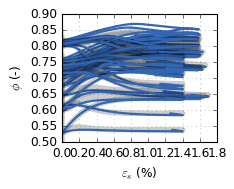

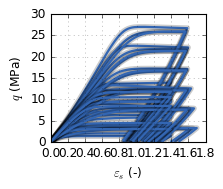

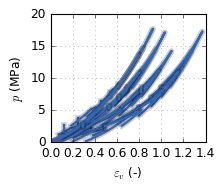

In [19]:
# Plotting strain vs. state variable (phi)
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntrainval)):
    # Plotting actual vs predicted state variable (phi)
    ax.plot(strain_t_tv[:, i, 1], svars_tv[:, i, 1].detach().numpy(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_tv[:, i, 1], pred_svars[:, i, 3].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$\phi$ (-)')
ax.set_xlabel('$\\varepsilon_s$ (%)')
ax.grid()
plt.show()

# Plotting strain vs. stress (q)
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntrainval)):
    # Plotting actual vs predicted stress (q)
    ax.plot(strain_t_tv[:, i, 1], stress_tv[:, i, 1].cpu().detach(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_tv[:, i, 1], pred_stress[:, i, 1].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (-)')
ax.set_ylim(0, 30)
ax.grid()
plt.show()

# Plotting strain vs. stress (p)
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntrainval)):
    # Plotting actual vs predicted stress (p)
    ax.plot(strain_t_tv[:, i, 0], stress_tv[:, i, 0].cpu().detach(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_tv[:, i, 0], pred_stress[:, i, 0].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$p$ (MPa)')
ax.set_xlabel('$\\varepsilon_v$ (-)')
ax.set_ylim(0, 20)
ax.grid()
plt.show()

#### 4.4 Test set evaluation

In [20]:
# Enable gradients for state variables in the test set
svars_test.requires_grad = True

# Creating a time vector for evaluation
t = prm_dt * torch.linspace(0., data_size-1, data_size).to(device)

# Initializing interpolation for the NICE network using test data
NICE_network.init_interp(dstrain_test, t)

# Solving for elastic strain using the root-finding method on the test set
sol = root(NICE_network.find_elastic_strain,
           args=([svars_test[0, :, :1].reshape(-1, 1), svars_test[0, :, -1:].reshape(-1, 1), stress_test[0].reshape(-1, 2)]),
           x0=np.zeros((stress_test.shape[1], 2)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1, 2))

# De-normalizing elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Creating input for the NICE network using the test set
usvars = torch.cat((ueps_e_0, svars_test[0]), -1)

# Predicting with the NICE network using the test set
Ntest = np.arange(0, dstrain_test.shape[1])
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_test, usvars, t, Ntest)

# Evaluating error using L1 loss
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_test, prm_s))
MAE_z = loss(NICE_network.Normalize(pred_svars[:, :, -1:], prm_z), NICE_network.Normalize(svars_test[:, :, -1:], prm_z))

# Printing Mean Absolute Error (MAE) for stress and z on the test set
print("MAE stress : ", MAE_stress,
      "\nMAE z : ", MAE_z)

MAE stress :  tensor(0.0018, dtype=torch.float64, grad_fn=<MeanBackward0>) 
MAE z :  tensor(0.0941, dtype=torch.float64, grad_fn=<MeanBackward0>)


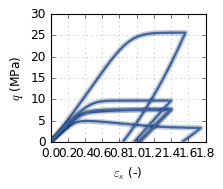

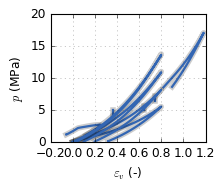

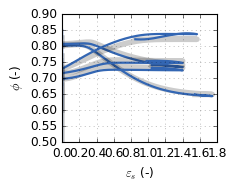

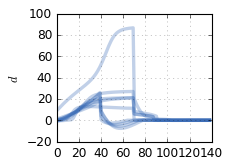

In [22]:
# Plotting strain vs. stress (q) on the test set
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    # Plotting actual vs predicted stress (q)
    ax.plot(strain_t_test[:, i, 1], stress_test[:, i, 1].cpu().detach(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_test[:, i, 1], pred_stress[:, i, 1].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (-)')
ax.grid()
ax.set_ylim(0, 30)
plt.show()

# Plotting strain vs. stress (p) on the test set
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    # Plotting actual vs predicted stress (p)
    ax.plot(strain_t_test[:, i, 0], stress_test[:, i, 0].cpu().detach(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_test[:, i, 0], pred_stress[:, i, 0].cpu().detach(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$p$ (MPa)')
ax.set_xlabel('$\\varepsilon_v$ (-)')
ax.set_ylim(0, 20)
ax.grid()
plt.show()

# Plotting strain vs. state variable (phi) on the test set
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    # Plotting actual vs predicted state variable (phi)
    ax.plot(strain_t_test[:, i, 1], svars_test[:, i, 1].detach().numpy(), linewidth=5, color='black', alpha=0.2,
            markersize=0, marker='.')
    ax.plot(strain_t_test[:, i, 1], pred_svars[:, i, 3].detach().numpy(), linewidth=2, color=colorb, markersize=0,
            marker='.')
ax.set_ylabel('$\phi$ (-)')
ax.set_xlabel('$\\varepsilon_s$ (-)')
ax.grid()
plt.show()

# Plotting dissipation (d) on the test set
fig = plt.figure()
ax = fig.subplots(1)
for i in np.arange(len(ntest)):
    # Plotting predicted dissipation (d)
    ax.plot(pred_diss[:, i].cpu().detach(), linewidth=3, alpha=0.3, color=colorb, markersize=0, marker='.')
ax.set_ylabel('$d$')
ax.grid()
plt.show()

### 5. Inference

In [23]:
# Loading data for benchmark2 inference
file = './dataset/benchmark2_inference_UndrainedTriaxial_phi08'
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Extracting data from the loaded file
[stress_t, strain_t, svars_e_t, epl, r_t, rs_t, stress_tdt, strain_tdt, svars_e_tdt, epl_tdt, r_tdt, rs_tdt, dt, n_reset] = data

# Setting batch_time and data_size based on the loaded data
batch_time = n_reset
data_size = n_reset

# Calculating the strain protocol
dstrain = (strain_tdt - strain_t) / prm_dt

# Reshaping the data for further processing and analysis
strain_t = np.reshape(strain_t, (batch_time, -1, dim), order='F')
dstrain = np.reshape(dstrain, (batch_time, -1, dim), order='F')
r_t = np.reshape(r_t, (batch_time, -1, 1), order='F')
rs_t = np.reshape(rs_t, (batch_time, -1, 1), order='F')
el_strain_t = np.reshape(svars_e_t, (batch_time, -1, dim), order='F')
stress_t = np.reshape(stress_t, (batch_time, -1, dim), order='F')

# Setting data_size and number of initial conditions based on reshaped data
data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

# Converting reshaped data to PyTorch tensors and moving to the specified device
svars = torch.cat((torch.from_numpy(np.float64(r_t)), torch.from_numpy(np.float64(rs_t))), -1).to(device)
stress = torch.from_numpy(np.float64(stress_t)).to(device)
dstrain = torch.from_numpy(np.float64(dstrain)).to(device)

In [24]:
# Setting the NICE network for inference mode
NICE_network.inference = True

# Creating a time vector for the inference
t = torch.arange(0, prm_dt * data_size, prm_dt)

# Extracting initial conditions from the first time step of the loaded data
initial_conditions = torch.cat((svars[0, :, :1].reshape(-1, 1), svars[0, :, -1:].reshape(-1, 1),
                                stress[0].reshape(-1, 2)), -1)

In [25]:
# Creating an array of indices for initial conditions
idx = np.arange(0, number_IC)

# Enabling gradients for initial conditions
initial_conditions.requires_grad = True

# Initializing interpolation for the NICE network using the strain data and time vector
NICE_network.init_interp(dstrain, t)

# Solving for elastic strain using the root-finding method on the initial conditions
sol = root(NICE_network.find_elastic_strain,
           args=([initial_conditions[:, :1], initial_conditions[:, 1:2], initial_conditions[:, 2:]]),
           x0=np.zeros((number_IC, dim)),
           tol=1e-12)
eps_e_0 = torch.from_numpy(sol.x.reshape(-1, 2))

# De-normalizing elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Creating input for the NICE network using the solved elastic strain and initial state variables
usvars = torch.cat((ueps_e_0, svars[0]), -1)

# Predicting with the NICE network using the strain data and initial conditions
pred = NICE_network.integrate(dstrain, usvars, t, idx)
pred_svars, pred_stress, pred_diss = pred

# Converting the predicted values to NumPy arrays
pred_svars = pred_svars.cpu().detach().numpy()
pred_stress = pred_stress.cpu().detach().numpy()
pred_diss = pred_diss.cpu().detach().numpy()

In [26]:
# Calculating stress ratios from the loaded stress data
stress_ratio = stress_t[:, :, 1] / stress_t[:, :, 0]

# Calculating stress ratios from the predicted stress values
pred_stress_ratio = pred_stress[:, :, 1] / pred_stress[:, :, 0]

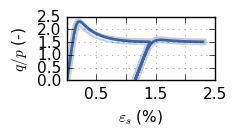

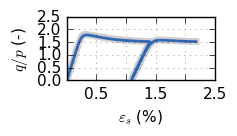

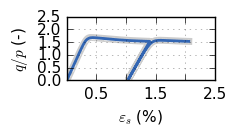

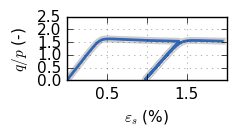

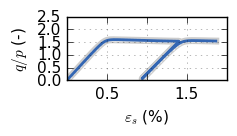

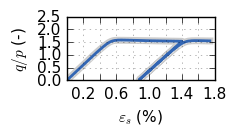

In [27]:
nid = 1

# Loop over different figures for visualization
for idd in range(6):
    # Create a new figure with specified properties
    fig = plt.figure(dpi=100, figsize=(2.5, 1.5), tight_layout=True)
    axes = fig.subplots(1)

    # Plotting reference stress ratio with markers and lines
    axes.plot(strain_t[:, idd:idd + nid, 1], stress_ratio[:, idd:idd + nid], marker='o', markerfacecolor='white',
              linestyle='-', color='black', alpha=0.2, linewidth=5, markersize=0, label='ref')

    # Plotting a subset of reference stress ratio with smaller markers
    axes.plot(strain_t[::2, idd:idd + nid, 1], stress_ratio[::2, idd:idd + nid], marker='o', markerfacecolor='white',
              markeredgewidth=0.0, linestyle='-', color='black', alpha=0.5, linewidth=0, markersize=2.5)

    # Plotting predicted stress ratio with specified properties
    axes.plot(strain_t[:, idd:idd + nid, 1], pred_stress_ratio[:, idd:idd + nid], alpha=1, linewidth=2, color=colorb,
              markersize=0, markeredgewidth=0.0, marker='.')

    # Set labels and customize x-axis tick visibility
    axes.set_ylabel('$q/p$ (-)')
    axes.set_xlabel('$\\varepsilon_s$ (%)')
    every_nth = 2
    for n, label in enumerate(axes.xaxis.get_ticklabels()):
        if n % every_nth == 0:
            label.set_visible(False)

    # Customize the plot appearance and limit the y-axis
    axes.grid()
    axes.set_ylim(0, 2.5)

    # Show the plot
    plt.show()

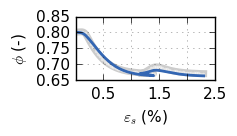

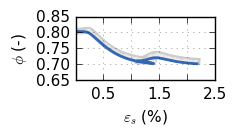

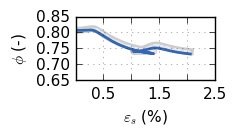

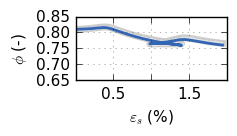

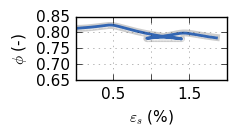

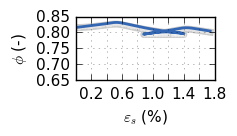

In [28]:
# Loop over different figures for visualization
for idd in range(6):
    # Create a new figure with specified properties
    fig = plt.figure(dpi=100, figsize=(2.5, 1.5), tight_layout=True)
    axes = fig.subplots(1)

    # Plotting reference value of state variable with markers and lines
    axes.plot(strain_t[:, idd:idd + nid, 1], rs_t[:, idd:idd + nid, -1], marker='o', markerfacecolor='white',
              linestyle='-', color='black', alpha=0.2, linewidth=5, markersize=0, label='ref')

    # Plotting a subset of reference values with smaller markers
    axes.plot(strain_t[::2, idd:idd + nid, 1], rs_t[::2, idd:idd + nid, -1], marker='o', markerfacecolor='white',
              markeredgewidth=0.0, linestyle='-', color='black', alpha=0.5, linewidth=0, markersize=2.5)

    # Plotting predicted values of state variable with specified properties
    axes.plot(strain_t[:, idd:idd + nid, 1], pred_svars[:, idd:idd + nid, -1], alpha=1, linewidth=2, color=colorb,
              markersize=0, markeredgewidth=0.0, marker='.')

    # Set labels and customize x-axis tick visibility
    axes.set_ylabel('$\phi$ (-)')
    axes.set_xlabel('$\\varepsilon_s$ (%)')
    axes.grid()
    every_nth = 2
    for n, label in enumerate(axes.xaxis.get_ticklabels()):
        if n % every_nth == 0:
            label.set_visible(False)

    # Customize the plot appearance and limit the y-axis
    axes.set_ylim(0.65,0.85)
    plt.show()

### 6. Save model

In [29]:
# Define the file path for saving the model state dictionary
PATH = './saved/[state]NICE_benchmark2_sparse'

# Save the state dictionary of the NICE_network model to the specified file path
torch.save(NICE_network.state_dict(), PATH)

In [30]:
# Define the file path for saving the norm_params list
params_PATH = './saved/[params]NICE_benchmark2_sparse'

# Save the norm_params list to the specified file path using pickle
with open(params_PATH, 'wb') as f_obj:
    pickle.dump(norm_params, f_obj)